In [2]:
import music21 as m21
from music21 import * 
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from collections import Counter


In [3]:
#リズムなどメタデータの取得をGracenoteAPIに任せる
import pygn
import requests
import xml
import seaborn as sns

In [4]:
import nltk

In [5]:
import matplotlib as mpl


In [6]:
mpl.font_manager.findSystemFonts()

['C:\\WINDOWS\\Fonts\\GOUDOS.TTF',
 'C:\\WINDOWS\\Fonts\\PERTILI.TTF',
 'c:\\windows\\fonts\\javatext.ttf',
 'C:\\WINDOWS\\Fonts\\LSANSD.TTF',
 'c:\\windows\\fonts\\gilsanub.ttf',
 'C:\\WINDOWS\\Fonts\\verdanaz.ttf',
 'c:\\windows\\fonts\\centaur.ttf',
 'C:\\WINDOWS\\Fonts\\GILC____.TTF',
 'C:\\WINDOWS\\Fonts\\corbel.ttf',
 'C:\\WINDOWS\\Fonts\\BC______.TTF',
 'c:\\windows\\fonts\\cambriaz.ttf',
 'c:\\windows\\fonts\\impact.ttf',
 'c:\\windows\\fonts\\finmall_.ttf',
 'c:\\windows\\fonts\\lsansd.ttf',
 'C:\\WINDOWS\\Fonts\\segoeuisl.ttf',
 'c:\\windows\\fonts\\kousakupercussion.ttf',
 'C:\\WINDOWS\\Fonts\\LHANDW.TTF',
 'C:\\WINDOWS\\Fonts\\constan.ttf',
 'C:\\WINDOWS\\Fonts\\FRAMDCN.TTF',
 'C:\\WINDOWS\\Fonts\\LTYPEO.TTF',
 'C:\\WINDOWS\\Fonts\\LSANSDI.TTF',
 'C:\\WINDOWS\\Fonts\\Jazz____.ttf',
 'c:\\windows\\fonts\\natya5.ttf',
 'c:\\windows\\fonts\\ariali.ttf',
 'c:\\windows\\fonts\\msyi.ttf',
 'c:\\windows\\fonts\\calibrii.ttf',
 'c:\\windows\\fonts\\juice___.ttf',
 'C:\\WINDOWS\\Fon

In [7]:
#ピッチナンバーと調の変換
map_pitch_class = {"C":0,"C#":1,"D":2,"D#":3,"E":4,"F":5,"F#":6,"G":7,"G#":8,"A":9,"B-":10,"B":11}
#覚えているかどうか
memorable = {"あまり覚えてない":1,"だいたいは覚えている":2,"完璧に覚えている":3}
#

In [8]:
def shuukei(vocalpart):
    """
    音価・音高のペアのオブジェクトを楽譜から作る
    タイの部分→連結

    """
    record = []
    checker = False
    #タイがついた場合の途中記録用
    pitch_tmp = 0.0
    duration_tmp = 0.0
    for i in vocalpart.flat.notesAndRests.stream():
        
        #タイがついている
        if i.tie:
            #タイのはじめの音ならまず音高を記録する
            if checker == False:
                if i.isNote == True:
                    #record.append([i.pitch.ps,i.duration.quarterLength])
                    #音符はノート番号
                    pitch_tmp = i.pitch.ps
                    duration_tmp += i.duration.quarterLength
                elif i.isRest == True:
                    #record.append(["rest",i.duration.quarterLength])
                    #休符は無限にする
                    pitch_tmp = np.inf
                    duration_tmp += i.duration.quarterLength
                
            #タイの途中の音なら音長を足していく      
            else:
                duration_tmp += i.duration.quarterLength
            
            #タイはついている   
            checker = True
        
        #タイがついてない    
        else:
            checker = False
            #直前がタイの最後の音ならタイでつながって一音になった音を追加
            if not duration_tmp == 0.0:
                record.append([pitch_tmp,duration_tmp])
                duration_tmp = 0.0
            
            #そうでなければ普通に追加
            if i.isNote == True:
                record.append([i.pitch.ps,i.duration.quarterLength])
            elif i.isRest == True:
                record.append([np.inf,i.duration.quarterLength])

    return record

In [9]:
def count_duration(song):
    #[音高,音価]が要素になったリストから音価を集計する
    lis = []
    for n in range(len(song)):
        lis.append(song[n][1])
    duration_count = Counter(lis)
    #集計結果のカウンターを返す
    #sorted_count = sorted(duration_count.items(),key=lambda x:x[0])
    #return sorted_count
    
    return duration_count

In [10]:
def count_pitch(song):
    #[音高,音価]が要素になったリストから音高を集計する
    lis = []
    for n in range(len(song)):
        lis.append(song[n][0])
    pitch_count = Counter(lis)
    #集計結果のカウンターを返す
    return pitch_count

In [11]:
def make_pitch_bigram(shuukei_obj):
    #[音高,音価]が要素になったリストから音高のBigramのリストを作成する
    pitch_diff = []
    for i in range(len(shuukei_obj)-1):
        if shuukei_obj[i+1][0] > 10000 and shuukei_obj[i][0] > 10000:
        	pass
        else:
            pitch_diff.append(shuukei_obj[i+1][0] - shuukei_obj[i][0])
    return pitch_diff

In [12]:
def make_duration_bigram(shuukei_obj):
    #[音高,音価]が要素になったリストから音価のBigramのリストを作成する
    duration_diff = []
    for i in range(len(shuukei_obj)-1):
        duration_diff.append(shuukei_obj[i+1][1] - shuukei_obj[i][1])
    return duration_diff

In [13]:
def jump_rate(bigram_status):
    #バイグラム列から跳躍、下降跳躍、上向跳躍の割合を返す
    up_jump = 0
    down_jump = 0
    slope = 0 
    for key in bigram_status.keys():
        if np.abs(key) <= 2:
            slope += bigram_status[key]
        elif np.abs(key) <= 10000:
            if key > 0:
            	up_jump += bigram_status[key]
            else:
                down_jump += bigram_status[key]
    all_of_notes = up_jump + down_jump + slope
    
    return [(up_jump+down_jump)/all_of_notes,up_jump/all_of_notes,down_jump/all_of_notes]         

In [14]:
def delete_inf(bigram_status): 
    #休符を含むBigramから休符を削除
    del bigram_status[np.inf]
    del bigram_status[-np.inf]
    del bigram_status[None]
    return bigram_status

In [15]:
#Aメロ,Bメロ,サビに分割
#各セクションの始点と終点の小節番号を引数に与える
def separate_section(piece,a_start,a_end,b_start,b_end,s_start,s_end):
    sections = []
    amero = piece.measures(a_start,a_end)
    bmero = piece.measures(b_start,b_end)
    sabi = piece.measures(s_start,s_end)
        
    print(sabi)
    sections.append(amero)
    sections.append(bmero)
    sections.append(sabi)
    
    return sections

In [16]:
#カウンターオブジェクトのプロット
def counter_plot(counter,song,section,analysee_name,bar_color):
    left = counter.keys()
    height = counter.values()
    plt.title("song: {} ({}'s {})".format(song,section,analysee_name))
    plt.bar(left,height,color=bar_color)
    for x, y in zip(left, height):
        try: 
            plt.text(x, y, y, ha='center', va='bottom')
        except ValueError: 
            pass 
    plt.grid()
    plt.show()

In [17]:
#音高、音価のペアのリストをセクションごとに作成
def make_note(sections):
    notes = []
    for item in sections:
        note_obj = shuukei(item) 
        notes.append(note_obj)
    return notes

In [18]:
#セクションごとに音高、音価のペア列から音程列を作成
def make_pitch_diff(notes):
    ontei = []
    for item in notes:
        bigram = make_pitch_bigram(item)
        onteiobj = delete_inf(Counter(bigram))
        ontei.append(onteiobj)
    return ontei

In [19]:
#音域の計算
def pitch_range(sec):
    a = []
    for i in sec.flat.notes:
        a.append(i.pitch.ps)
    max_note = int(max(a))
    min_note = int(min(a))
    return [max_note,min_note,max_note-min_note]

In [20]:
#どの区間の音かで異なる数値を返す関数
def weighted_pitch(num,w1,w2,w3,point1,point2):
    """
    note_num→入力音符のノートナンバー
    wi→返す重み
    pointi→声の喚声点
    """
    if num < point1:
        return w1
    elif num < point2:
        return w2
    else:
        return w3

In [21]:
#WPCS値
'''
def weighted_pitch_count_sum(sec,w1,w2,w3):
    wpcs = 0
    for i in sec.flat.notes:
        wpcs += weighted_pitch(i.pitch.ps,w1,w2,w3)
    return wpcs 
'''

def weighted_pitch_count_sum(sec,w1,w2,w3):
    wpcs = 0
    for i in sec:
        wpcs += weighted_pitch(i,w1,w2,w3)
    return wpcs 

In [22]:
#オクターブや調がおかしい場合の前処理
def note_remadiation(vocal,seminotes):
    if seminotes == 0 :
        pass
    else:
        for i in vocal.flat.notes.stream():
        #for n in pitchStream.recurse().notes:
            i.transpose(seminotes, inPlace=True)
    return vocal

In [23]:
#ノートナンバーを音名に変換
def notenum2pitch(num):
    if num < 1000:
        convert = {0:"C",1:"C#",2:"D",3:"D#",4:"E",5:"F",6:"F#",7:"G",8:"G#",9:"A",10:"A#",11:"B"}
        octave = int(num/12)-1
        return convert[num%12]+ str(octave)
    elif num == np.inf:
        return "Rest"
    else:
        raise TypeError
        

In [24]:
#セクションごとに各音の音価の総和を出力
def make_sum(secs):
    state = []
    for notes in secs:
        dic = {}
        for note in notes:
            if not note[0] in dic:
                dic[note[0]] = note[1]
            else:
                dic[note[0]] += note[1]
        state.append(dic)
    return state 

In [25]:
#藤井論文音価難易度
def mode_multiOK(list_obj):
    arr = []
    counter_most_common = Counter(list_obj).most_common()
    longest = counter_most_common[0][1]
    for i in counter_most_common:
        l = i[1]
        if l == longest:
            arr.append(i[0])
        else:
            break
    return arr

def dc(length):
    difficulty = 0
    if length >= 2.0:
        difficulty = 2.0
    elif length == 1.0:
        difficulty = 4.0
    elif length == 0.5:
        difficulty = 6.0
    elif length == 0.25:
        difficulty = 8.0
    else:
        difficulty = 9.0
    return difficulty


def rhythm_difficulty(notes):
    #print("notes:{}".format(notes))
    l = 0
    #全ての音価を記録
    tmp = []
    #最頻の音価より短いもの
    longer = []
    #最頻の音価より長いもの
    shorter = []
    #
    a= 0.0
    s = 0.0
    d1 = 0.0
    
    #音価列の記録
    for note in notes:
        #print("note:{}".format(note))
        dur = note.duration.quarterLength
        #print("{} append to tmp".format(dur))
        tmp.append(dur)
    #最頻音価の記録
    l = mode_multiOK(tmp)
    #print("l:{}".format(l))
    dp = sum(list(map(dc,l)))/len(l)
    #print("dp:{}".format(dp))
    #最頻音価より長い/短いに着目して記録
    for note in notes:
       
        dur = note.duration.quarterLength
        #print("dur:{}".format(dur))
        if dur in l:
            #print("skip")
            pass
        elif dur < min(l):
            shorter.append(dur)
        elif dur > max(l):
            longer.append(dur)
    #print("l:{},s:{}".format(longer,shorter))      
    n = len(shorter) + len(longer) 
    if n ==0:
        return dp
    else:
        a_max = (10-dp)/n
        s_max = (dp-1)/n
        for snote in shorter:
            a += ((dc(snote)-dp)/dp) * a_max
        for lnote in longer:
            s += ((dp- dc(lnote))/dp) * s_max
        #print("a:{},s:{}".format(a,s))
        
        d1 = dp+a-s
    
        return d1


## 予備実験概要

実験参加者数　6人（21～24歳の男子６人、内音楽経験あり３人）
実施楽曲　6曲＋α


In [26]:
#セクションを解析しやすいように
analysis_corpus = []
analysis_section = {0:"A melody",1:"B melody",2:"Sabi"}

## テストコード

#楽譜の読み込み
cherry = m21.converter.parse("./cherry.xml").parts[0]
#各セクションに分ける
cherry_section = []
cherry_a = cherry.measures(1,8)
cherry_b = cherry.measures(9,16)
cherry_s = cherry.measures(16,24)

cherry_section.append(cherry_a)
cherry_section.append(cherry_b)
cherry_section.append(cherry_s)
#音高,音価の列のオブジェクトを作成
cherry_section_notes = []
for item in cherry_section:
    notes = shuukei(item)
    cherry_section_notes.append(notes)
#音高Bigramを作成
cherry_ontei = []
for item in cherry_section_notes:
    bigram = make_pitch_bigram(item)
    onteiobj = delete_inf(Counter(bigram))
    cherry_ontei.append(onteiobj)
#音高差の集計をプロット
for num,item in enumerate(cherry_ontei):
    counter_plot(item,"cherry",str(analysis_section[num]),"pitch_diff")
#音高の集計
for item in cherry_section:
    item.plot("histogram","pitch")
    item.plot("histogram","pitchclass") 

for num,item in enumerate(cherry_section_notes):
    dcount = count_duration(item)
    #print(dcount)
    duras = {}
    for i in sorted(dcount.keys()):
        new_key = str(i)
        duras[new_key] = dcount[i]
    counter_plot(duras,"cherry",str(analysis_section[num]),"duration by Quarter Length")
#調,音符数,跳躍率
analysis_section = {0:"Amelody",1:"Bmelody",2:"Sabi"}
print(len(cherry))
print(analysis.discrete.analyzeStream(cherry,"Krumhansl"))
for num,section in enumerate(cherry_section):
    print(section)
    print("-------{}の統計情報---------".format(analysis_section[num]))
    print("調:{}".format(analysis.discrete.analyzeStream(section,"Krumhansl")))

In [27]:
class gakuhu_object:
    """
    ボーカルパートのあらゆる情報を保持するクラス
    
    __init__(self,file)　
    初期化、読み込む楽譜ファイルを与える
    
    show_key(self)
    調の表示をセクションごとにおこなう
    """
    
    #コンストラクタ
    def __init__(self,name,file,separate_info,seminote):
        #楽曲名
        self.name = name
        #ボーカルパートを読み込み（一つ目のパートがボーカルである前提・・・）
        self.piece = note_remadiation(m21.converter.parse("./" + file).parts[0],seminote)
        #Aメロ、Bメロ、サビのオブジェクトを保持する
        self.sections = separate_section(self.piece,separate_info[0],separate_info[1],separate_info[2],separate_info[3],separate_info[4],separate_info[5])
        #音高、音列のペア
        self.notes = make_note(self.sections)
        #音程列
        self.ontei = make_pitch_diff(self.notes)
        #各音の音価の総和
        self.sum_note_length = make_sum(self.notes)
        
        analysis_corpus.append(self)
    #調の表示
    def show_key(self):
        print("------------"+self.name +"-------------")
        for num,section in enumerate(self.sections):
            print("-------{}の統計情報---------".format(analysis_section[num]))
            print("調:{}".format(analysis.discrete.analyzeStream(section,"Krumhansl")))
    """
    #音高、音価のペアのリストをセクションごとに作成
    def make_note(self):
        for item in self.sections:
            note_obj = shuukei(item) 
            self.notes.append(note_obj)
    
    #音程列の作成
    def make_pitch_diff(self):
        for item in self.notes:
            bigram = make_pitch_bigram(item)
            onteiobj = delete_inf(Counter(bigram))
            self.notes.append(onteiobj)
    """    
    #音高のカウント
    def counting_pitch(self):
        for num,item in enumerate(self.sections):
            pitch_space = graph.plot.HistogramPitchSpace(item,xHideUnused=False,title=self.name + " " + analysis_section[num] + " pitch")
            pitch_space.colors = "magenta"
            pitch_space.run()
            pitch_class = graph.plot.HistogramPitchClass(item,xHideUnused=False,title=self.name + " " +  analysis_section[num] + " pitch class")
            pitch_class.colors = "cyan"
            pitch_class.run()
            #item.plot("histogram","pitch",xHideUnused=False)
            #item.plot("histogram","pitchclass",xHideUnused=False) 
        
    #音価のカウント
    def counting_duration(self):
        for num,item in enumerate(self.notes):
            dcount = count_duration(item)
            #print(dcount)
            duras = {}
            for i in sorted(dcount.keys()):
                new_key = str(i)
                duras[new_key] = dcount[i]
            counter_plot(duras,self.name,str(analysis_section[num]),"duration by Quarter Length","g")
            
    #音高差の集計をプロット
    def plot_pitch_diff(self):
        for num,item in enumerate(self.ontei):
            counter_plot(item,self.name,str(analysis_section[num]),"pitch_diff","r")
        
    #跳躍進行の割合を表示        
    def calucurate_jump(self):
        for num,sect in enumerate(self.ontei):
            a = delete_inf(Counter(sect))
            jump_status = jump_rate(a)
            print("{}の跳躍情報　跳躍の割合:{:.2},上向跳躍の割合:{:.2},下降跳躍の割合:{:.2}".format(analysis_section[num],jump_status[0],jump_status[1],jump_status[2]))

    #音域（何半音ぶんか）を表示
    def caluculate_pitch_range(self):
        status = []
        for num,sect in enumerate(self.sections):
            status = pitch_range(sect)
            print("{0}の音域情報　最低音:{2},最高音:{1},音域:{3}半音({4}-{5})".format(analysis_section[num],notenum2pitch(status[0]),notenum2pitch(status[1]),status[2],status[1],status[0]))
            
    #音価の難易度（藤井）の表示
    def caluculate_duration_difficulty(self):
         for num,sect in enumerate(self.sections):
            #print(sect)
            print("{}の音価難易度{:.3}".format(analysis_section[num],rhythm_difficulty(sect.flat.notes)))
            
    #タイの数
    def count_tie(self):
        for num,sect in enumerate(self.sections):
            tie_count = 0
            for note in sect.flat.notes:
                #print(note)
                if note.tie:
                    if note.tie.type == "start":
                        tie_count += 1
                    
            print("{}のタイの数{}".format(analysis_section[num],tie_count))
            
            """
            for note in sect.flat.notes:
                print(note.duration.quarterLength)
            """
        
    """       
    #音域の集計（重み付き）
    def caluculate_wpcs(self,w1,w2,w3):
        status = []
        for num,sect in enumerate(self.sections):
            a = []
            for i in sect.flat.notes:
                a.append(i.pitch.ps)
            dic = Counter(a)
        
            status.append(weighted_pitch_count_sum(a.keys()),1,1.25,1.5)
    """
        
    

## 実際に6曲分、分析してみる



In [35]:
analysis_corpus = []
cherry = gakuhu_object("Cherry","cherry.xml",[1,8,9,15,16,24],0)
tsunami = gakuhu_object("TSUNAMI","TSUNAMI.xml",[1,16,17,25,25,42],0)
roman = gakuhu_object("Roman Hikou","roman.xml",[1,8,9,16,16,29],-12)
aporo = gakuhu_object("Aporo","aporo3.xml",[20,34,35,43,44,59],0)
guren = gakuhu_object("Guren No Yumiya","guren.mxl",[12,27,28,35,36,51],0)
konayuki = gakuhu_object("Konayuki","konayuki.mxl",[5,26,27,37,37,45],0)
ultra = gakuhu_object("Ultra soul","ultrasoul.mxl",[17,24,25,28,29,39],0)
koi = gakuhu_object("Koi","koi.mxl",[9,24,25,32,33,54],0)
zenzen = gakuhu_object("ZenZenZense","zenzenzense.mxl",[16,35,37,53,54,73],0)

<music21.stream.Part トラック 0>
<music21.stream.Part ピアノ>
<music21.stream.PartStaff P1-Staff1>
<music21.stream.Part ボーカル>
<music21.stream.Part ボーカル>
<music21.stream.Part Lead>
<music21.stream.Part ももこ>
<music21.stream.Part リード>
<music21.stream.Part Flute>


In [37]:
def weighted_pitch_range(length_dict):
    wpcss = []
    for lengths in length_dict:
        wpcs = 0.0
        length_sum = 0.0
        for note_num in lengths.keys():
            length_sum += lengths[note_num]
            if note_num > 10000:
                pass
            else:
                wpcs += lengths[note_num] * weighted_pitch(note_num,1,1.5,2.0,55,67)
        wpcss.append(wpcs/length_sum)
    return wpcss


In [32]:
test = m21.converter.parse("test.xml")
    

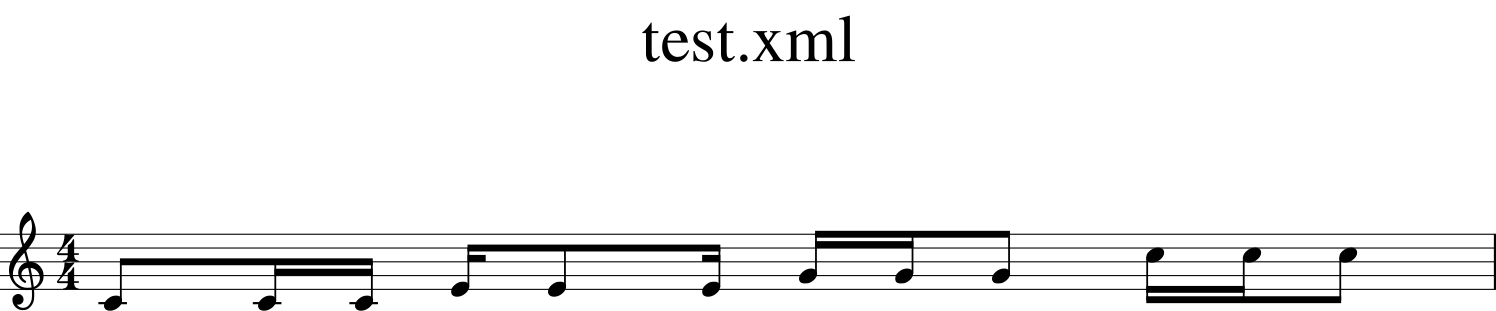

6.25
<music21.stream.iterator.StreamIterator for Score:0x2198a137be0_flat @:16>


In [35]:
test_a = test.measures(1,1)
test_b = test.measures(2,2)
test_c = test.measures(3,3)
test_d = test.measures(4,4)
test_d.show()


print(rhythm_difficulty(test_d.flat.notes))
print(test_d.flat.notes)


------------Cherry-------------
-------A melodyの統計情報---------
調:d minor
-------B melodyの統計情報---------
調:a minor
-------Sabiの統計情報---------
調:C major


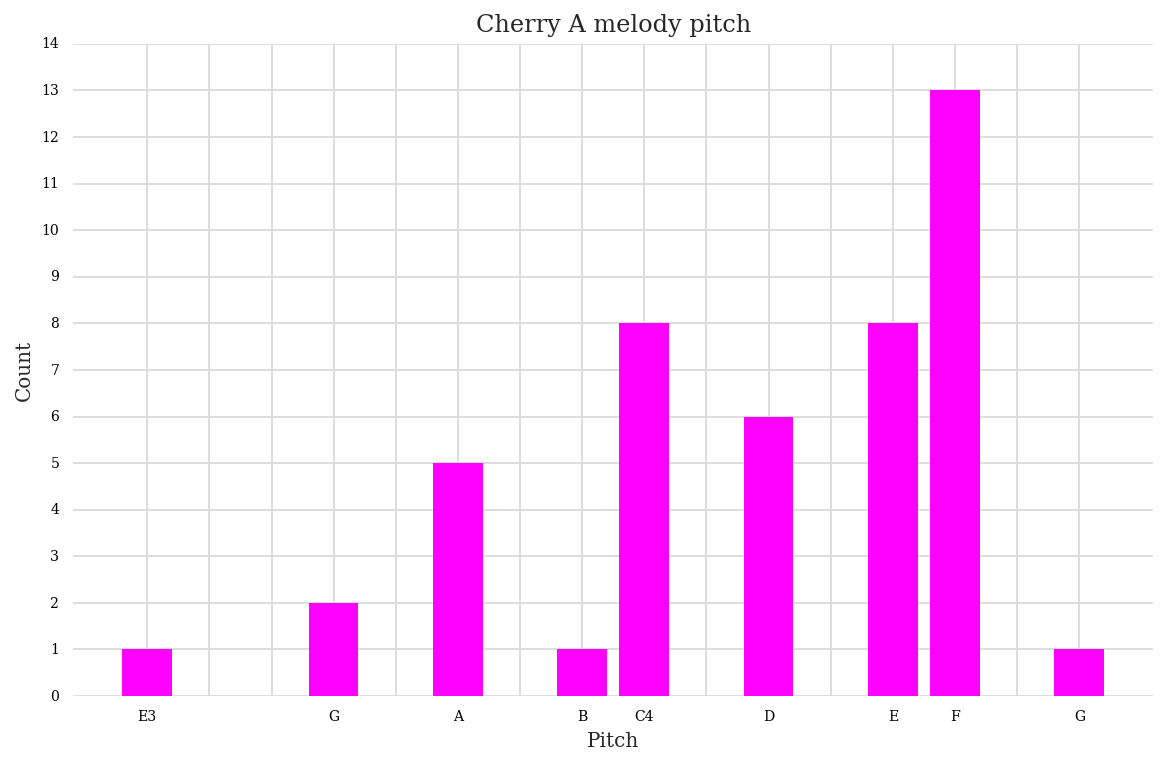

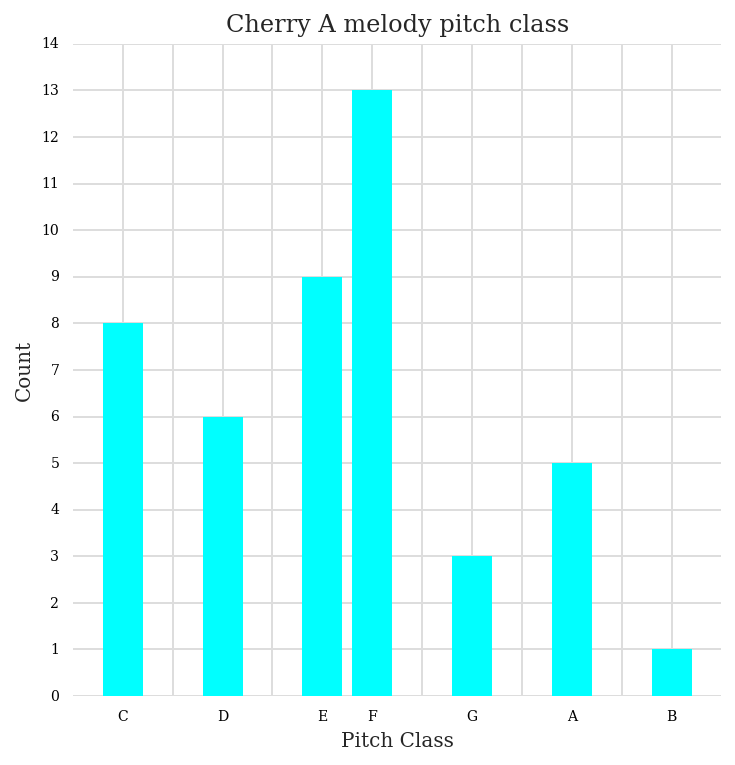

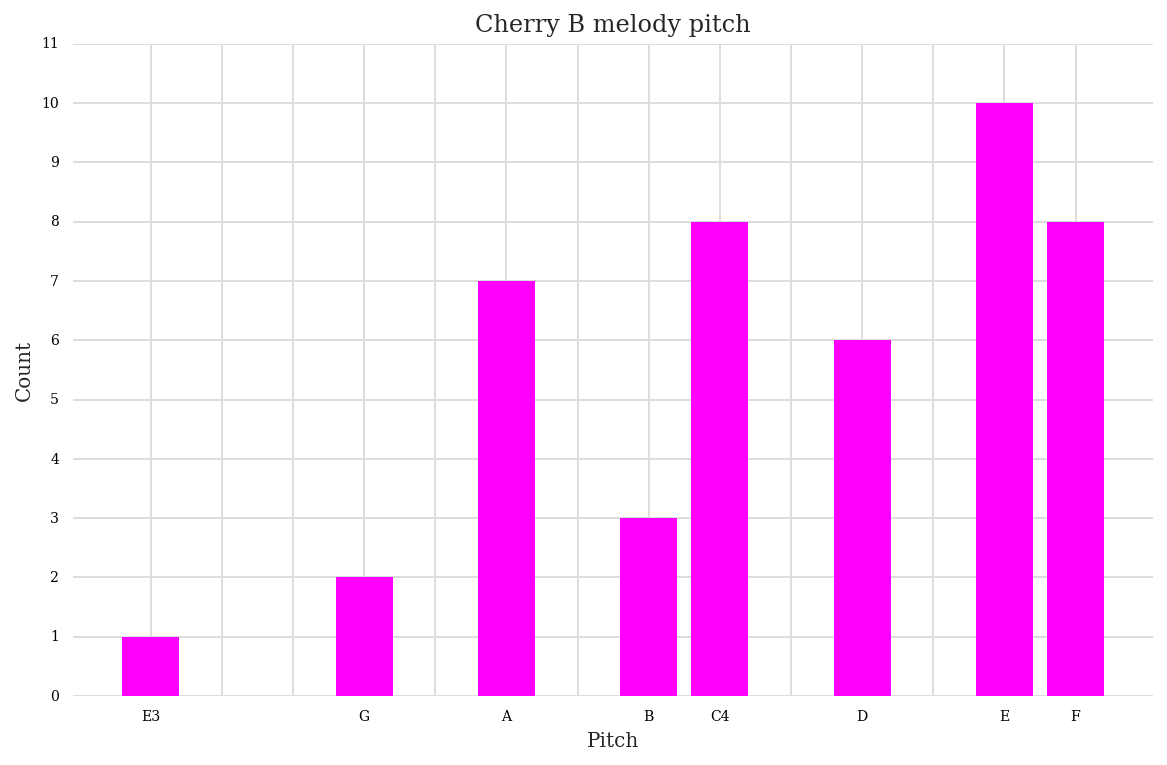

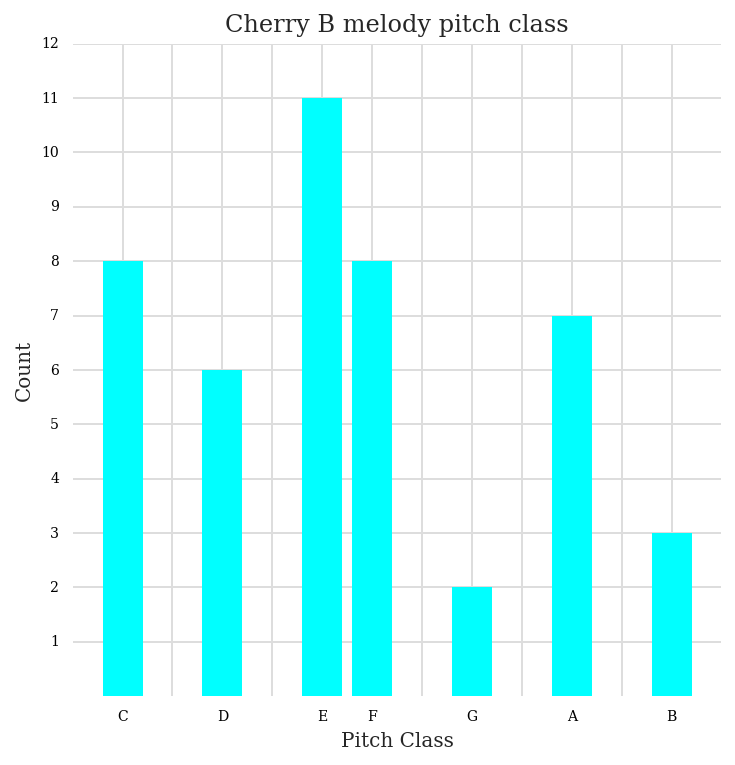

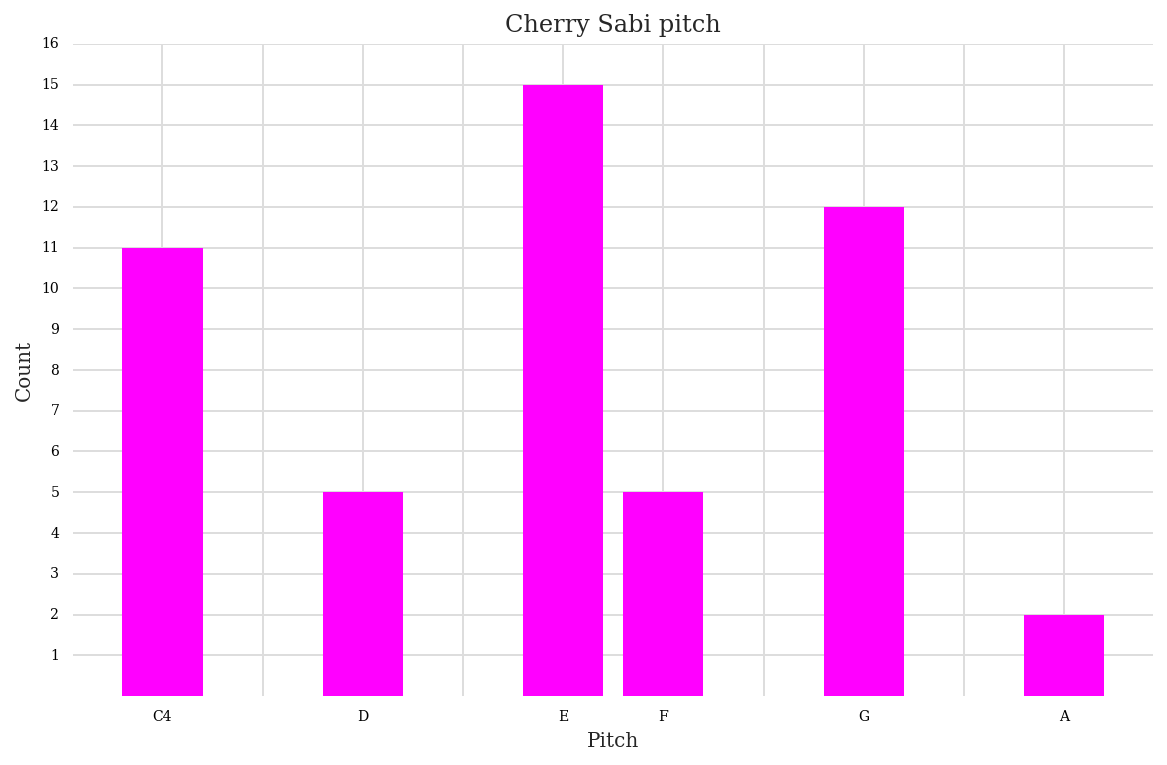

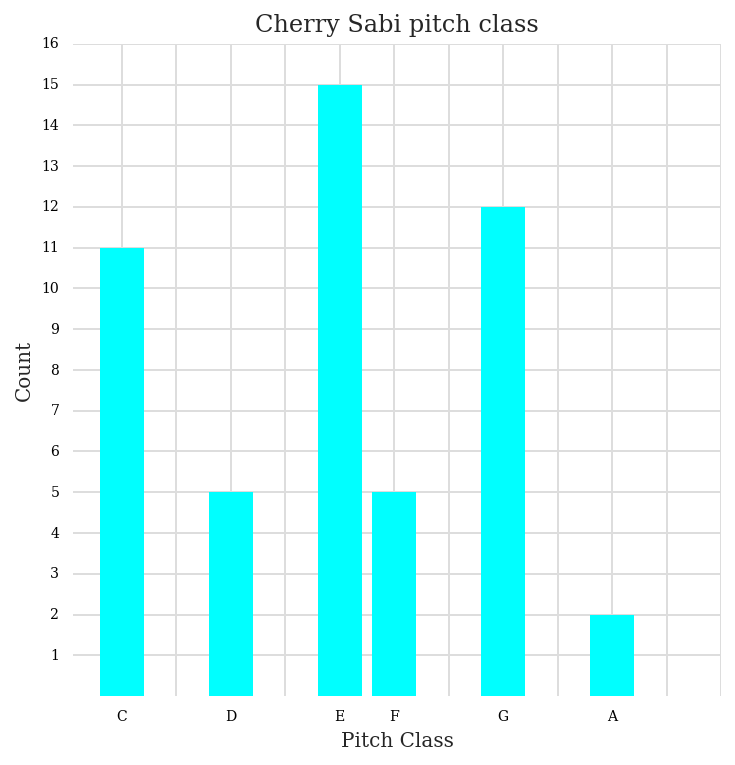

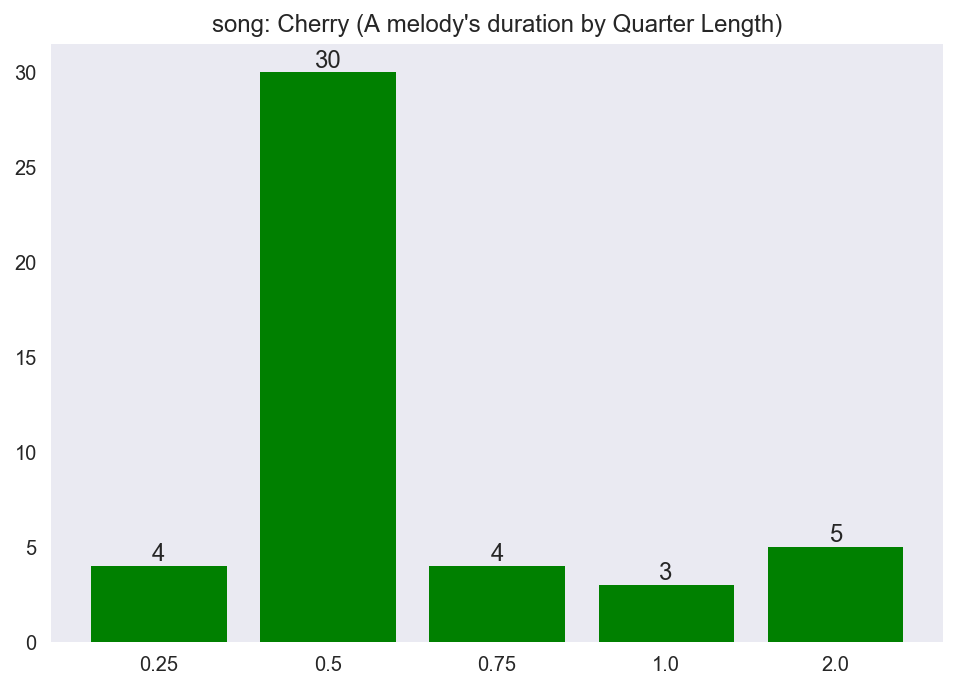

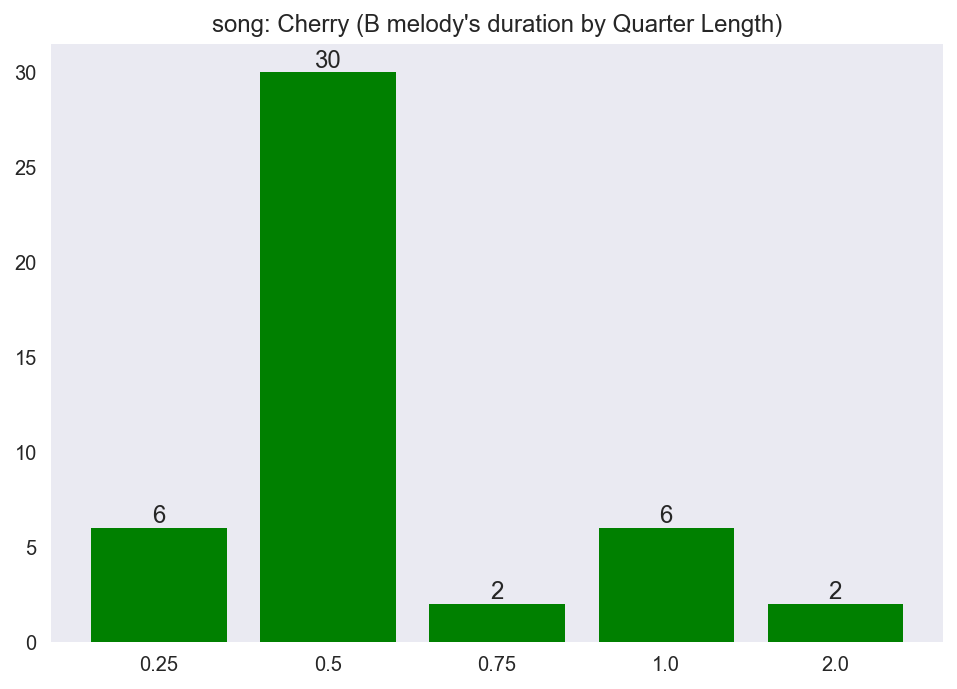

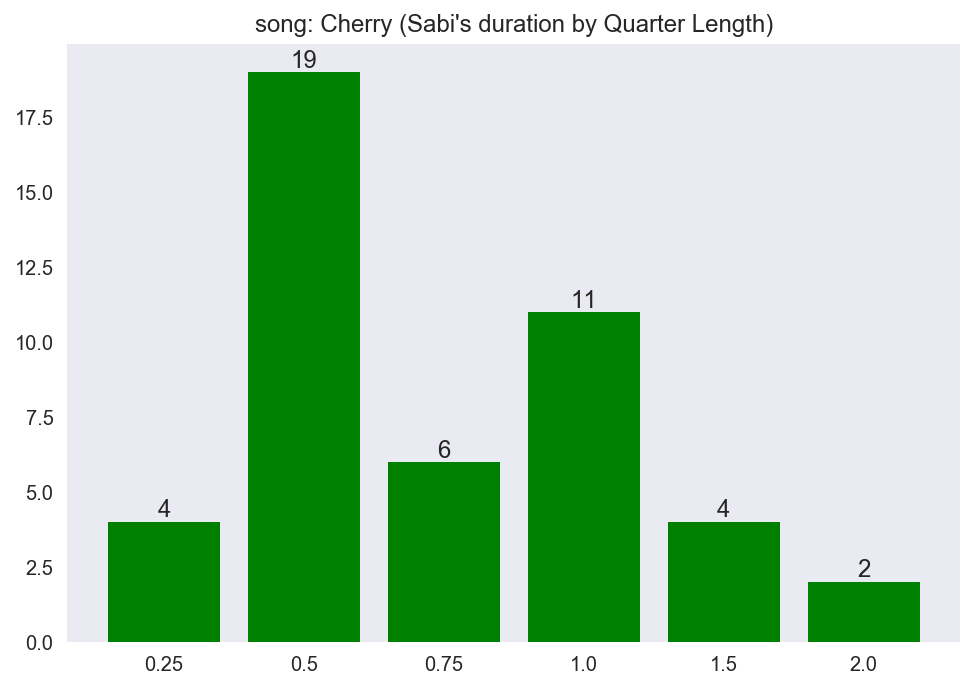

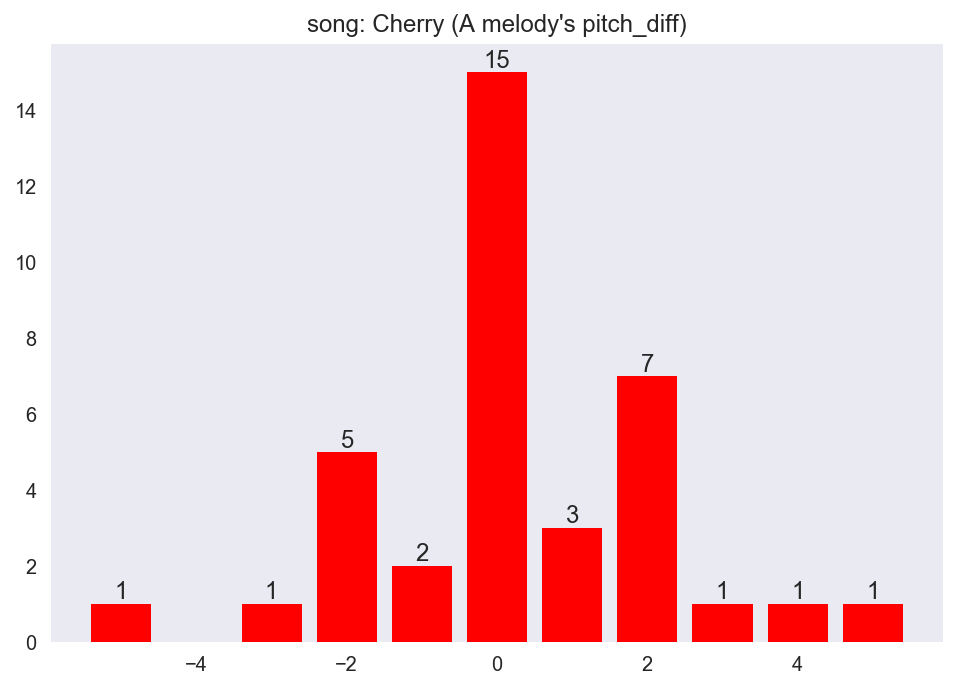

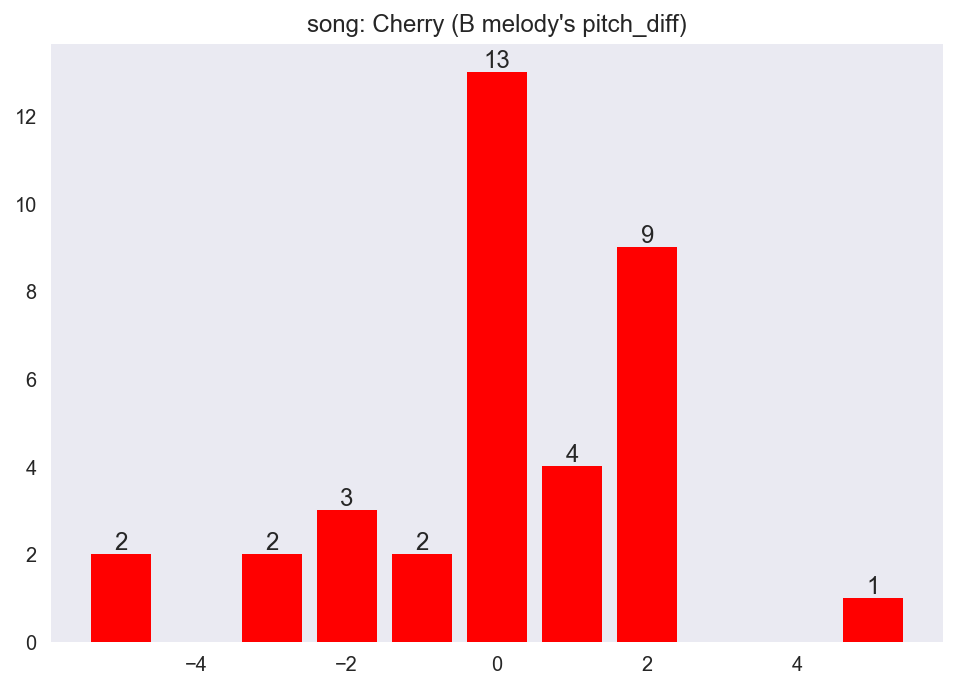

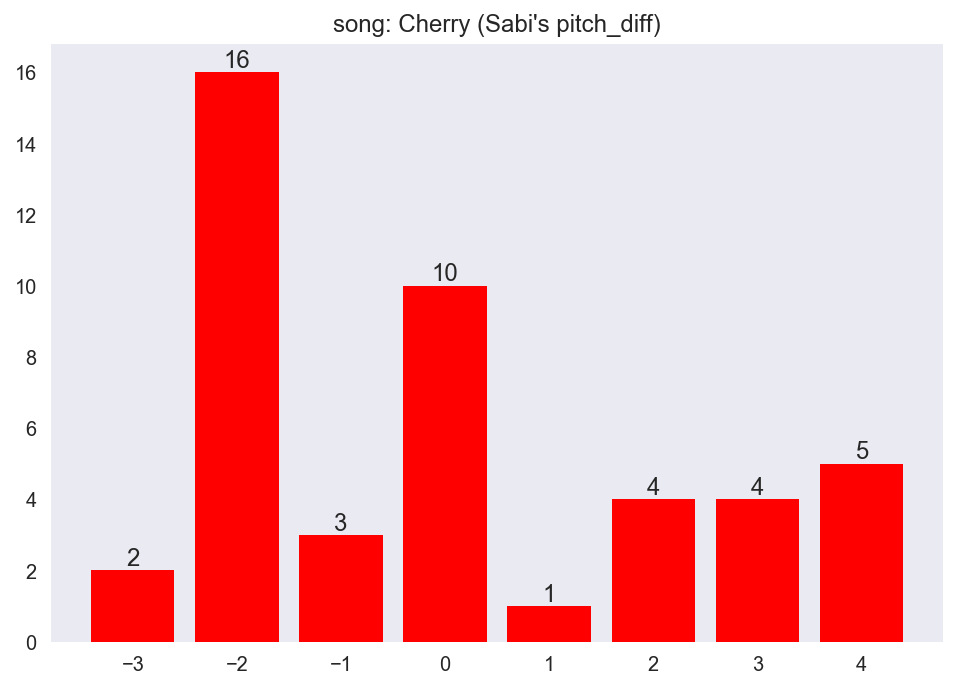

A melodyの跳躍情報　跳躍の割合:0.14,上向跳躍の割合:0.081,下降跳躍の割合:0.054
B melodyの跳躍情報　跳躍の割合:0.14,上向跳躍の割合:0.028,下降跳躍の割合:0.11
Sabiの跳躍情報　跳躍の割合:0.24,上向跳躍の割合:0.2,下降跳躍の割合:0.044
A melodyの音域情報　最低音:E3,最高音:G4,音域:15半音(52-67)
B melodyの音域情報　最低音:E3,最高音:F4,音域:13半音(52-65)
Sabiの音域情報　最低音:C4,最高音:A4,音域:9半音(60-69)
Cherry
A melodyの音価難易度5.78
B melodyの音価難易度6.15
Sabiの音価難易度6.37
A melodyのタイの数4
B melodyのタイの数4
Sabiのタイの数4
------------TSUNAMI-------------
-------A melodyの統計情報---------
調:D major
-------B melodyの統計情報---------
調:D major
-------Sabiの統計情報---------
調:D major


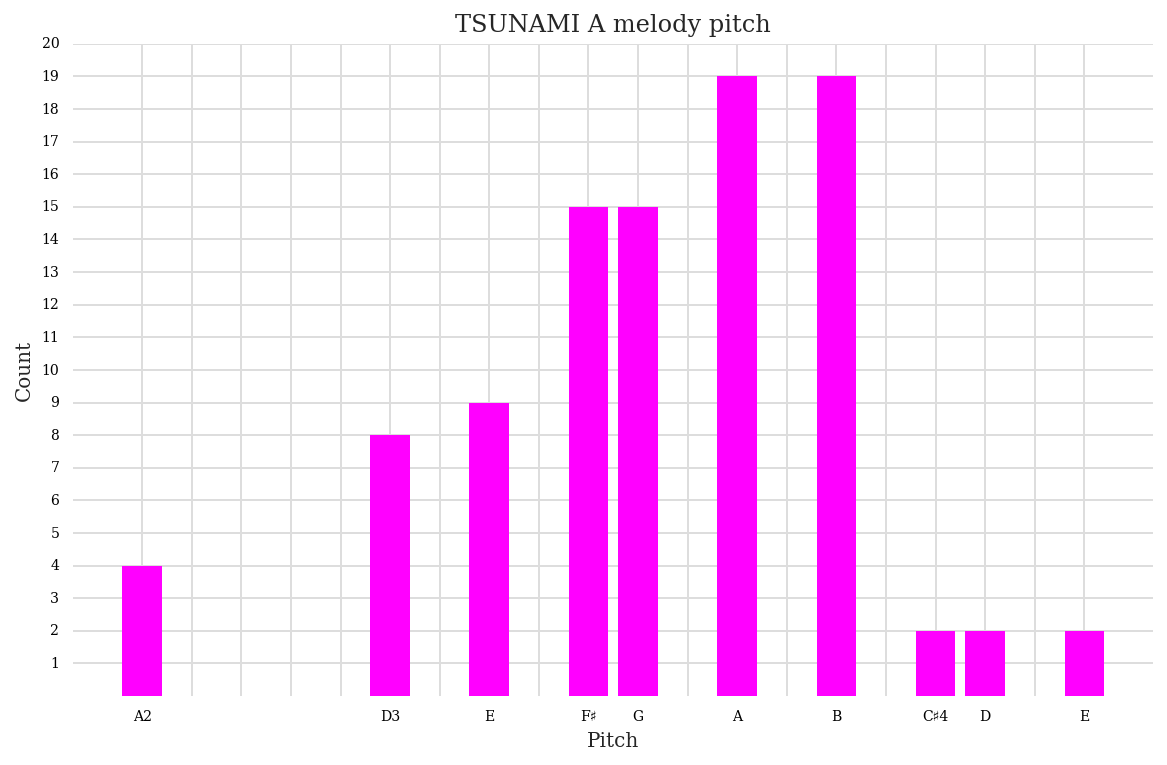

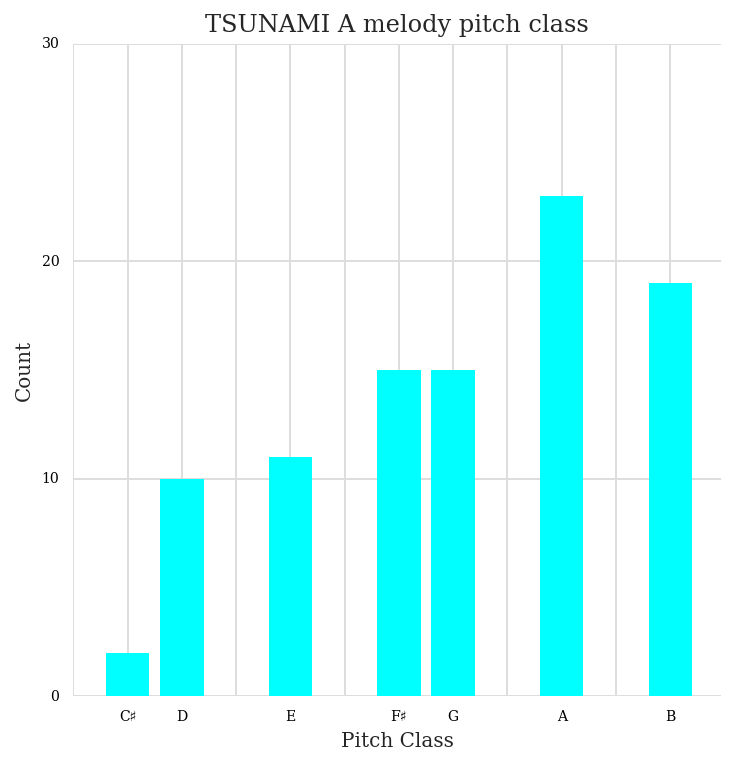

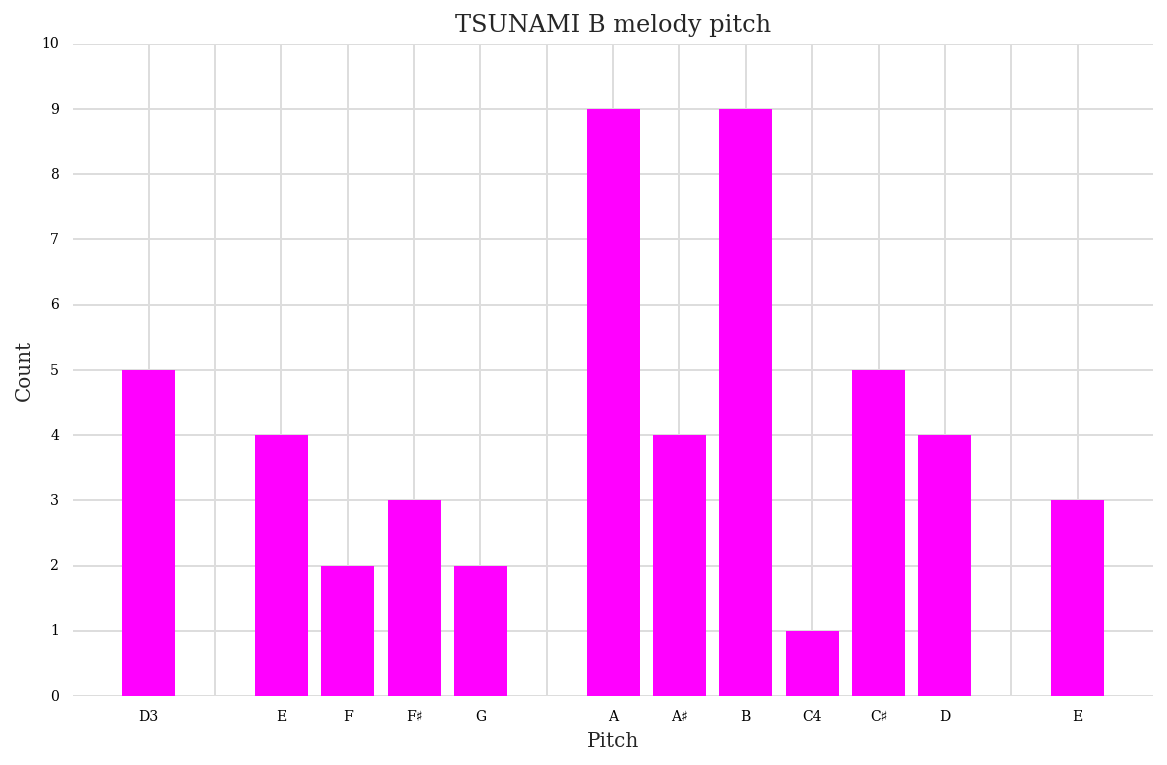

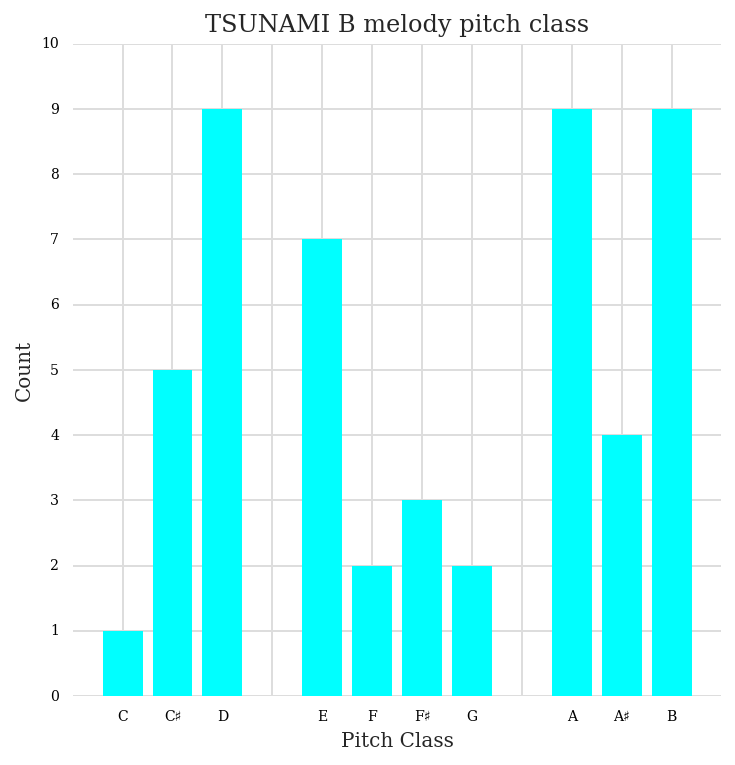

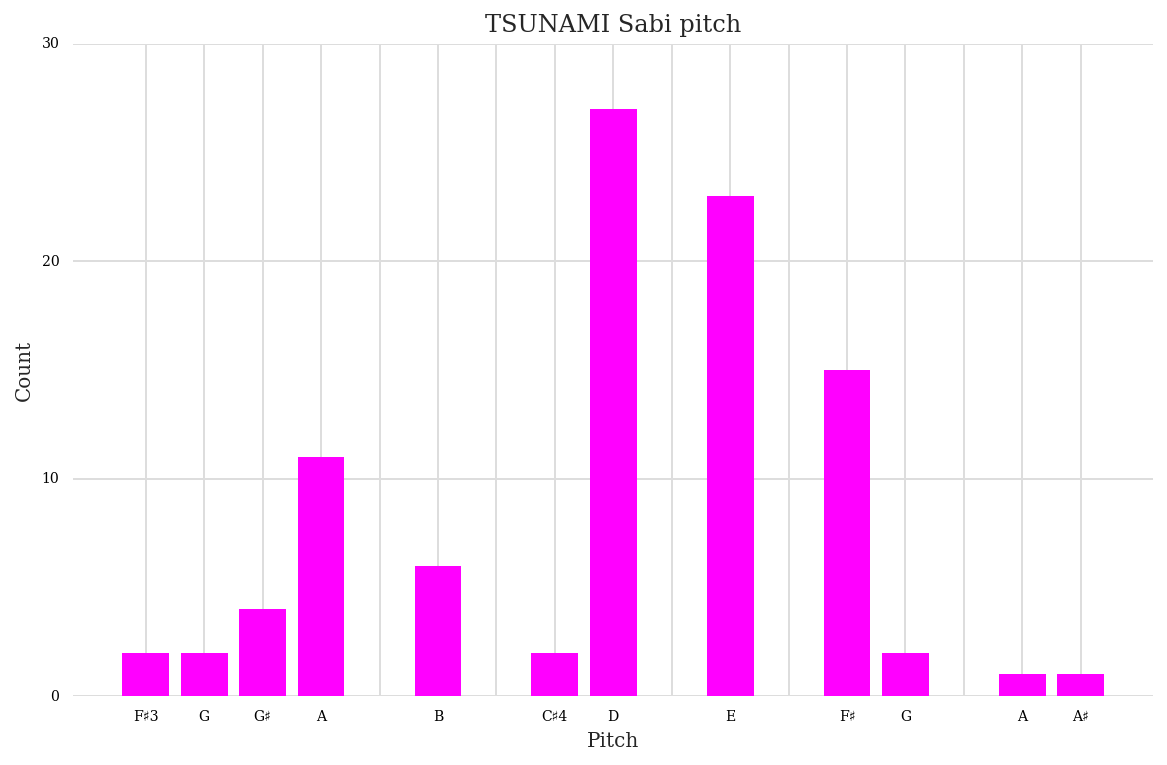

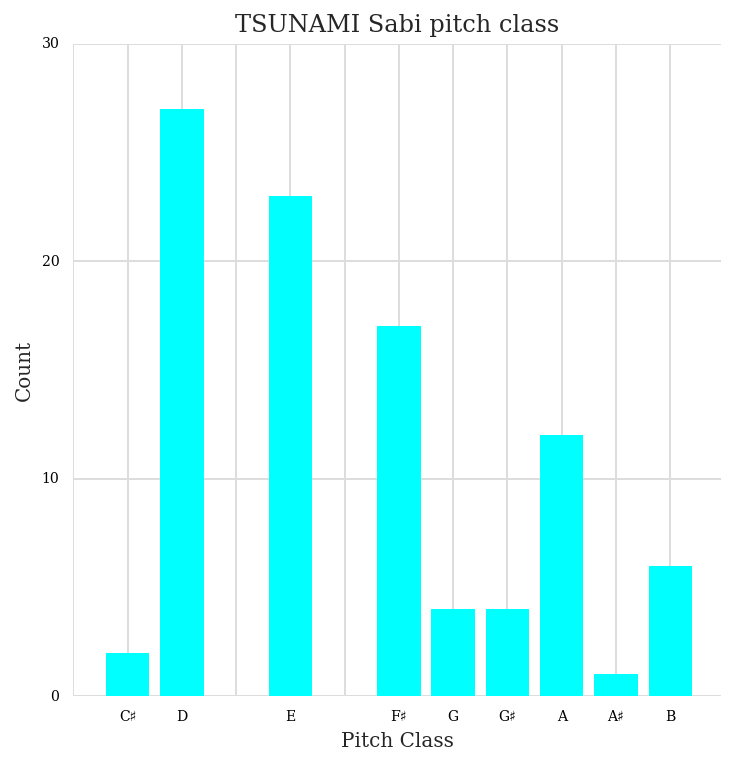

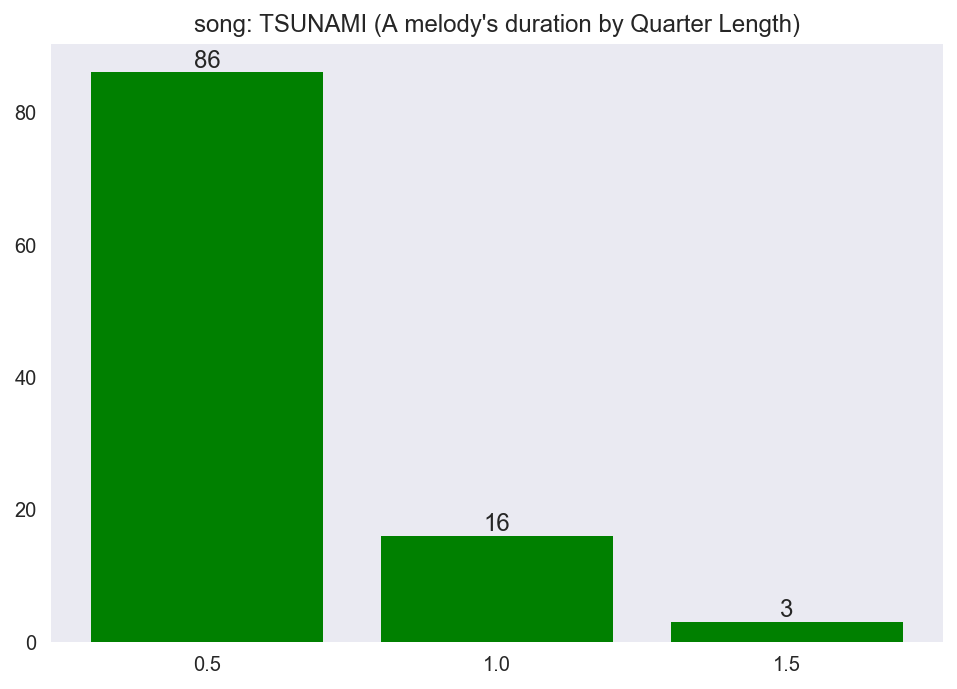

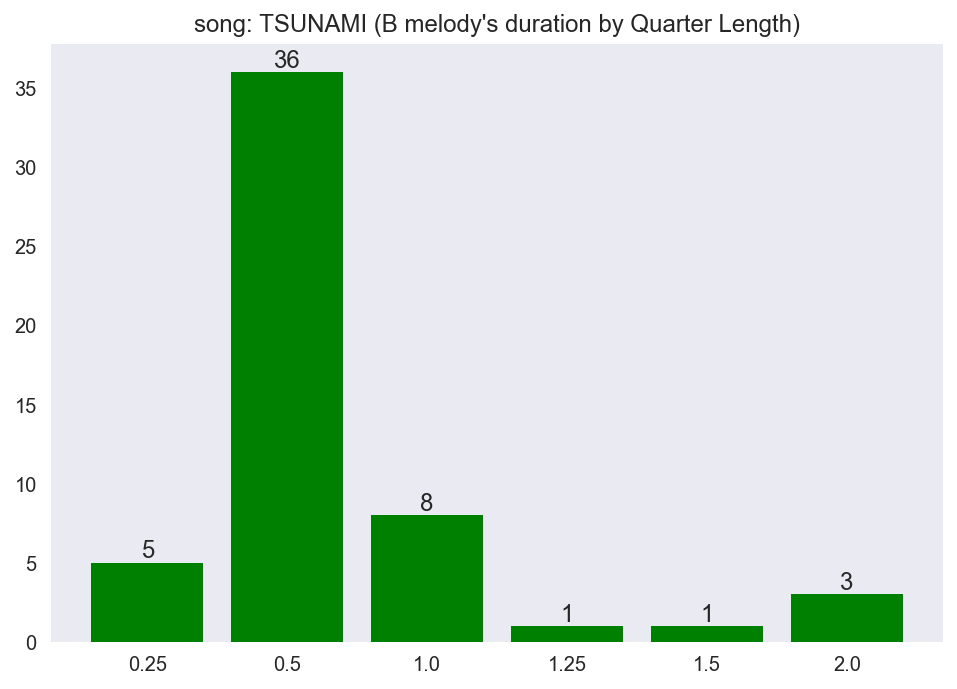

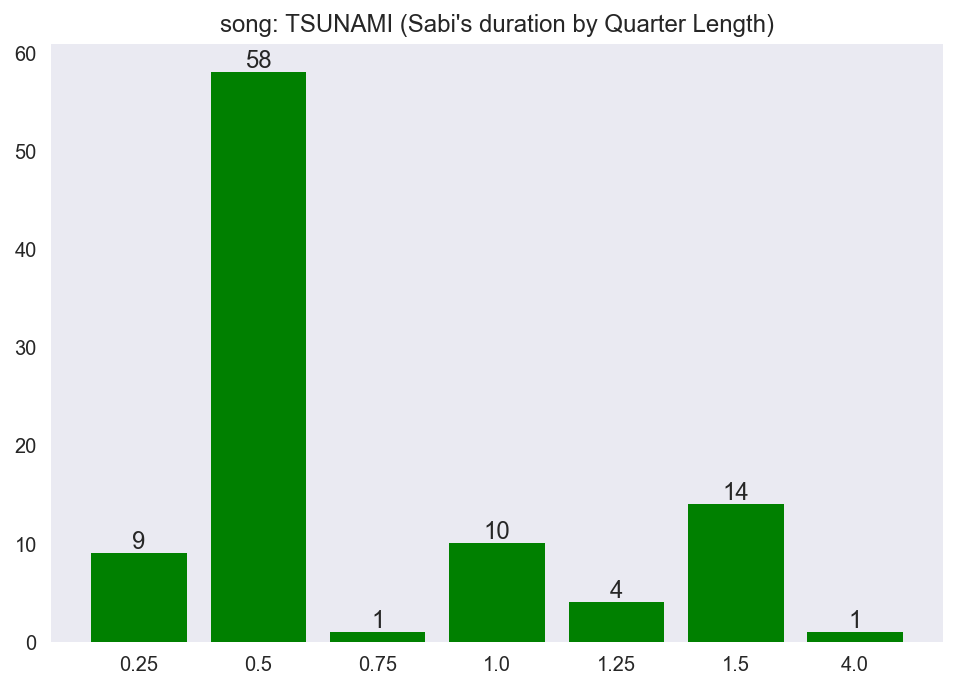

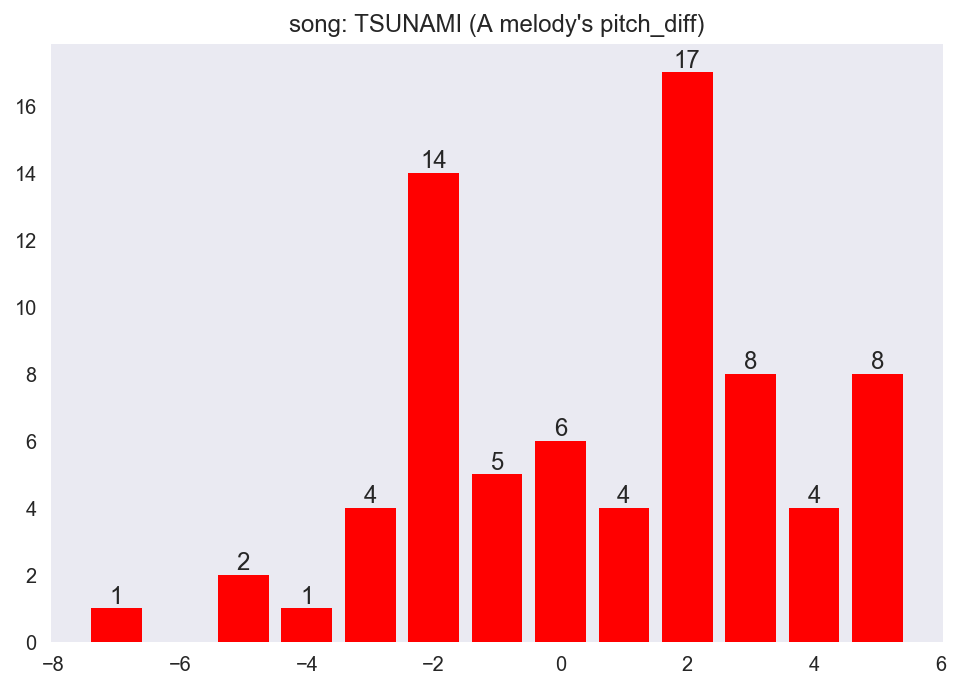

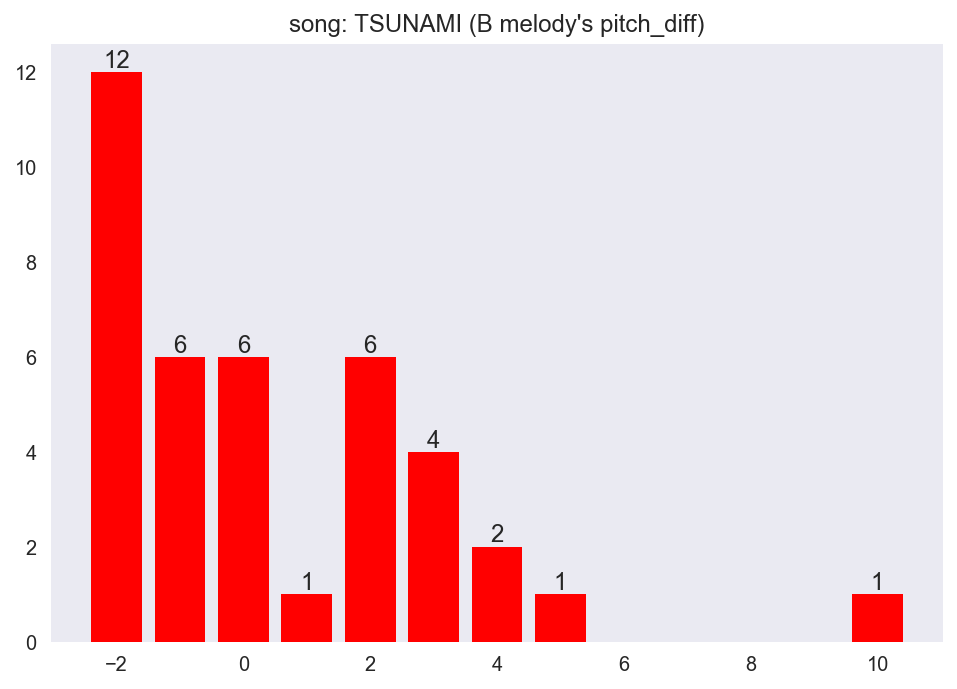

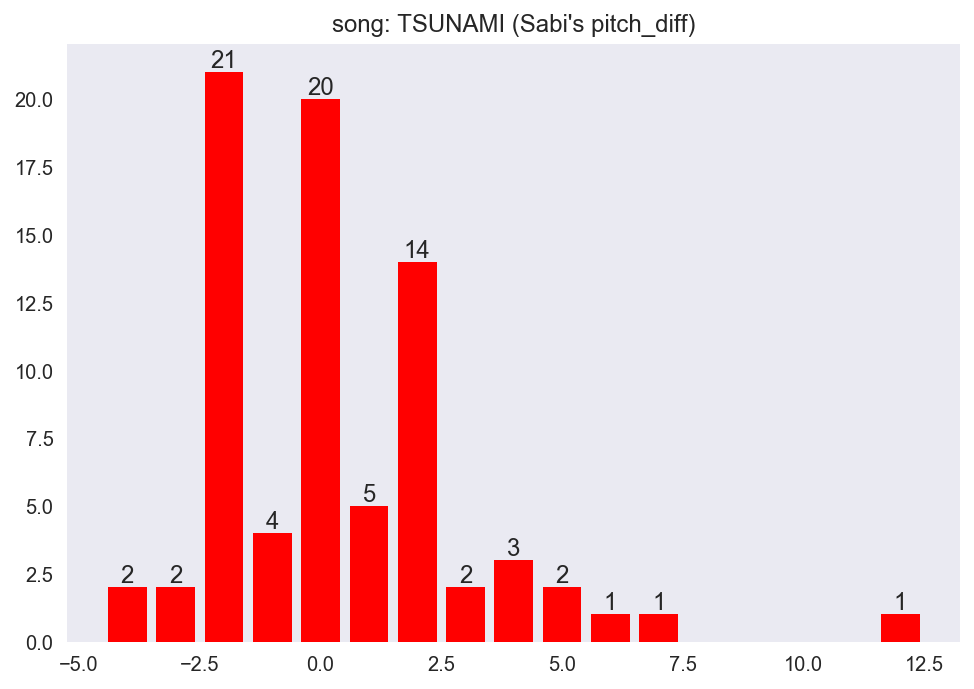

A melodyの跳躍情報　跳躍の割合:0.38,上向跳躍の割合:0.27,下降跳躍の割合:0.11
B melodyの跳躍情報　跳躍の割合:0.21,上向跳躍の割合:0.21,下降跳躍の割合:0.0
Sabiの跳躍情報　跳躍の割合:0.18,上向跳躍の割合:0.13,下降跳躍の割合:0.051
A melodyの音域情報　最低音:A2,最高音:E4,音域:19半音(45-64)
B melodyの音域情報　最低音:D3,最高音:E4,音域:14半音(50-64)
Sabiの音域情報　最低音:F#3,最高音:A#4,音域:16半音(54-70)
TSUNAMI
A melodyの音価難易度4.93
B melodyの音価難易度5.69
Sabiの音価難易度6.57
A melodyのタイの数6
B melodyのタイの数4
Sabiのタイの数8
------------Roman Hikou-------------
-------A melodyの統計情報---------
調:B major
-------B melodyの統計情報---------
調:g# minor
-------Sabiの統計情報---------
調:B major


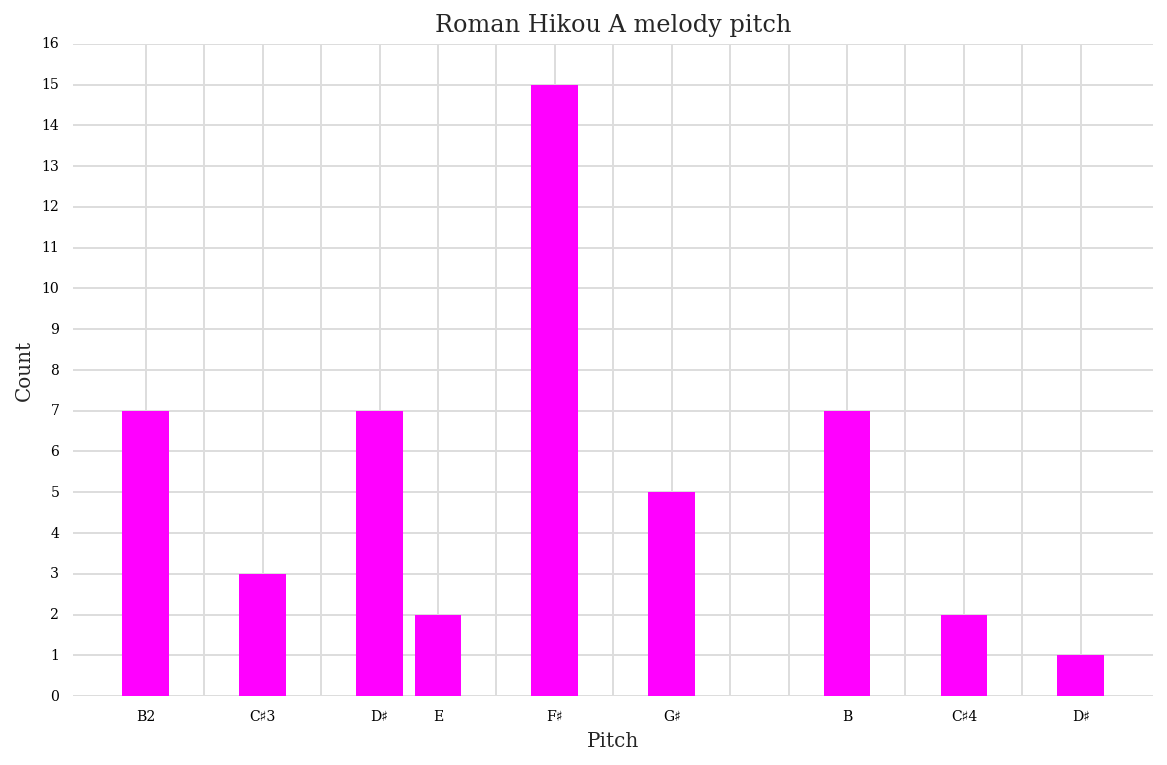

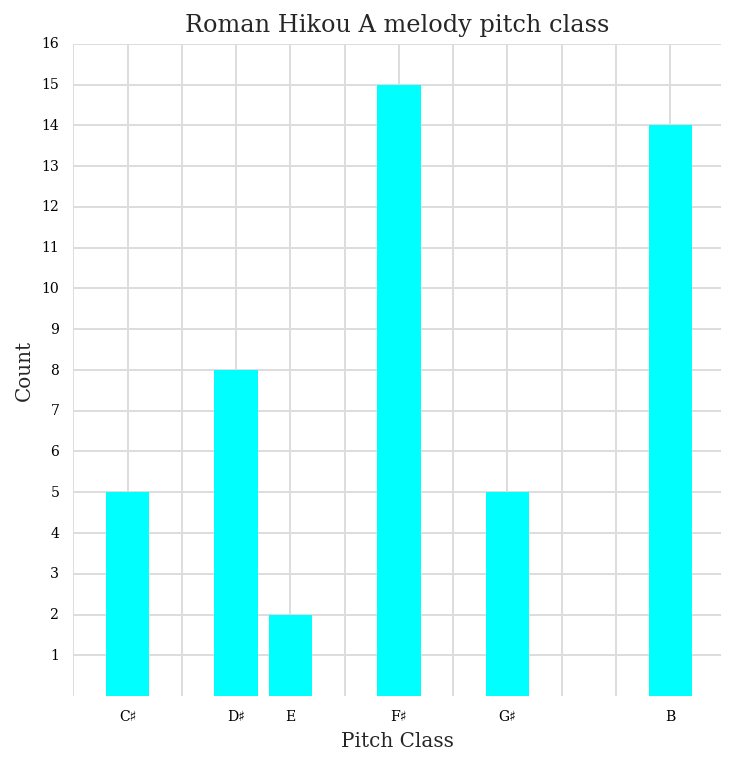

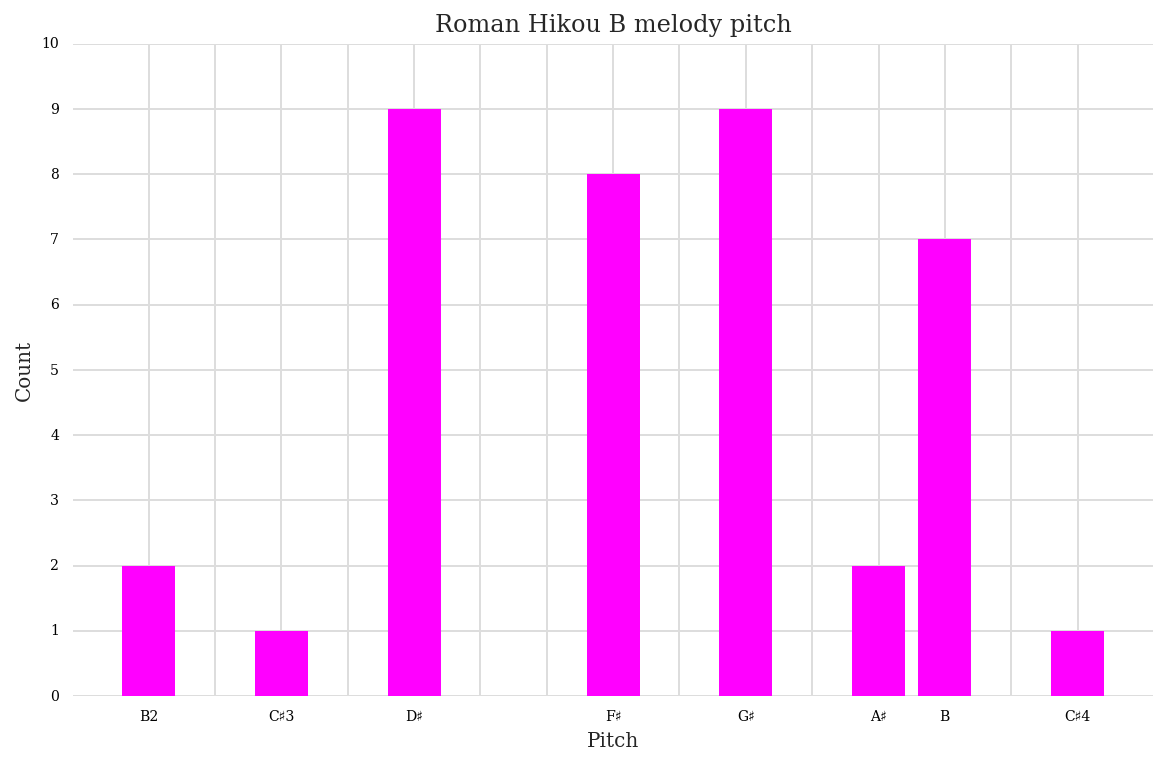

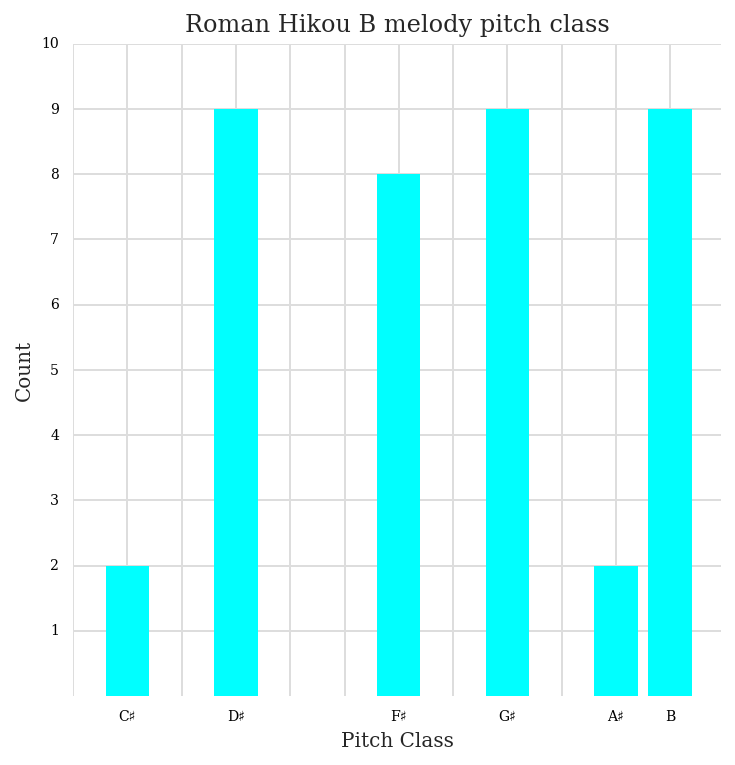

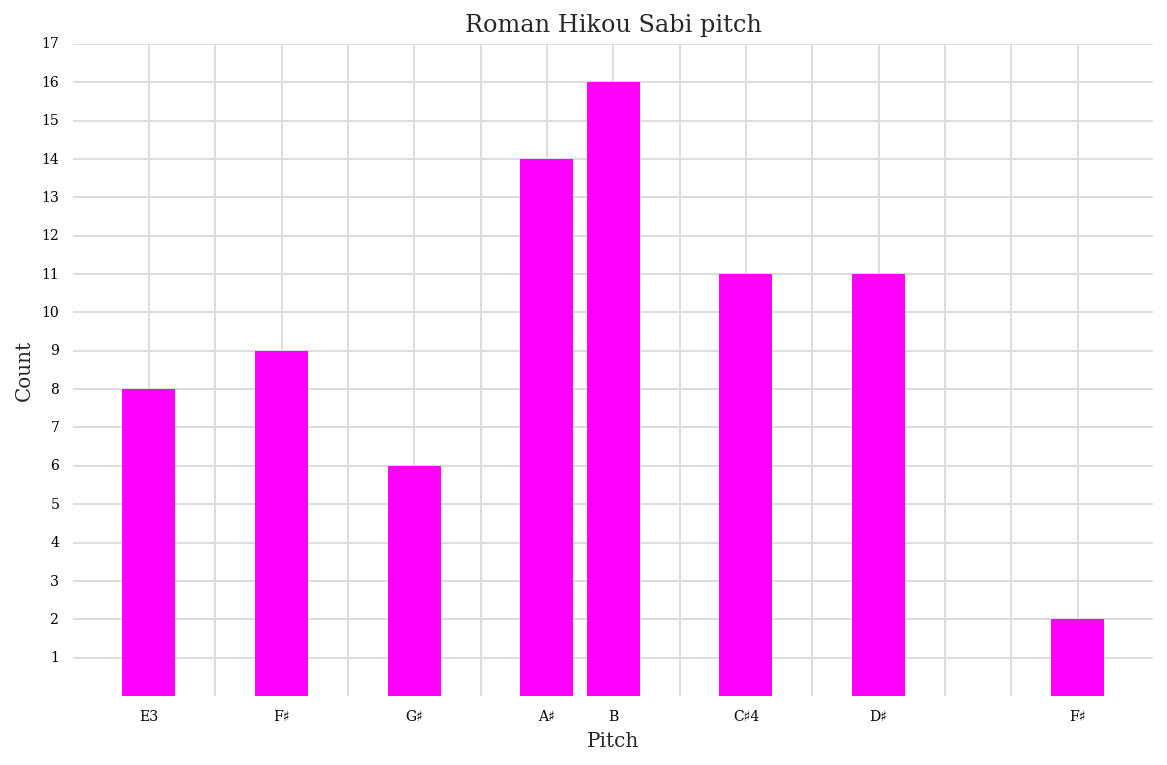

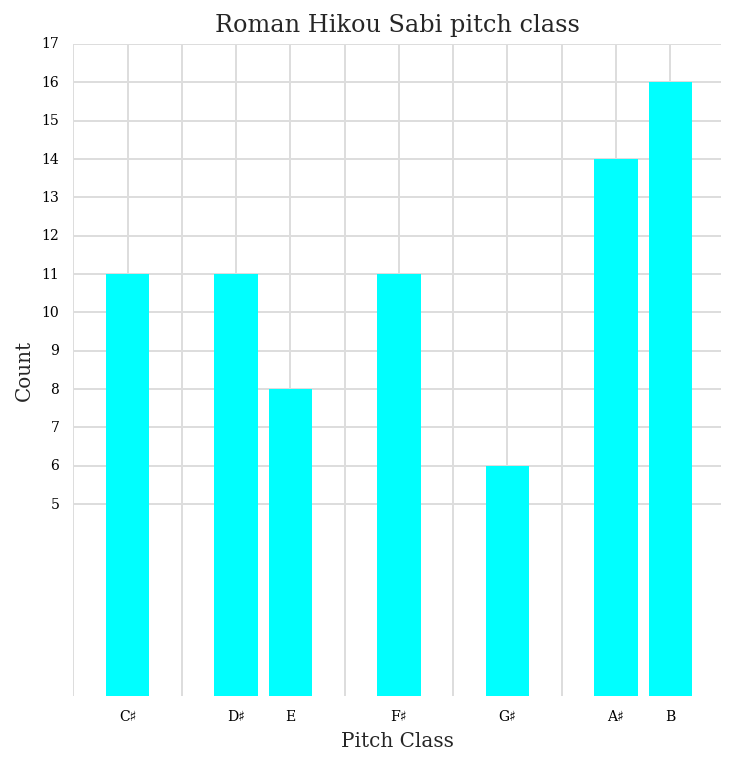

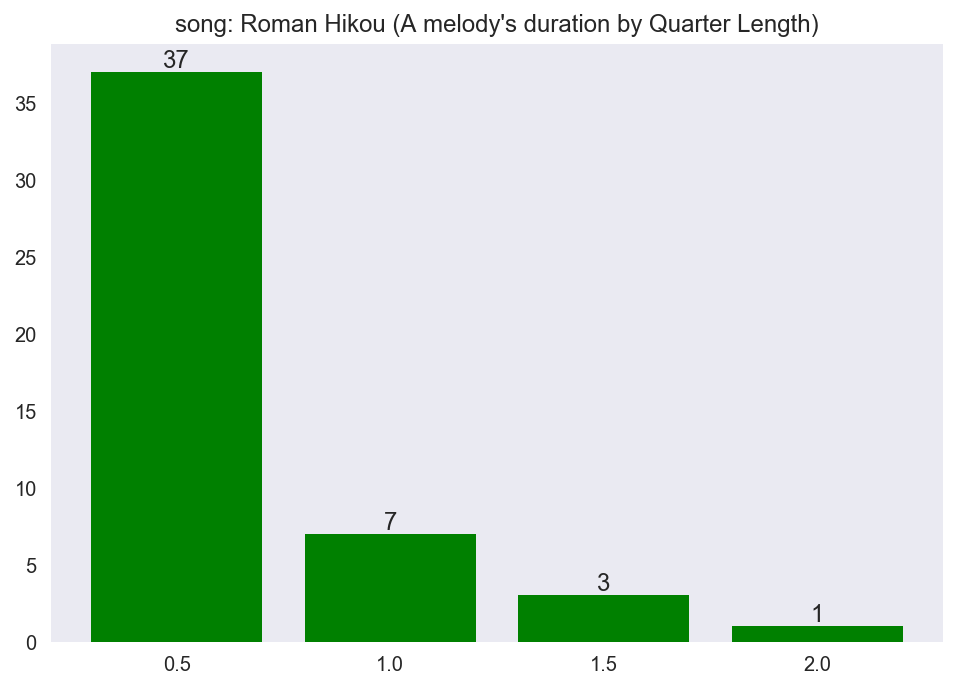

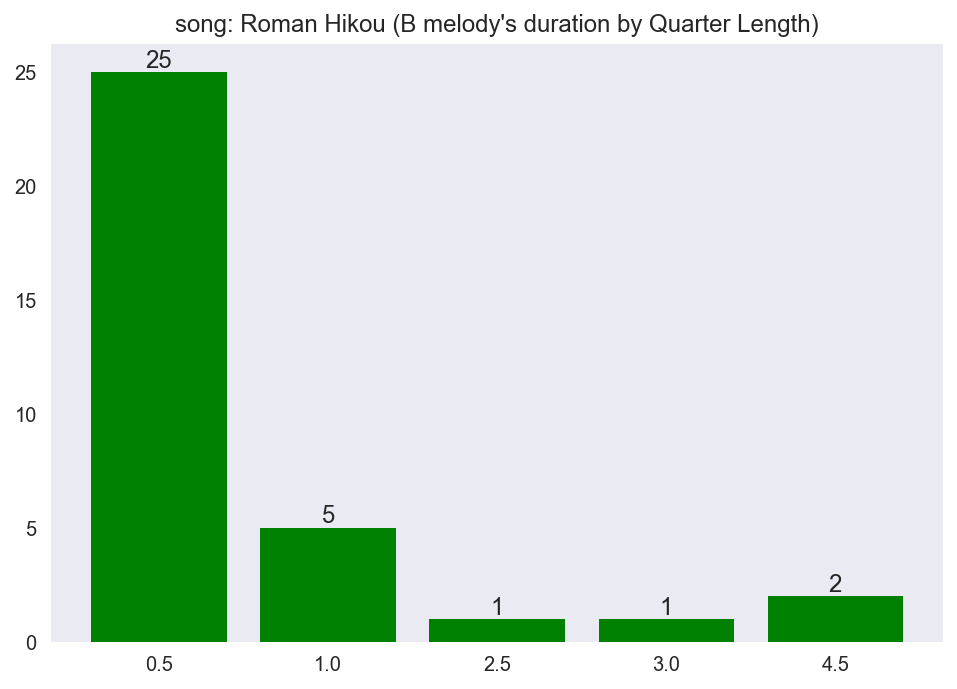

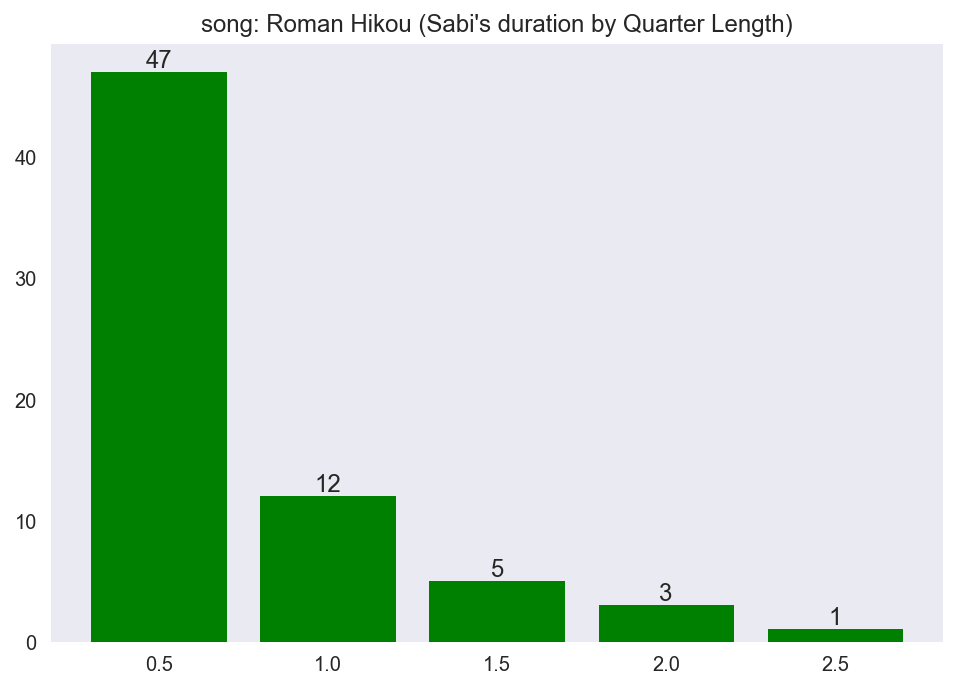

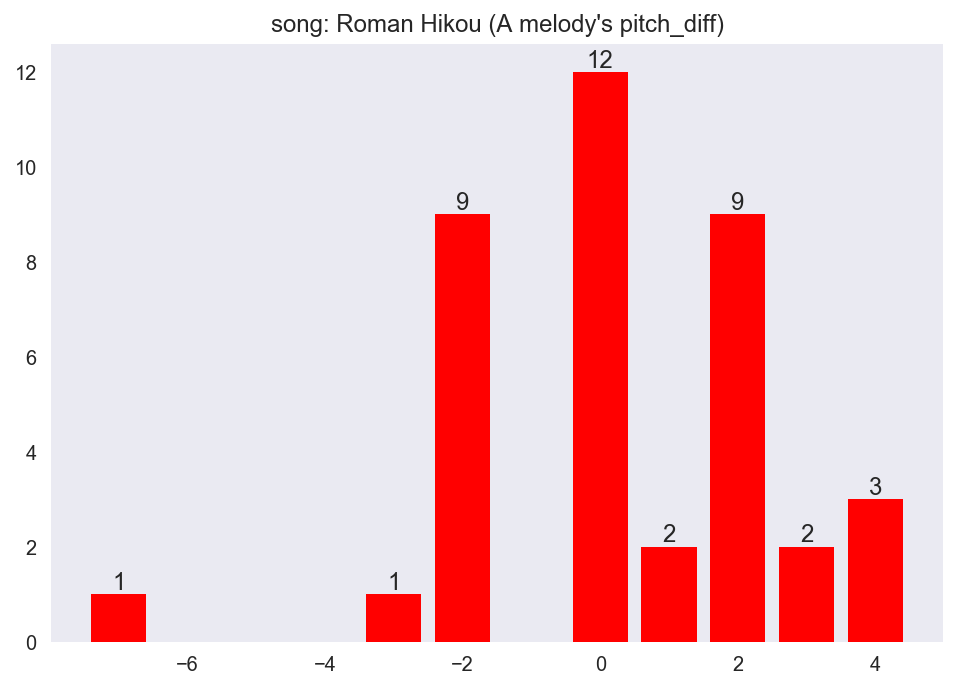

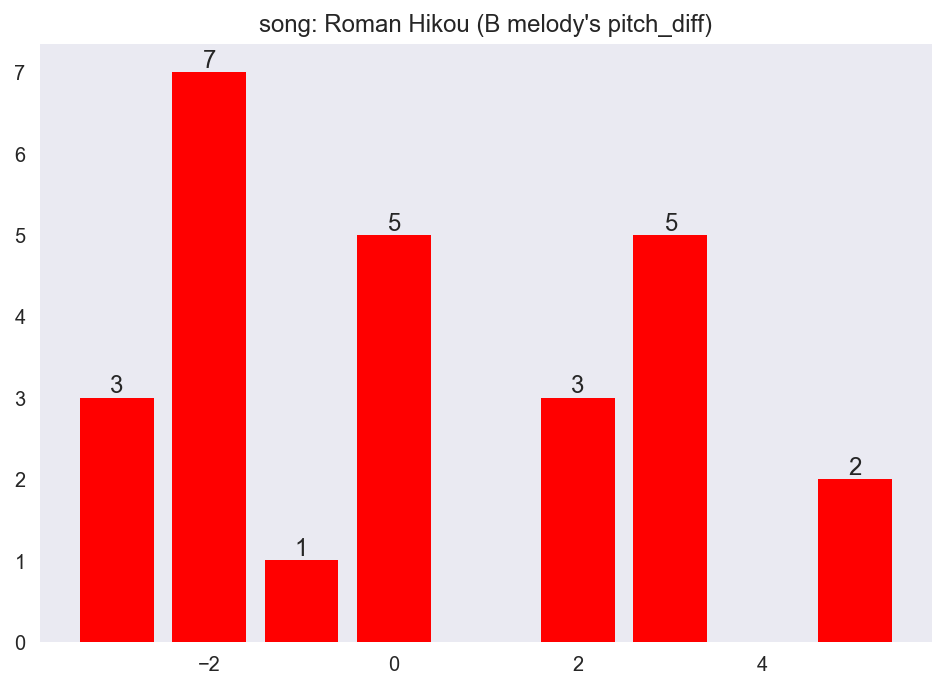

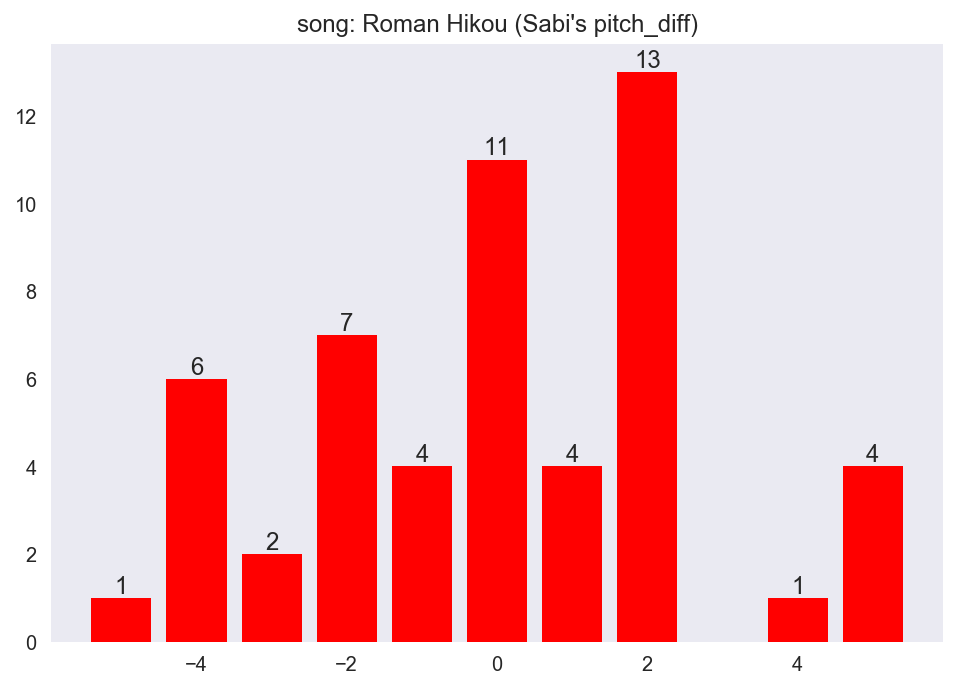

A melodyの跳躍情報　跳躍の割合:0.18,上向跳躍の割合:0.13,下降跳躍の割合:0.051
B melodyの跳躍情報　跳躍の割合:0.38,上向跳躍の割合:0.27,下降跳躍の割合:0.12
Sabiの跳躍情報　跳躍の割合:0.26,上向跳躍の割合:0.094,下降跳躍の割合:0.17
A melodyの音域情報　最低音:B2,最高音:D#4,音域:16半音(47-63)
B melodyの音域情報　最低音:B2,最高音:C#4,音域:14半音(47-61)
Sabiの音域情報　最低音:E3,最高音:F#4,音域:14半音(52-66)
Roman Hikou
A melodyの音価難易度4.33
B melodyの音価難易度3.83
Sabiの音価難易度4.63
A melodyのタイの数6
B melodyのタイの数7
Sabiのタイの数13
------------Aporo-------------
-------A melodyの統計情報---------
調:e minor
-------B melodyの統計情報---------
調:e minor
-------Sabiの統計情報---------
調:e minor


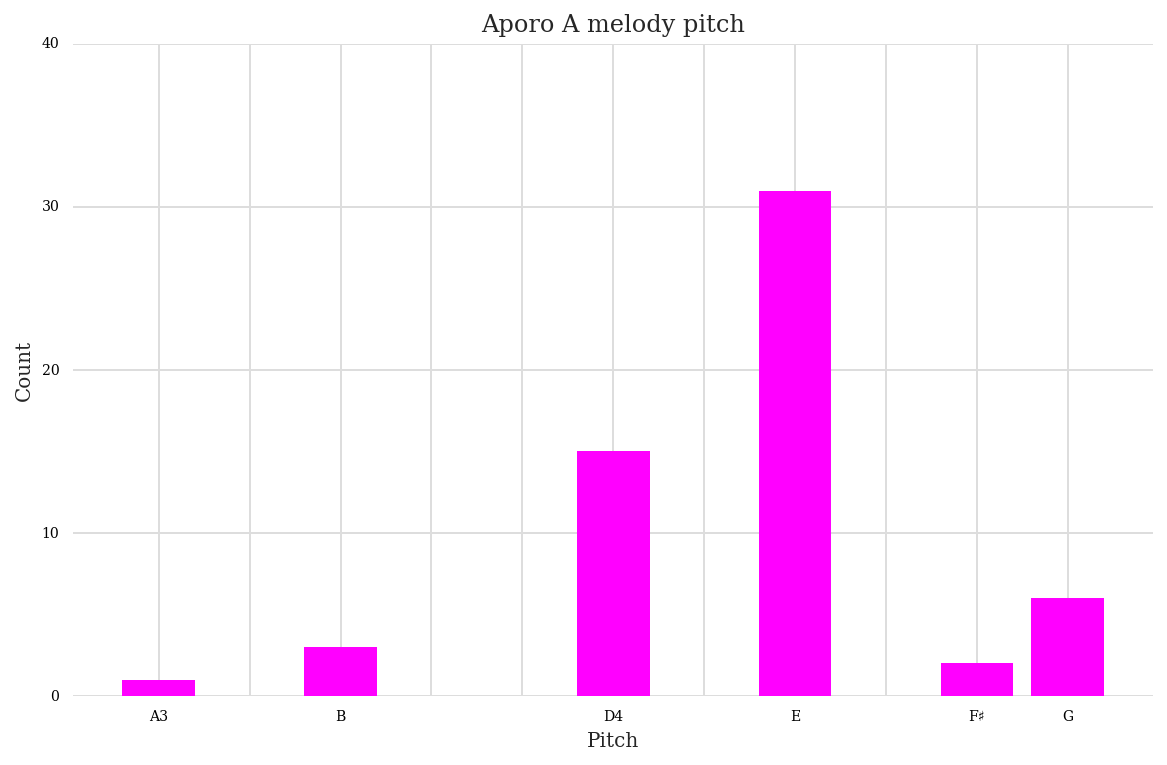

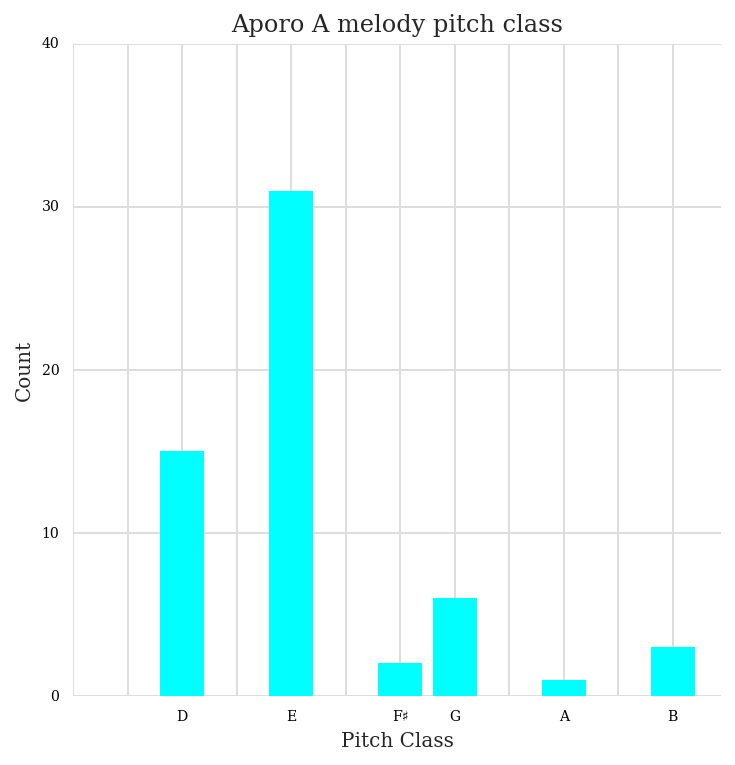

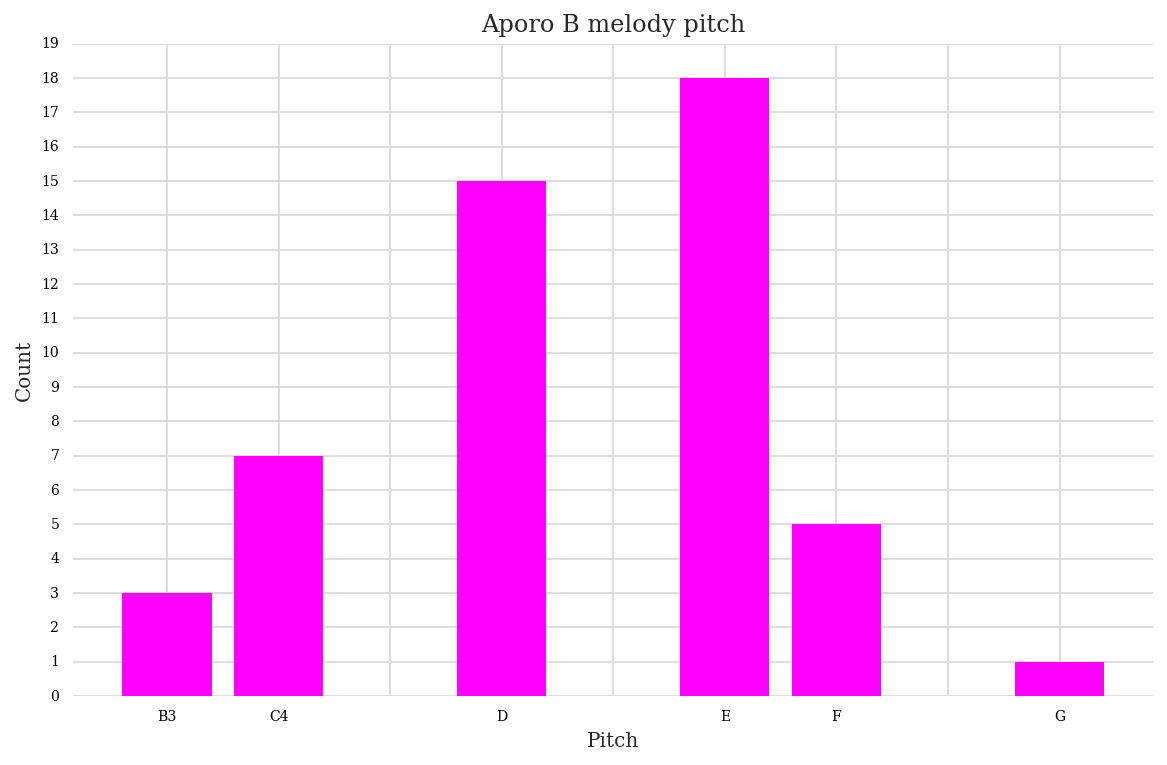

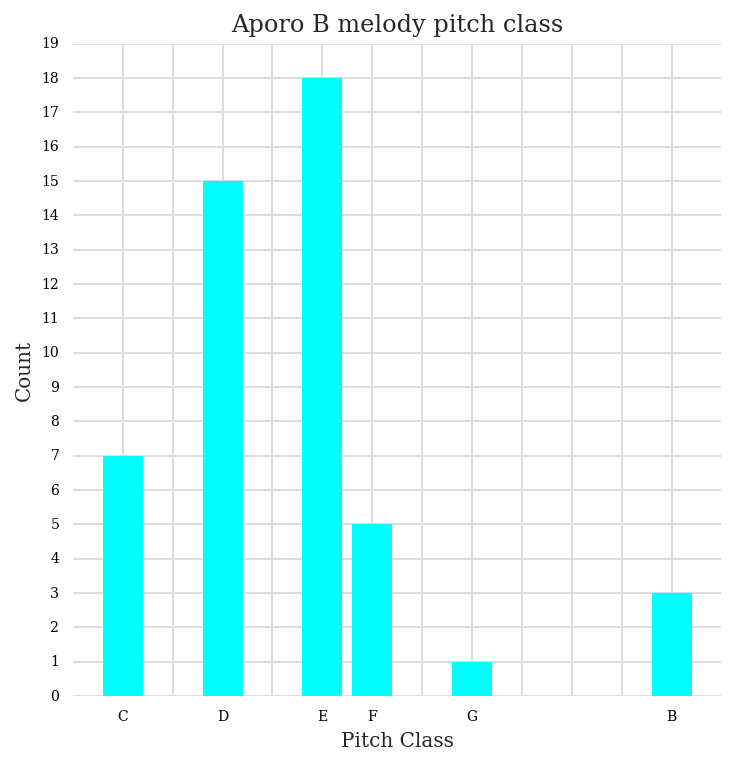

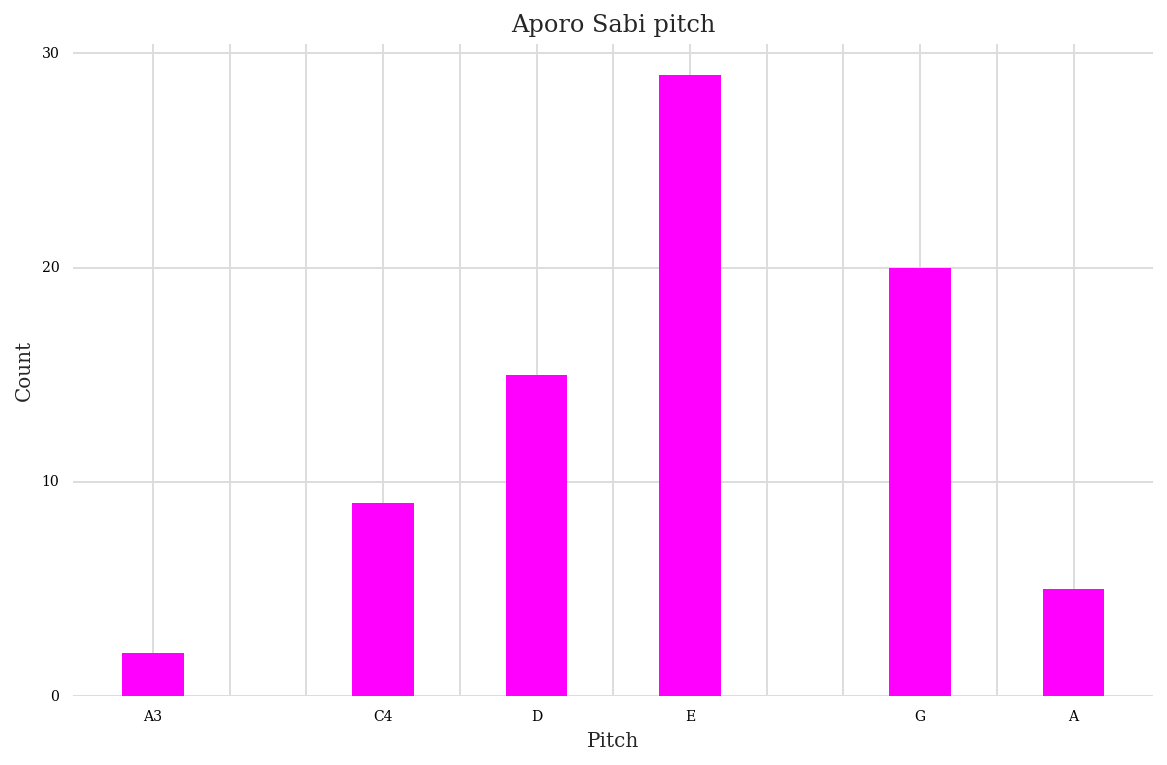

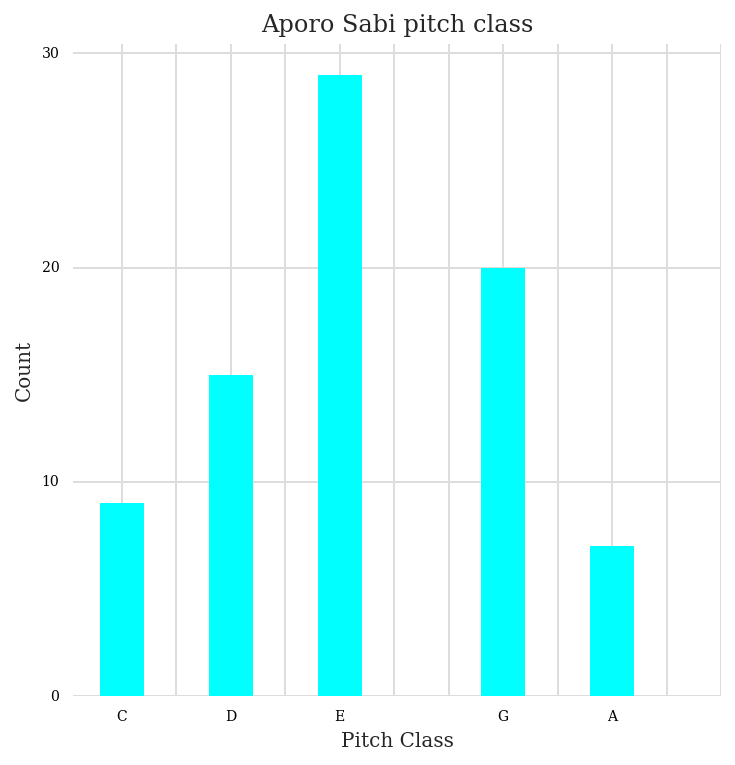

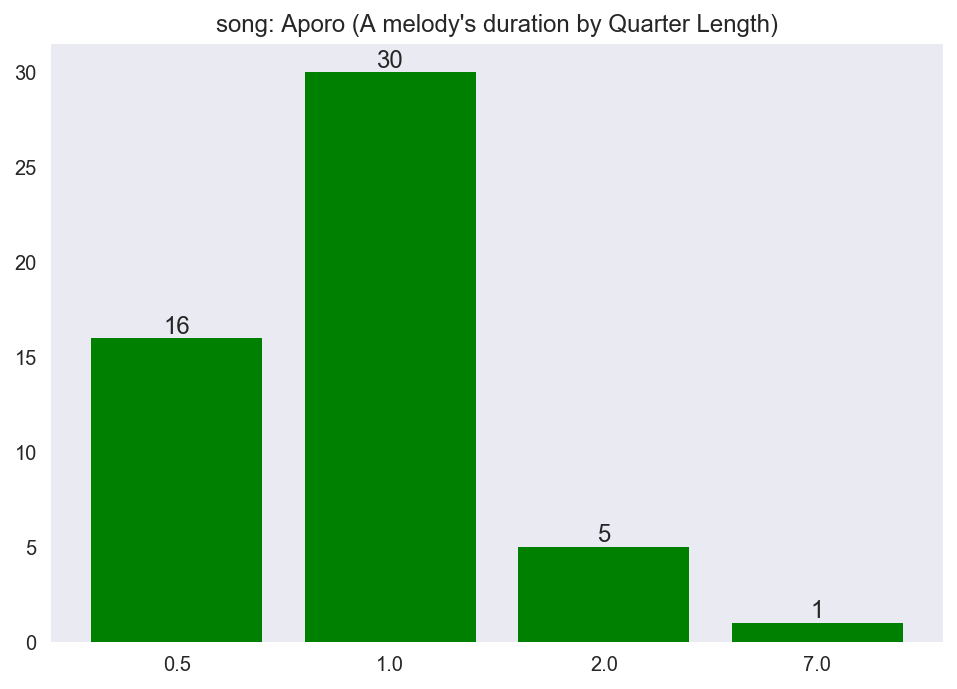

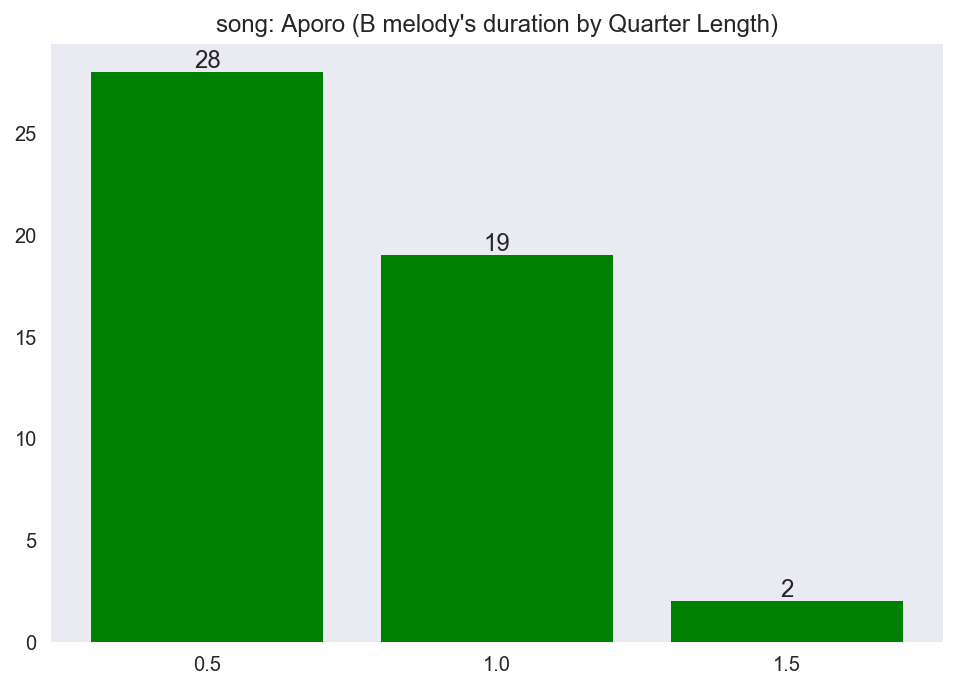

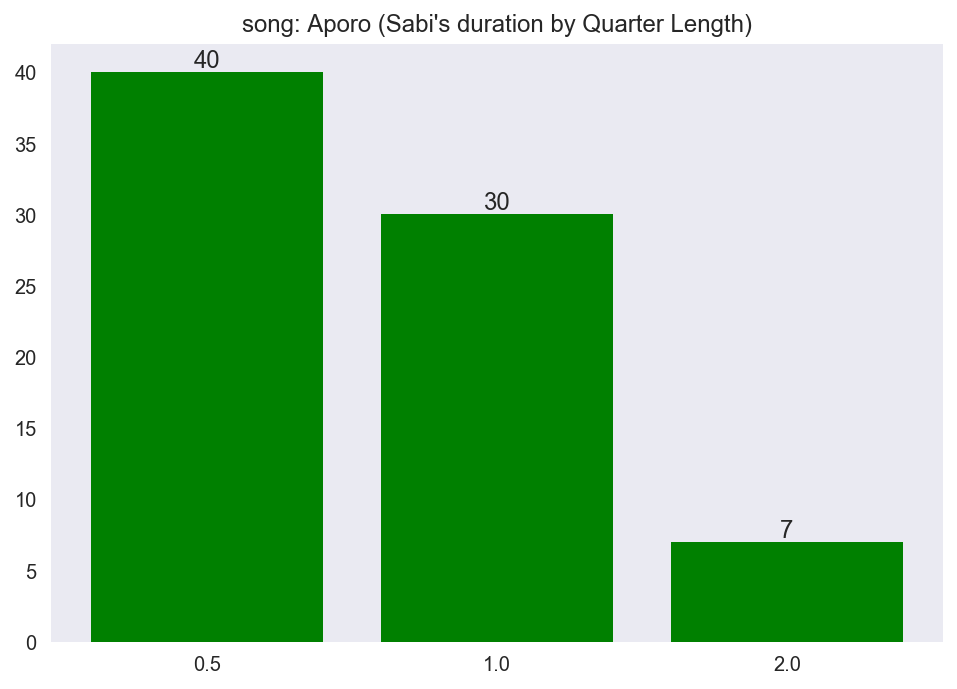

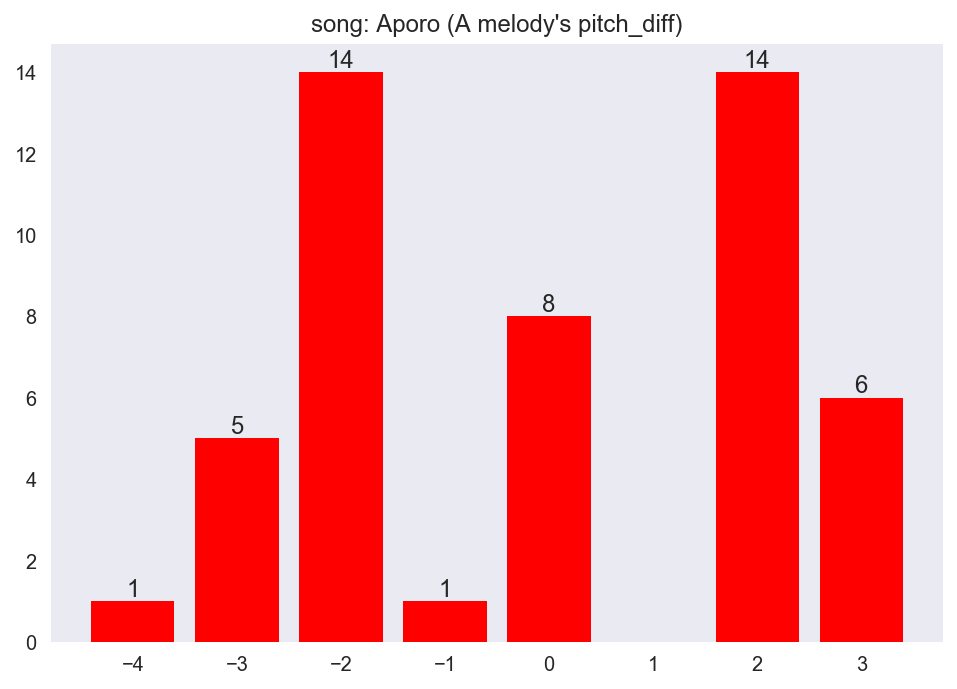

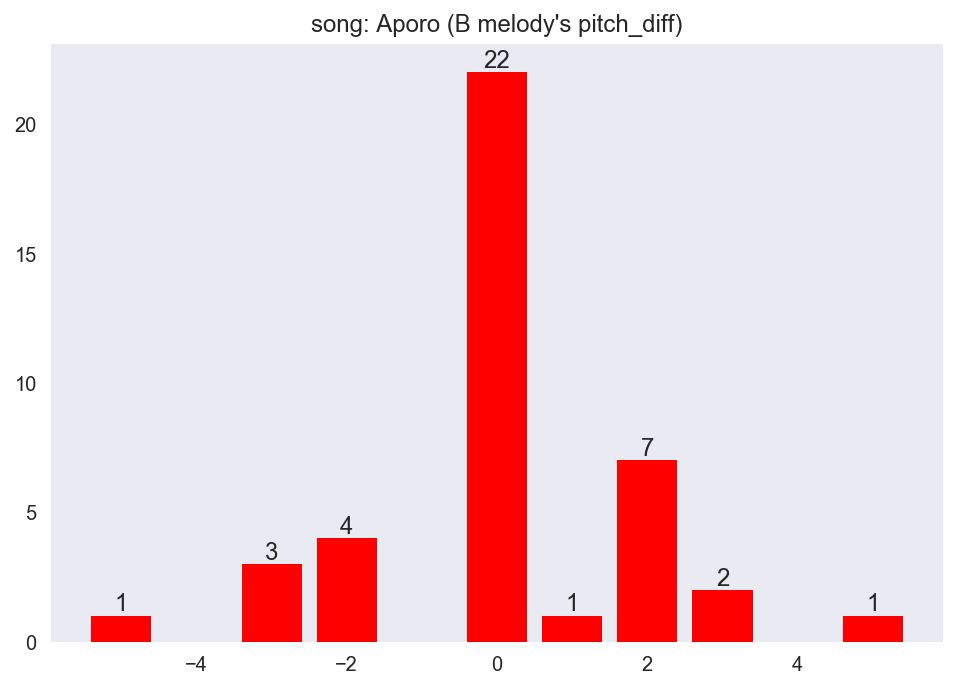

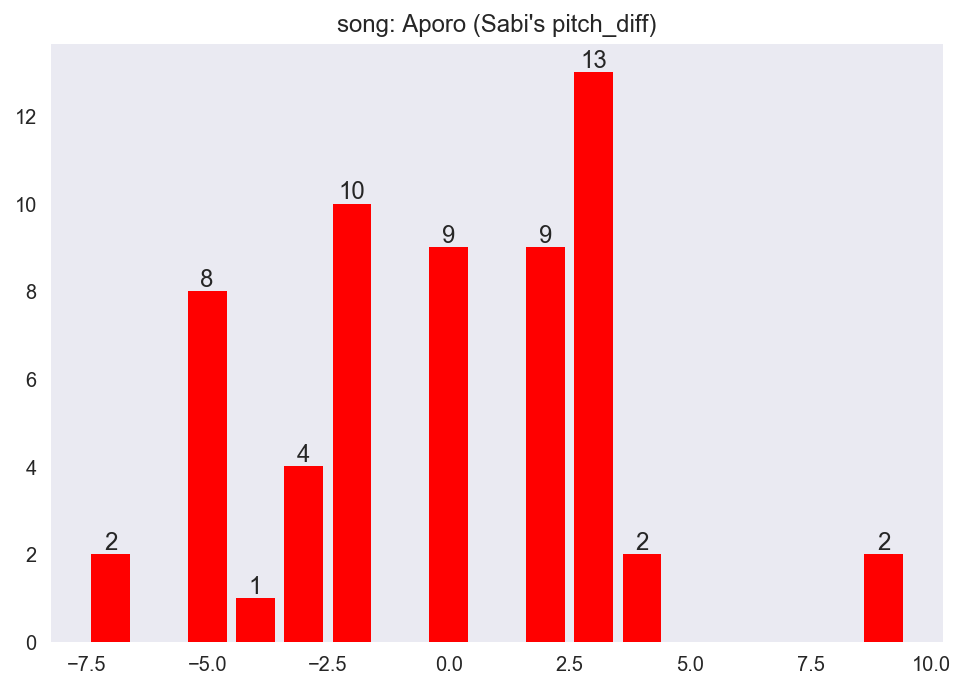

A melodyの跳躍情報　跳躍の割合:0.24,上向跳躍の割合:0.12,下降跳躍の割合:0.12
B melodyの跳躍情報　跳躍の割合:0.17,上向跳躍の割合:0.073,下降跳躍の割合:0.098
Sabiの跳躍情報　跳躍の割合:0.53,上向跳躍の割合:0.28,下降跳躍の割合:0.25
A melodyの音域情報　最低音:A3,最高音:G4,音域:10半音(57-67)
B melodyの音域情報　最低音:B3,最高音:G4,音域:8半音(59-67)
Sabiの音域情報　最低音:A3,最高音:A4,音域:12半音(57-69)
Aporo
A melodyの音価難易度5.88
B melodyの音価難易度4.33
Sabiの音価難易度3.87
A melodyのタイの数6
B melodyのタイの数4
Sabiのタイの数11
------------Guren No Yumiya-------------
-------A melodyの統計情報---------
調:F# major
-------B melodyの統計情報---------
調:C# major
-------Sabiの統計情報---------
調:c# minor


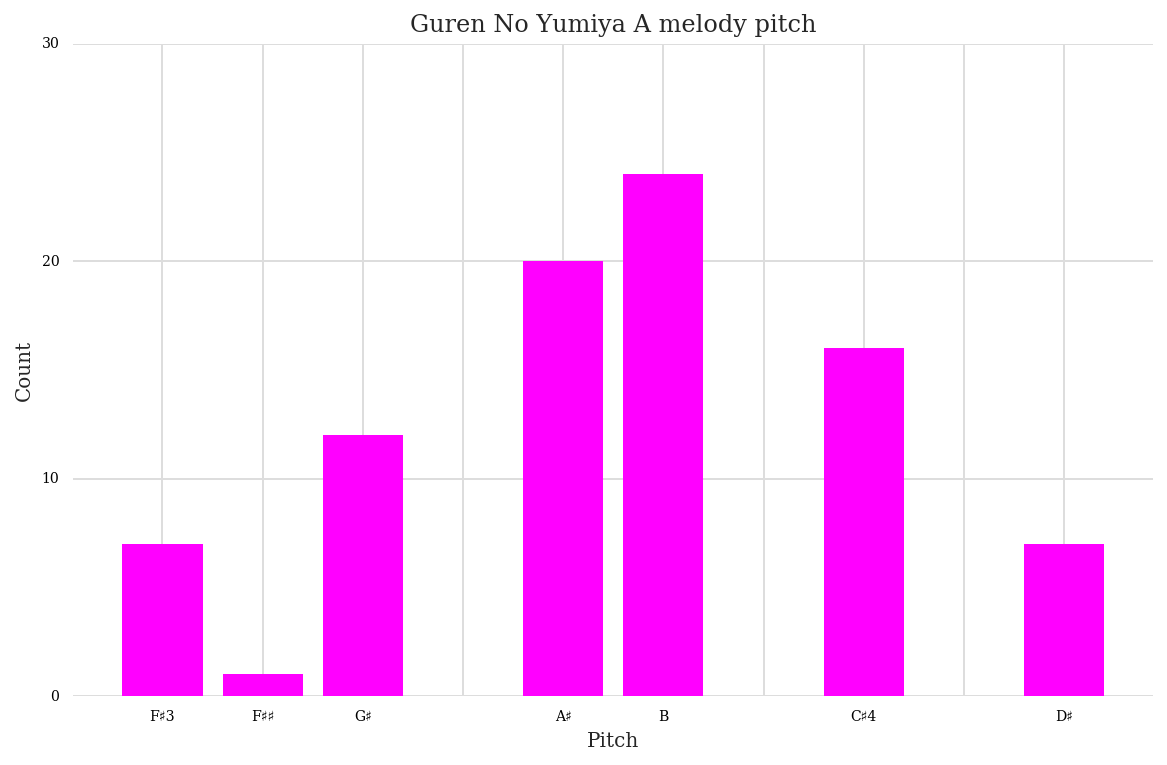

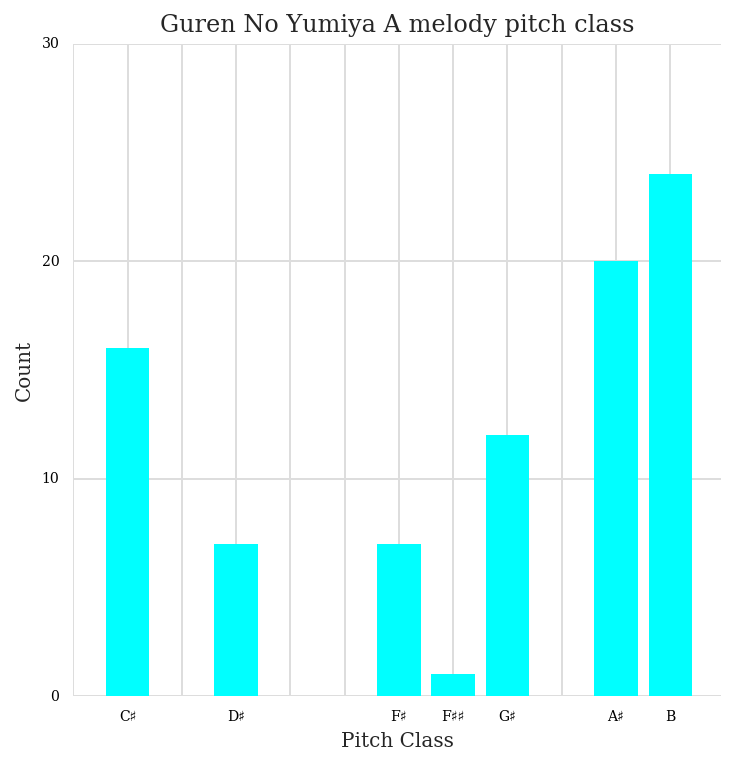

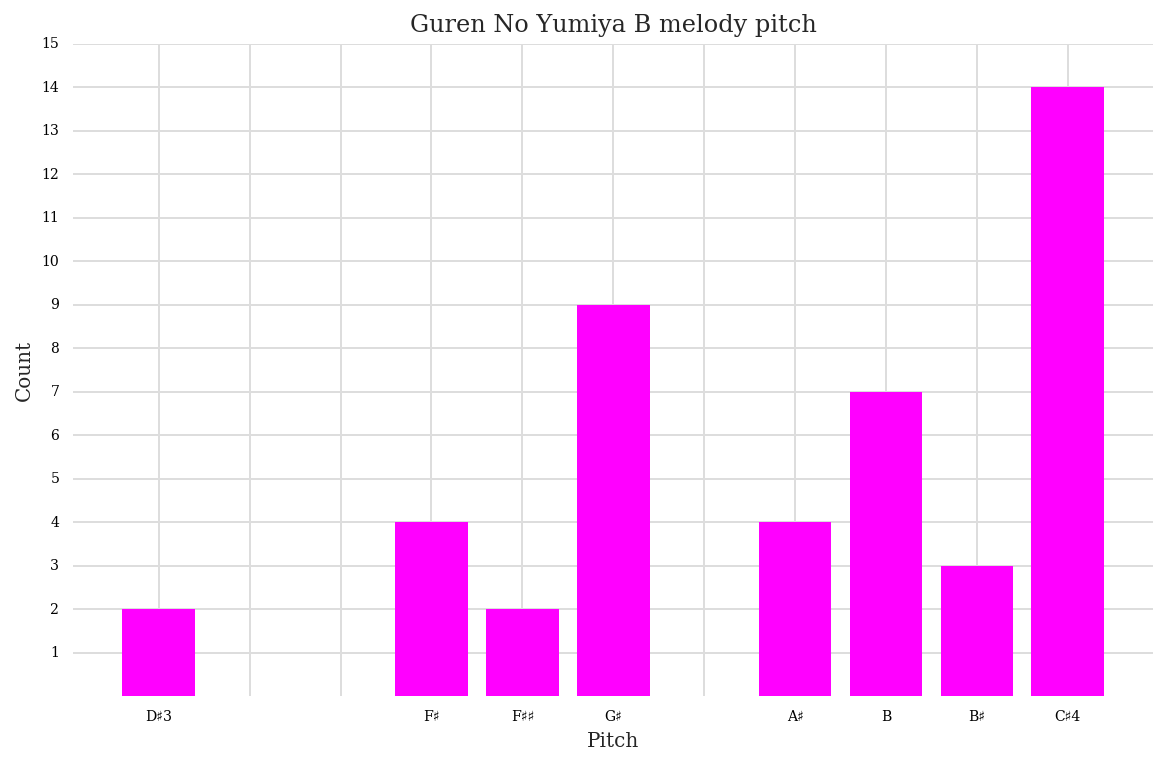

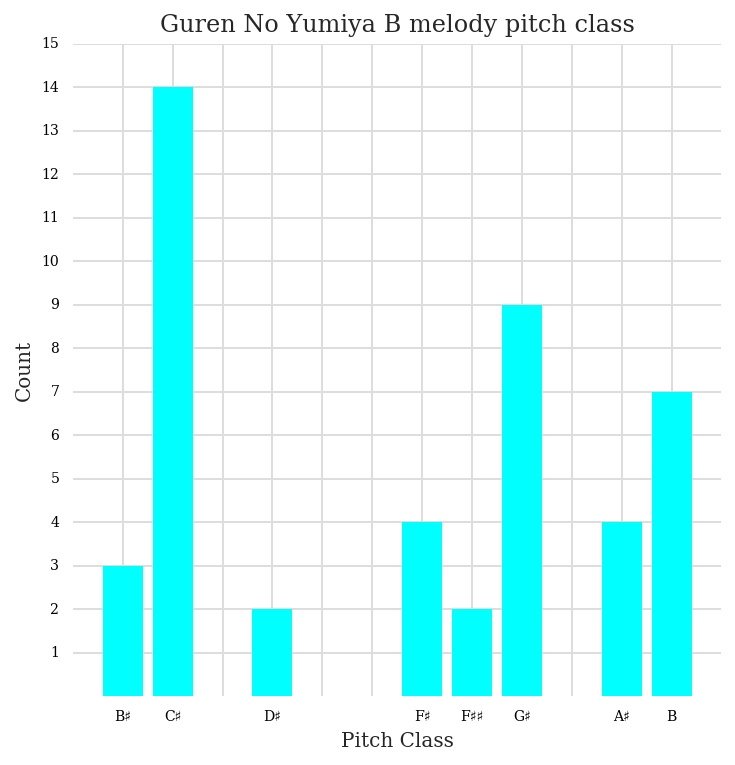

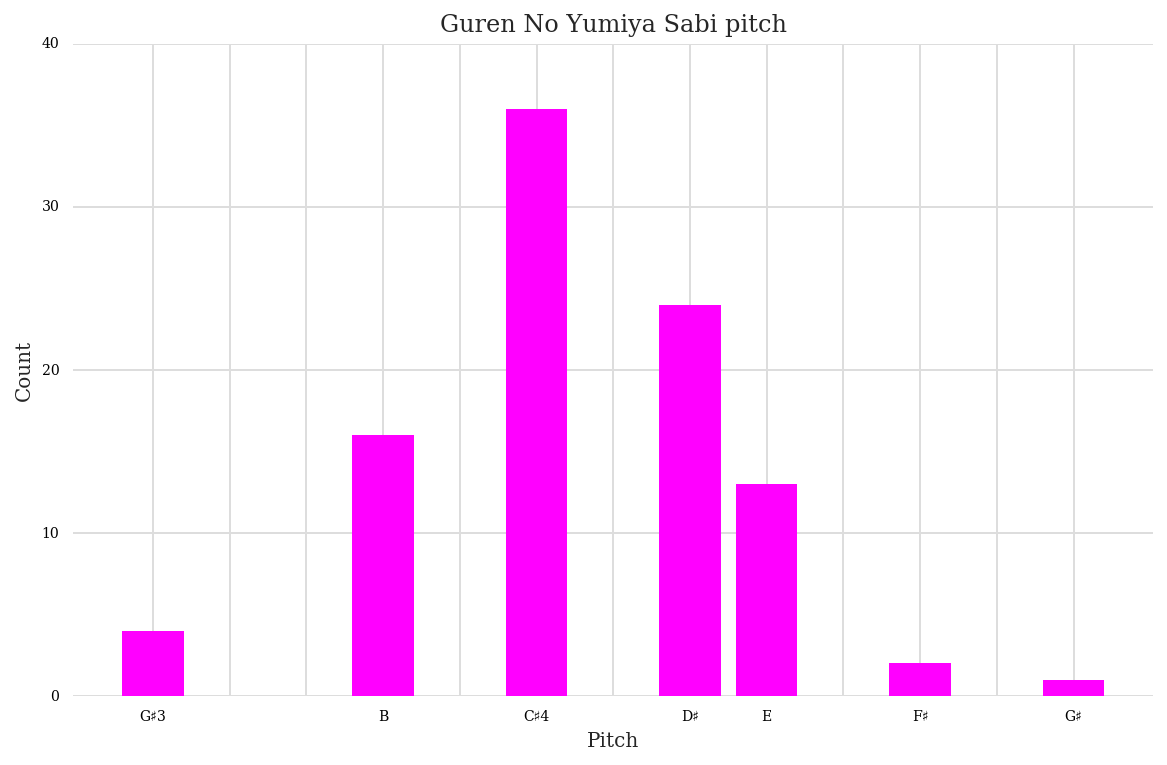

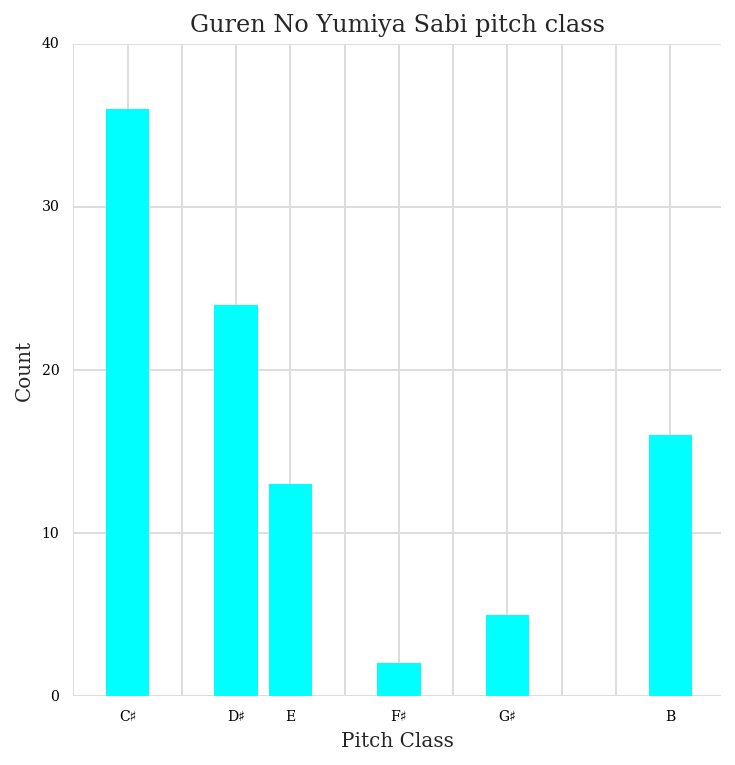

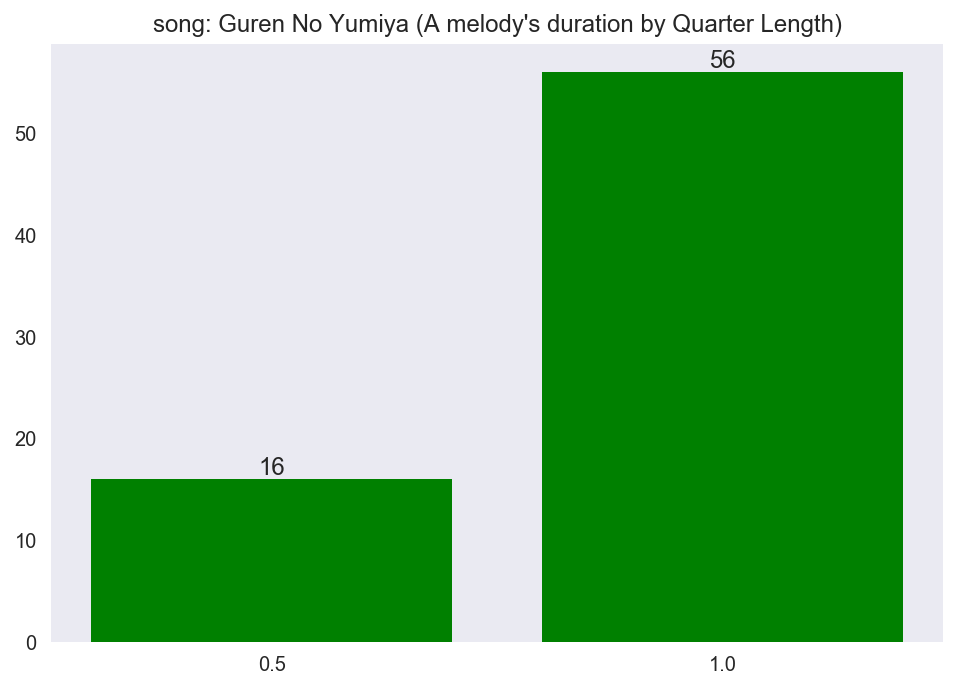

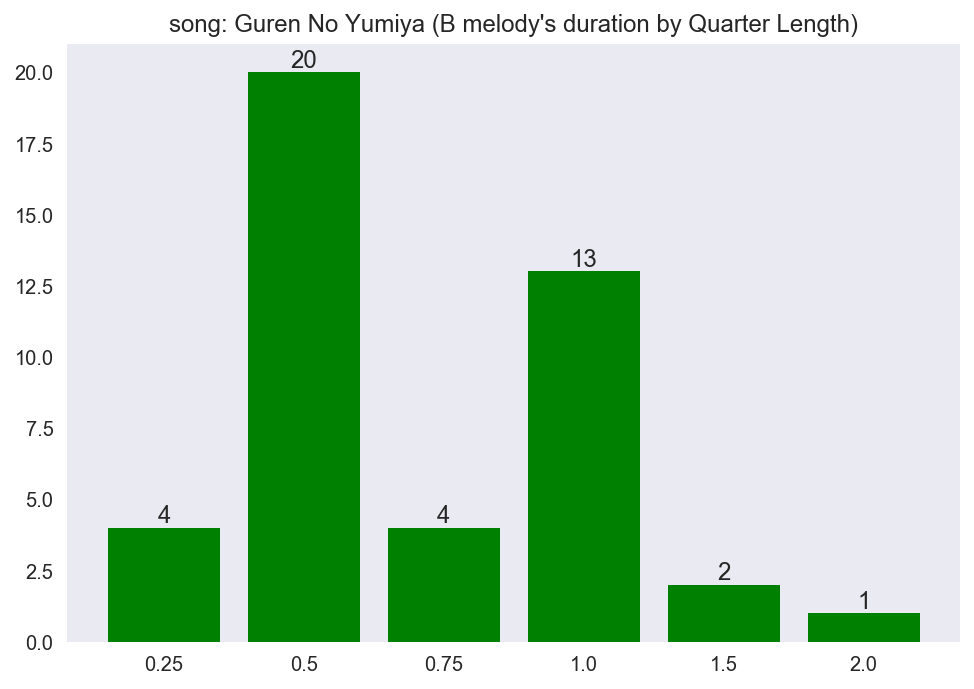

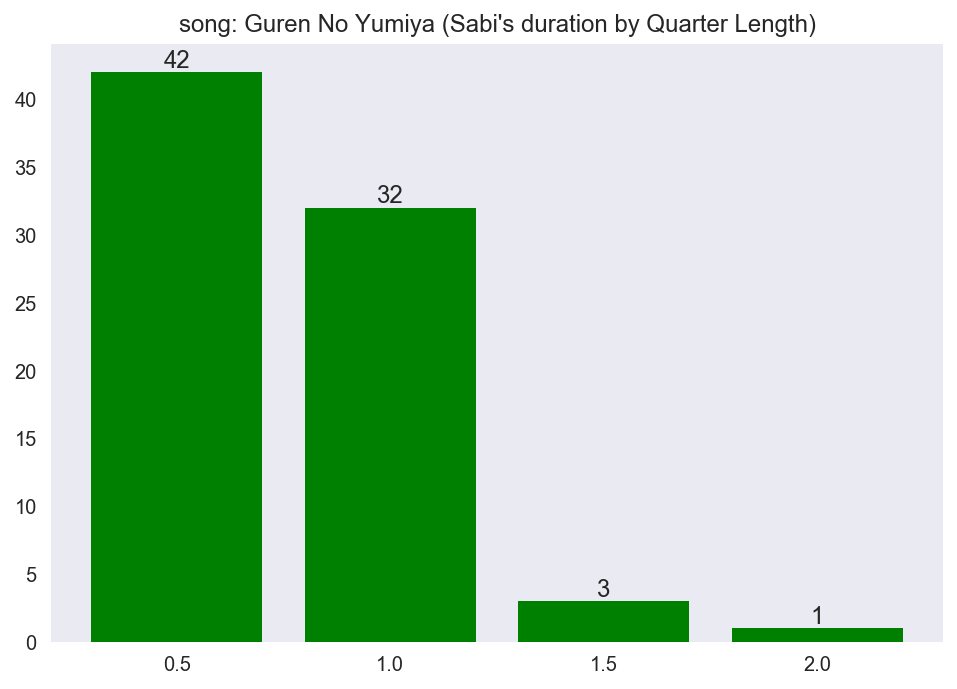

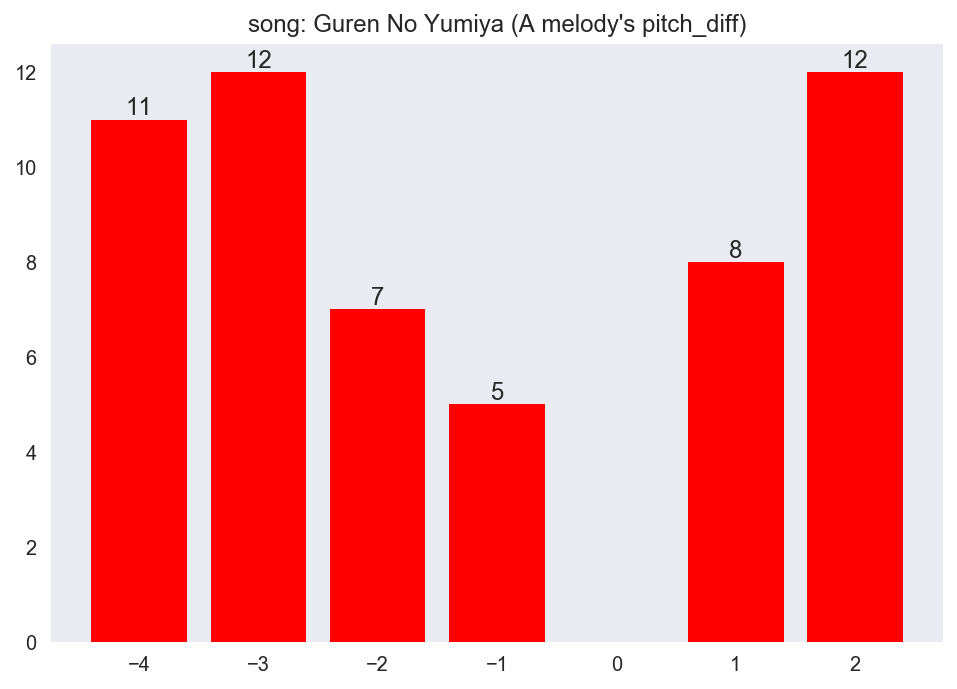

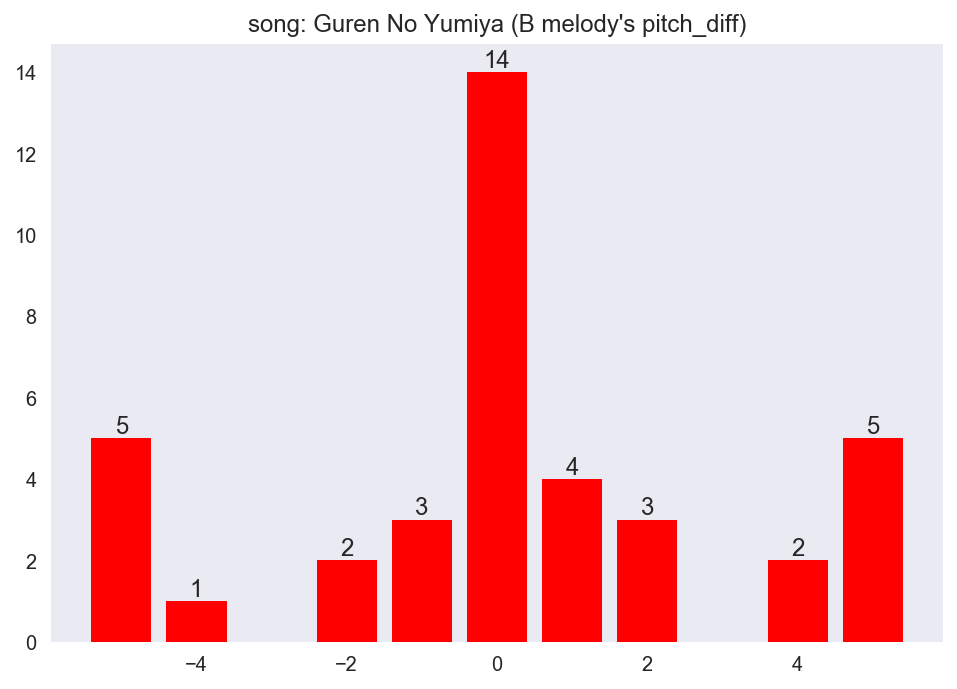

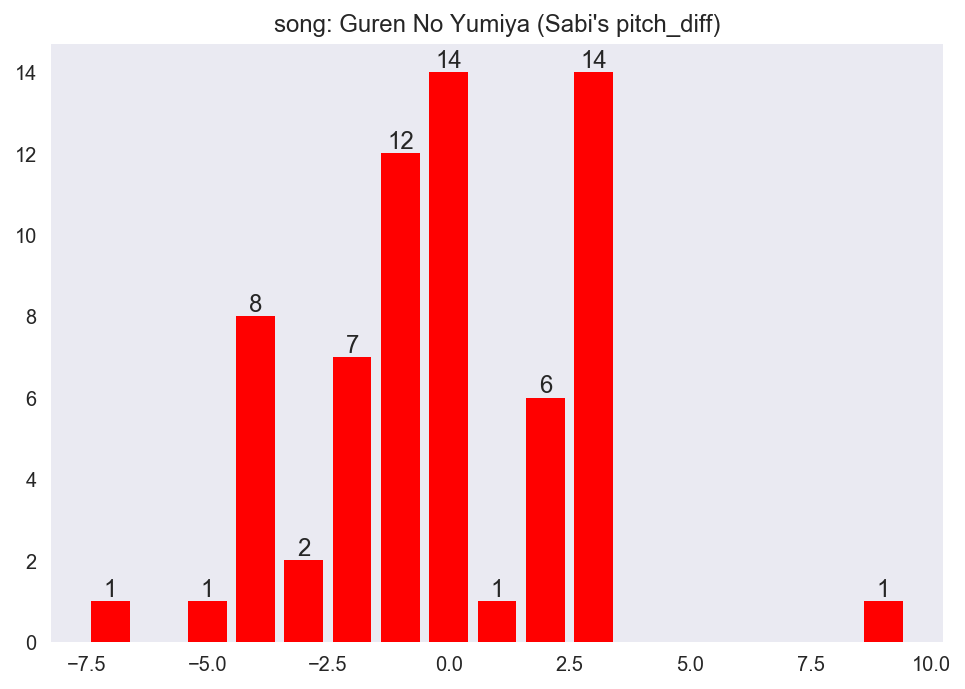

A melodyの跳躍情報　跳躍の割合:0.42,上向跳躍の割合:0.0,下降跳躍の割合:0.42
B melodyの跳躍情報　跳躍の割合:0.33,上向跳躍の割合:0.18,下降跳躍の割合:0.15
Sabiの跳躍情報　跳躍の割合:0.4,上向跳躍の割合:0.22,下降跳躍の割合:0.18
A melodyの音域情報　最低音:F#3,最高音:D#4,音域:9半音(54-63)
B melodyの音域情報　最低音:D#3,最高音:C#4,音域:10半音(51-61)
Sabiの音域情報　最低音:G#3,最高音:G#4,音域:12半音(56-68)
Guren No Yumiya
A melodyの音価難易度4.33
B melodyの音価難易度6.1
Sabiの音価難易度4.38
A melodyのタイの数24
B melodyのタイの数3
Sabiのタイの数22
------------Konayuki-------------
-------A melodyの統計情報---------
調:D major
-------B melodyの統計情報---------
調:D major
-------Sabiの統計情報---------
調:D major


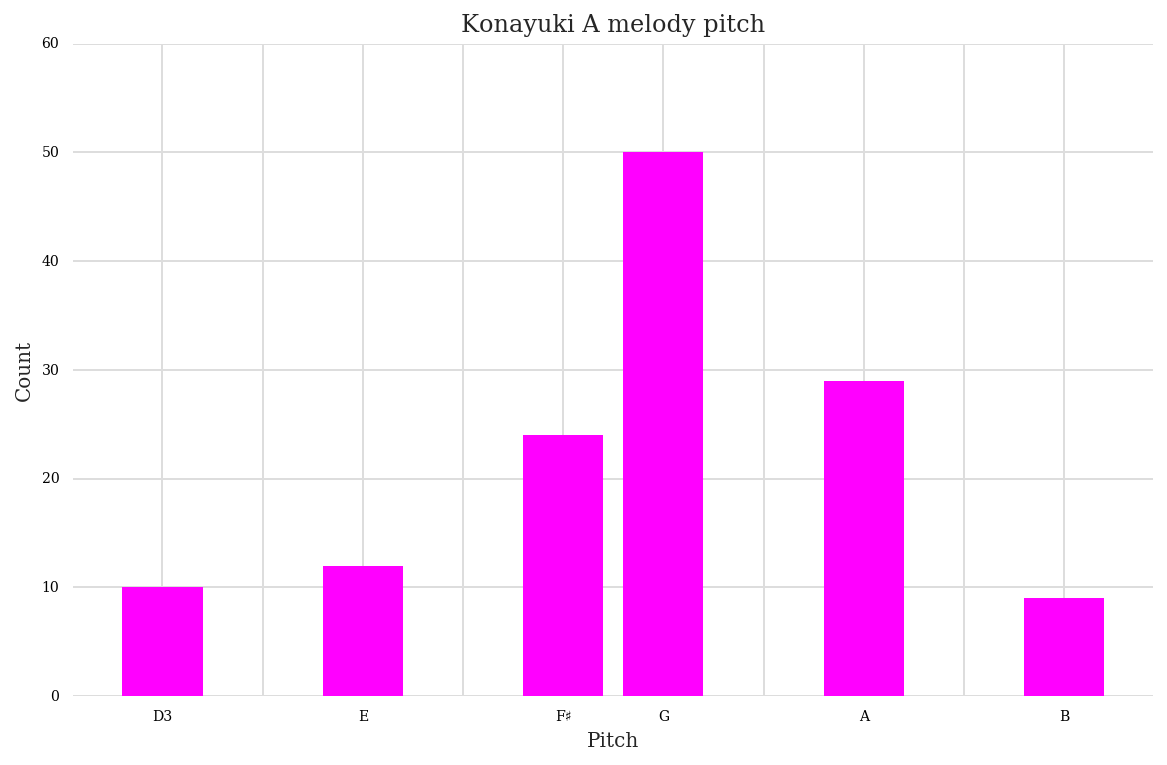

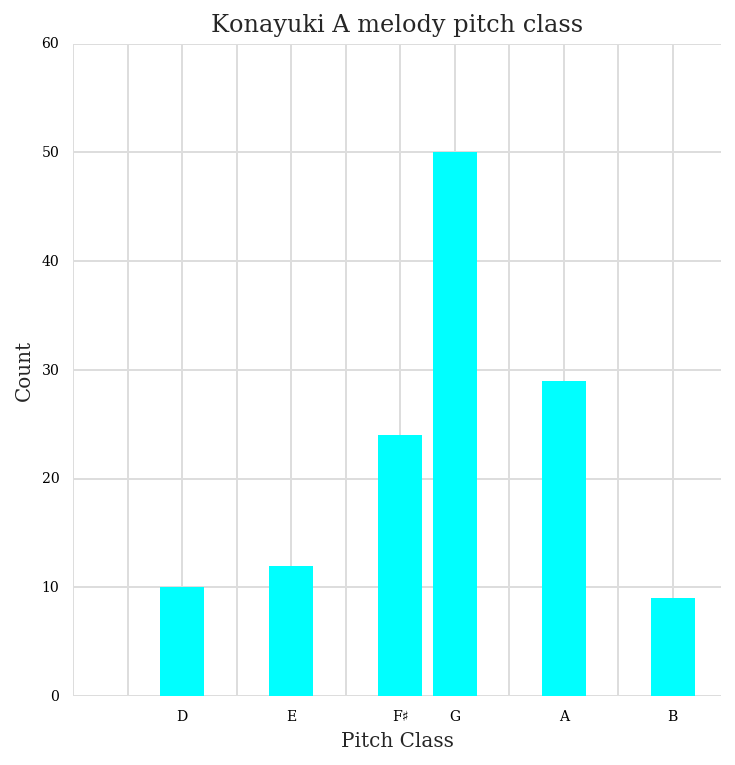

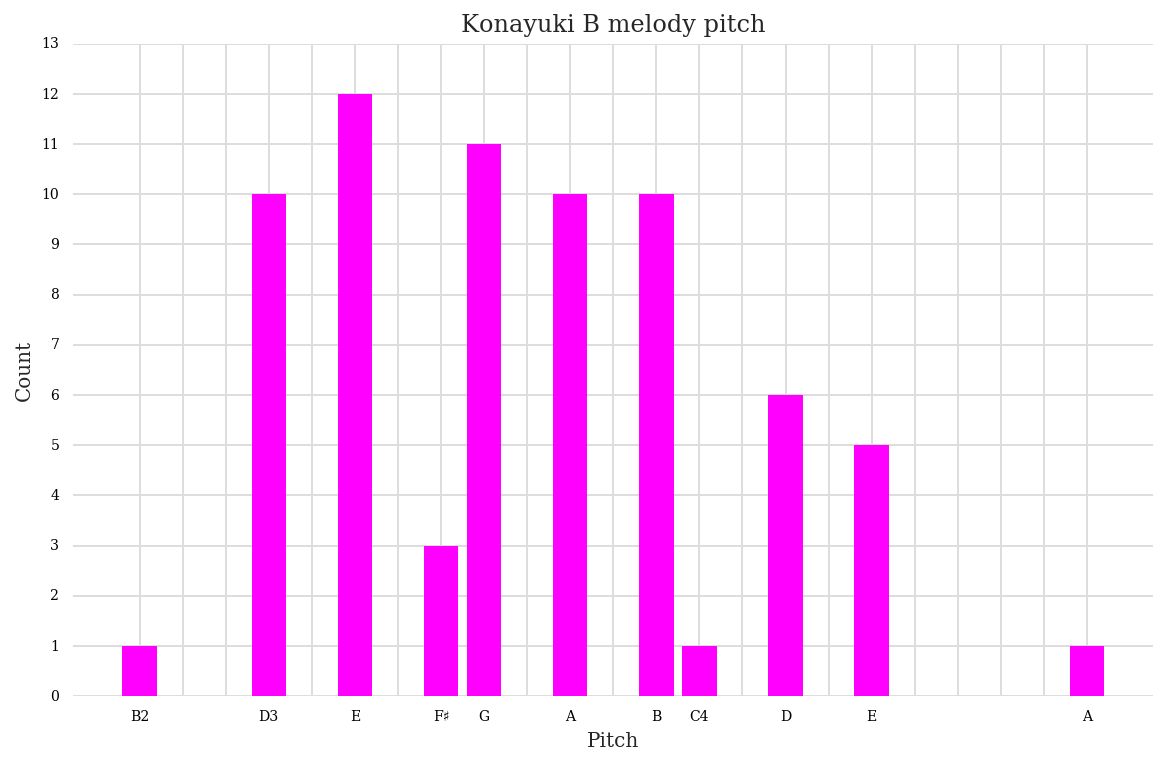

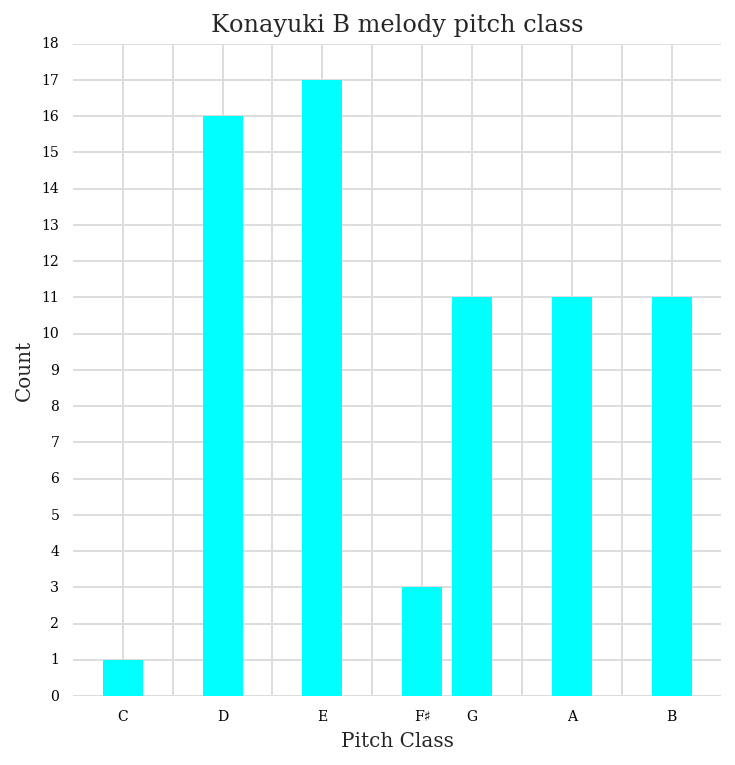

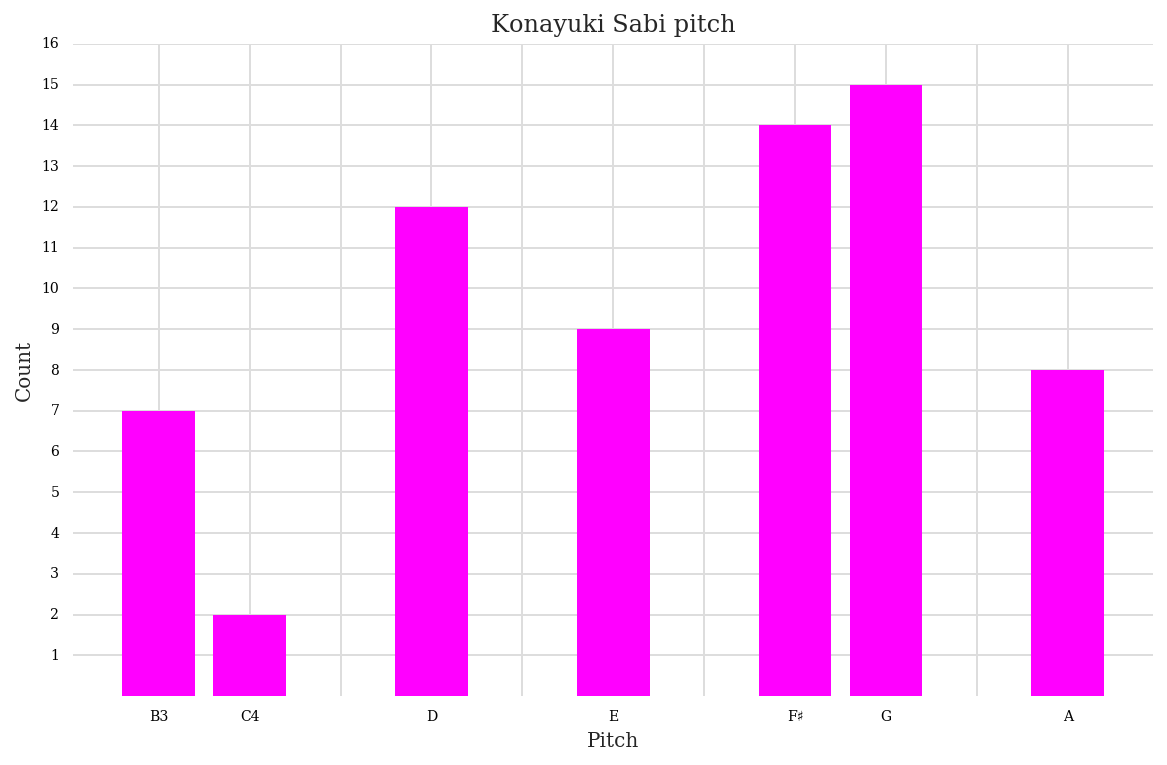

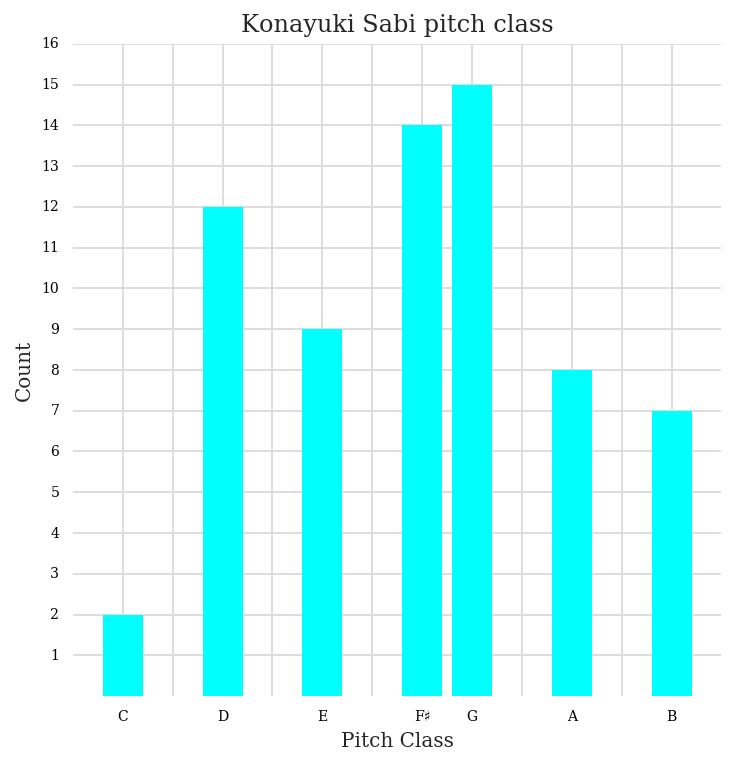

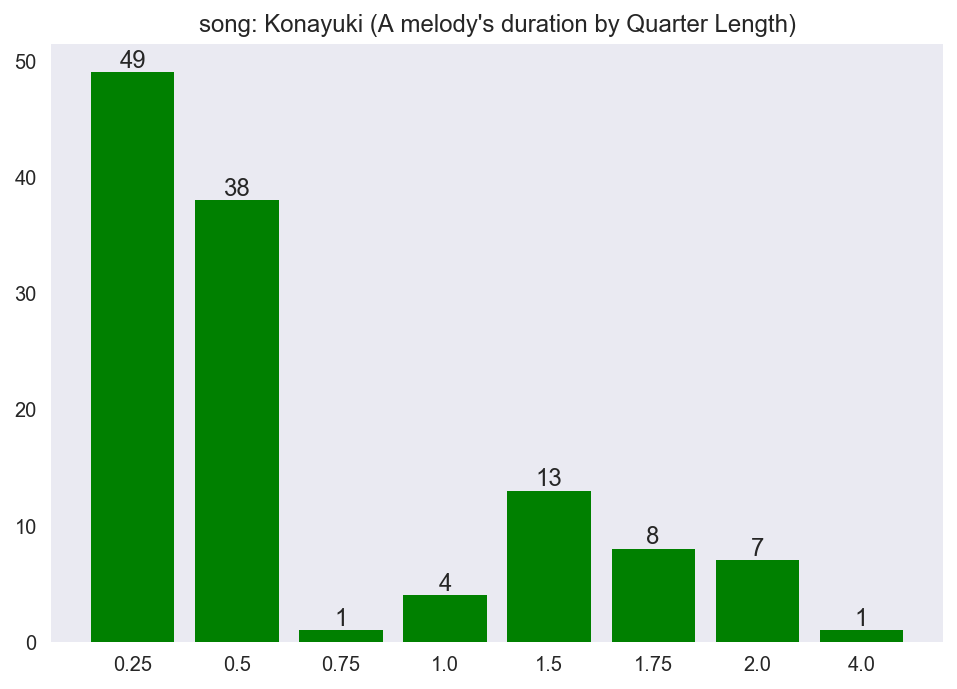

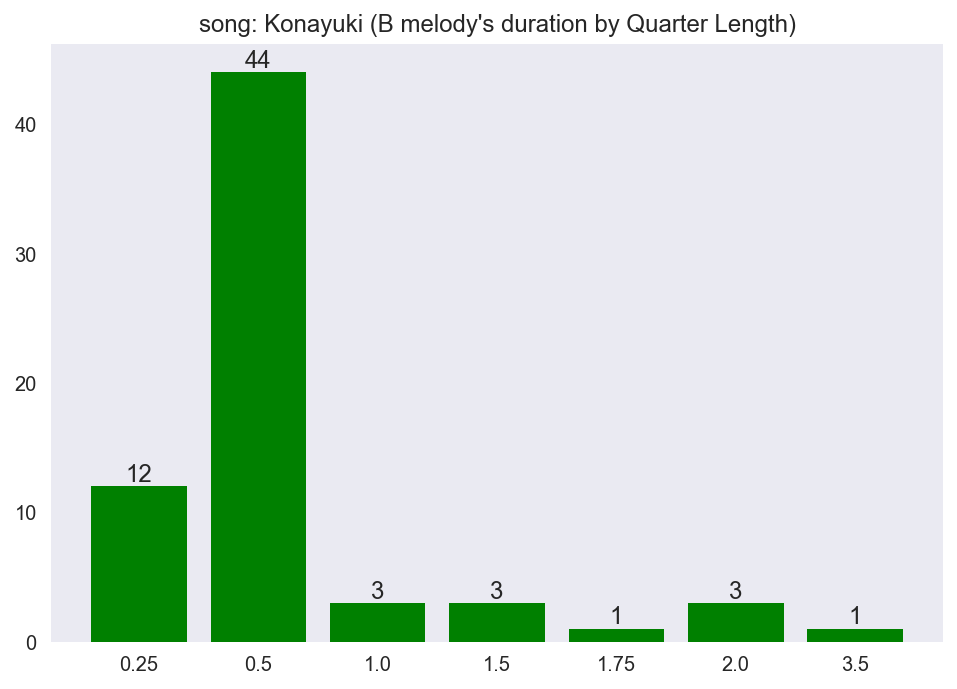

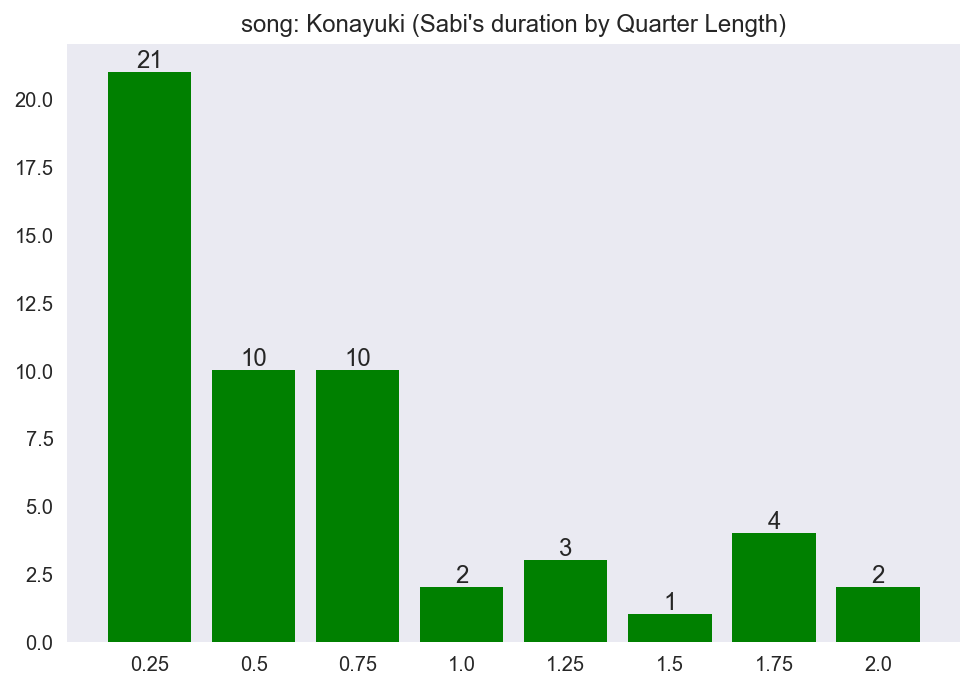

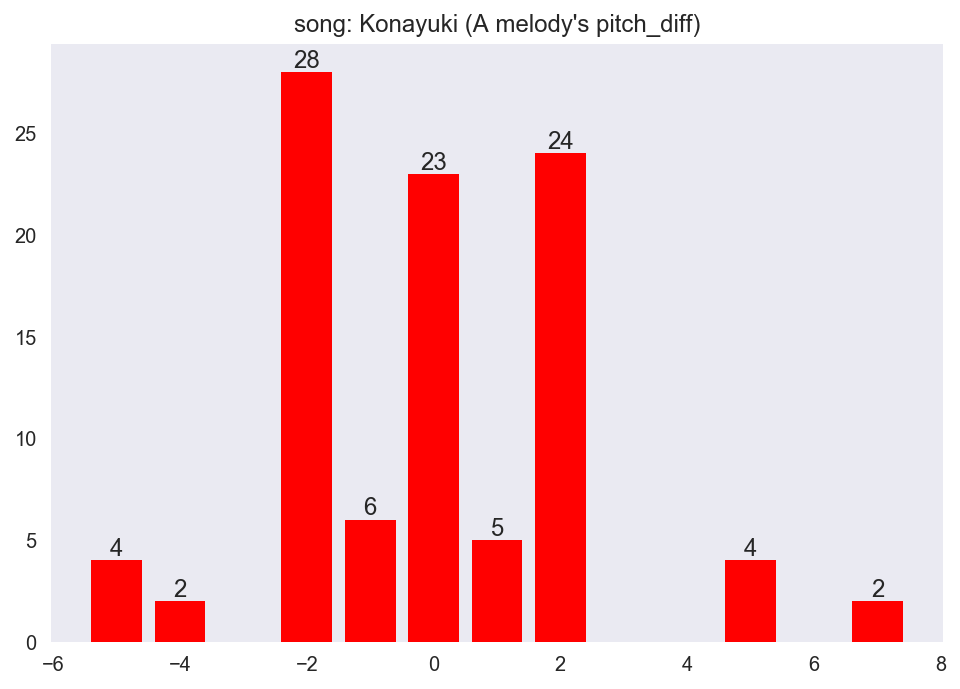

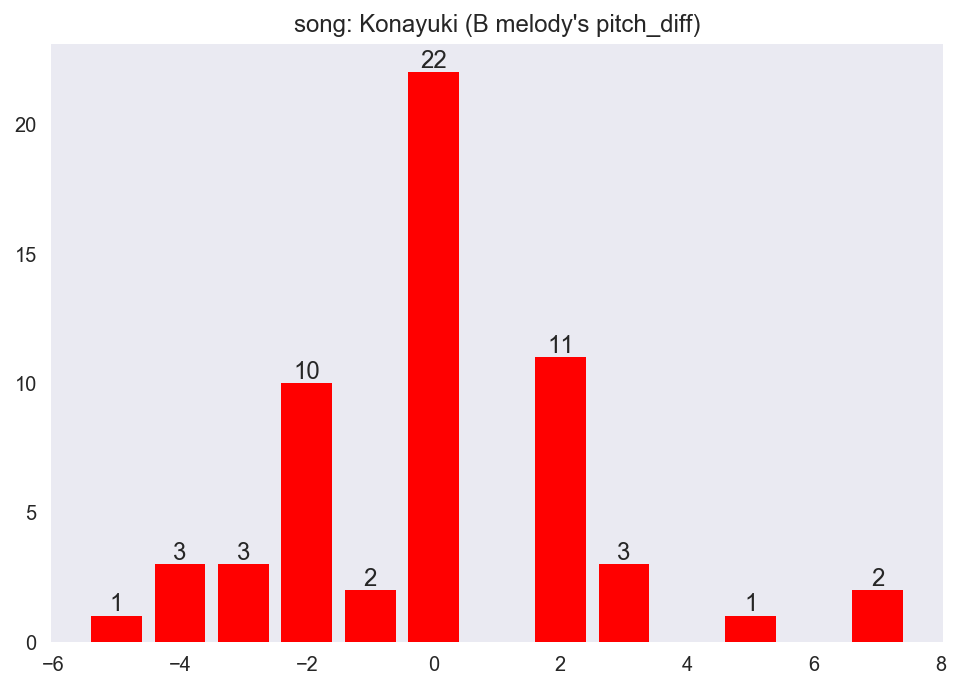

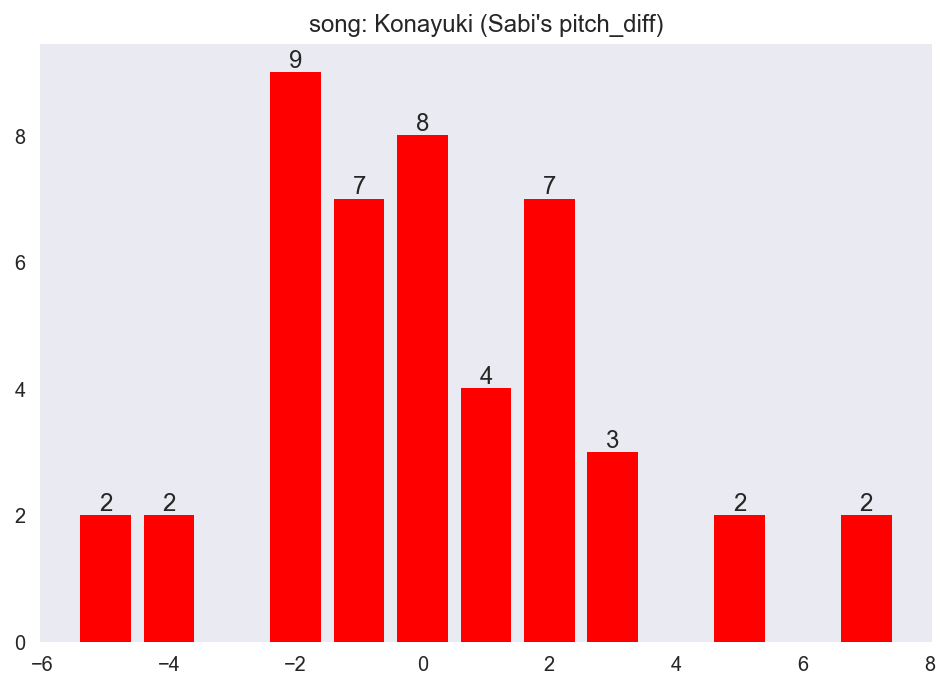

A melodyの跳躍情報　跳躍の割合:0.12,上向跳躍の割合:0.061,下降跳躍の割合:0.061
B melodyの跳躍情報　跳躍の割合:0.22,上向跳躍の割合:0.1,下降跳躍の割合:0.12
Sabiの跳躍情報　跳躍の割合:0.24,上向跳躍の割合:0.15,下降跳躍の割合:0.087
A melodyの音域情報　最低音:D3,最高音:B3,音域:9半音(50-59)
B melodyの音域情報　最低音:B2,最高音:A4,音域:22半音(47-69)
Sabiの音域情報　最低音:B3,最高音:A4,音域:10半音(59-69)
Konayuki
A melodyの音価難易度6.95
B melodyの音価難易度6.68
Sabiの音価難易度6.4
A melodyのタイの数28
B melodyのタイの数7
Sabiのタイの数18
------------Ultra soul-------------
-------A melodyの統計情報---------
調:g# minor
-------B melodyの統計情報---------
調:g# minor
-------Sabiの統計情報---------
調:c# minor


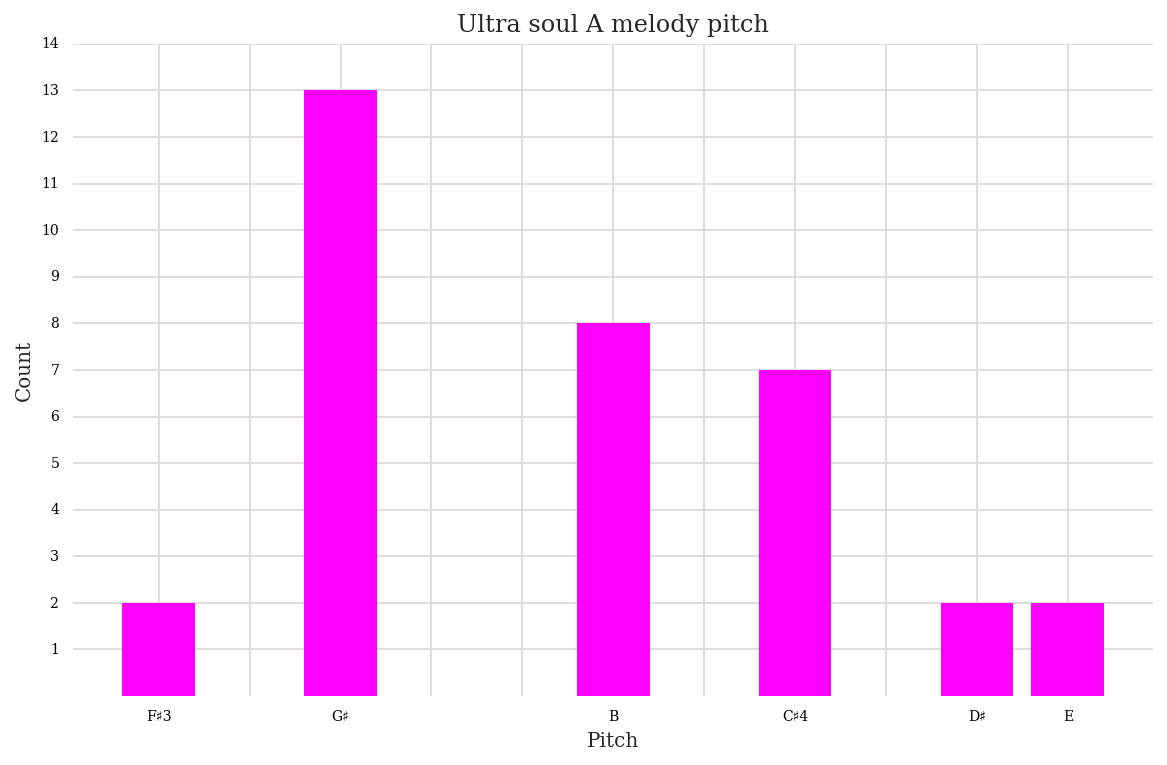

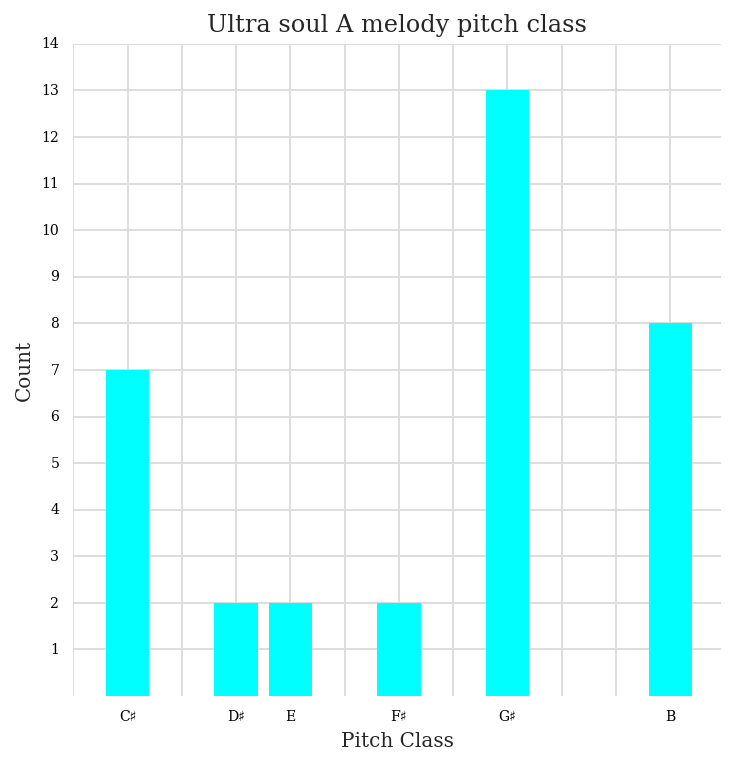

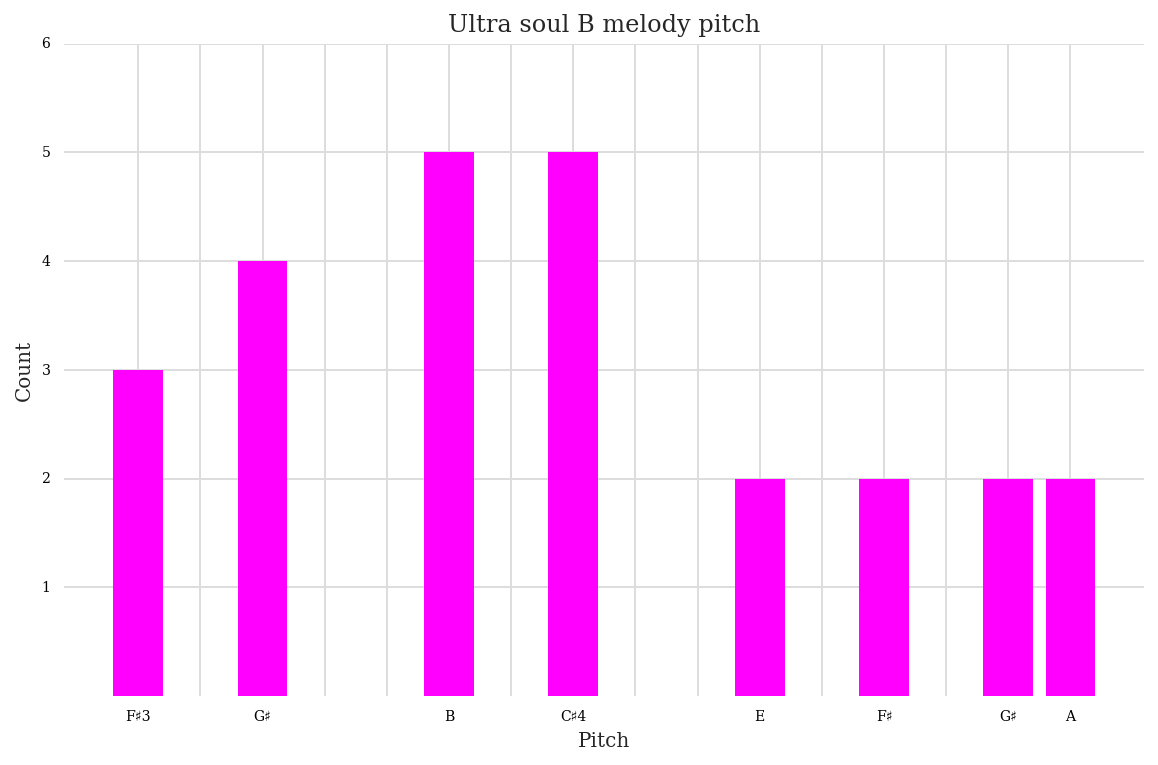

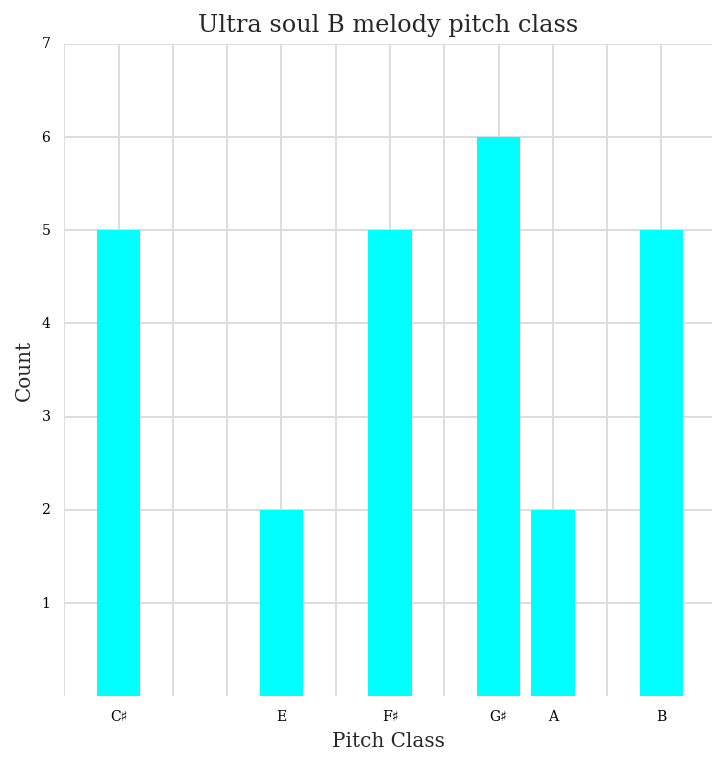

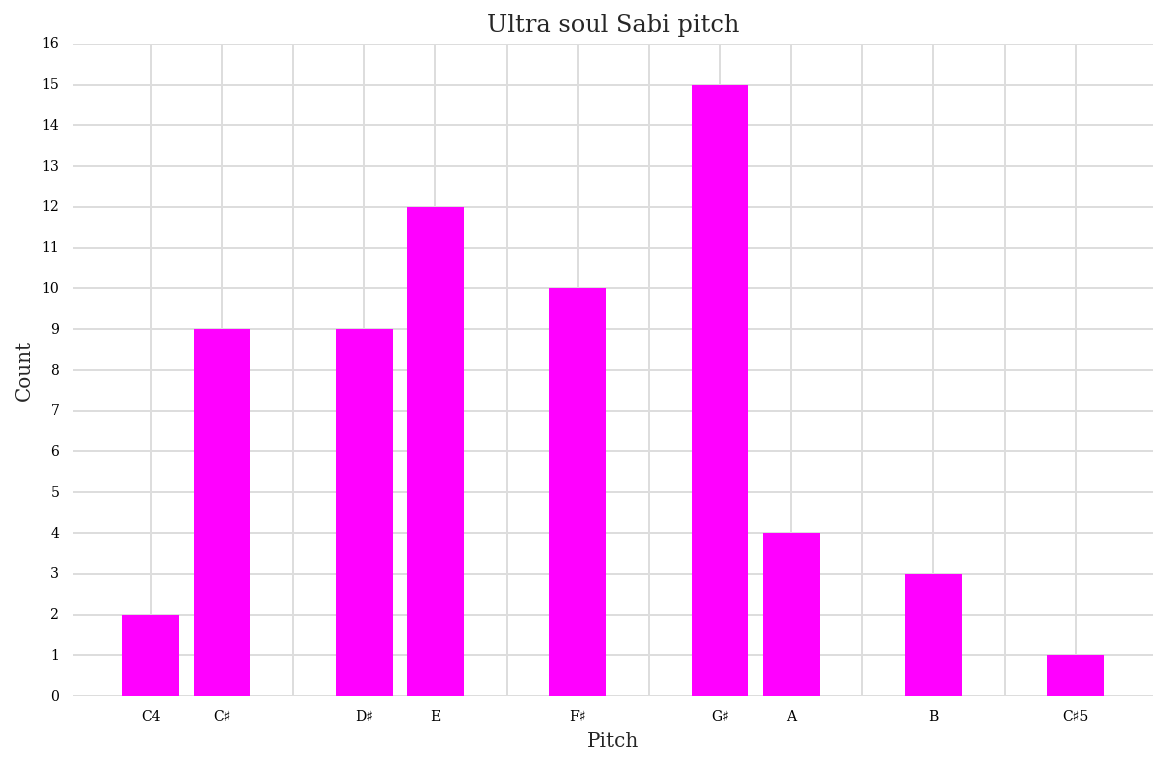

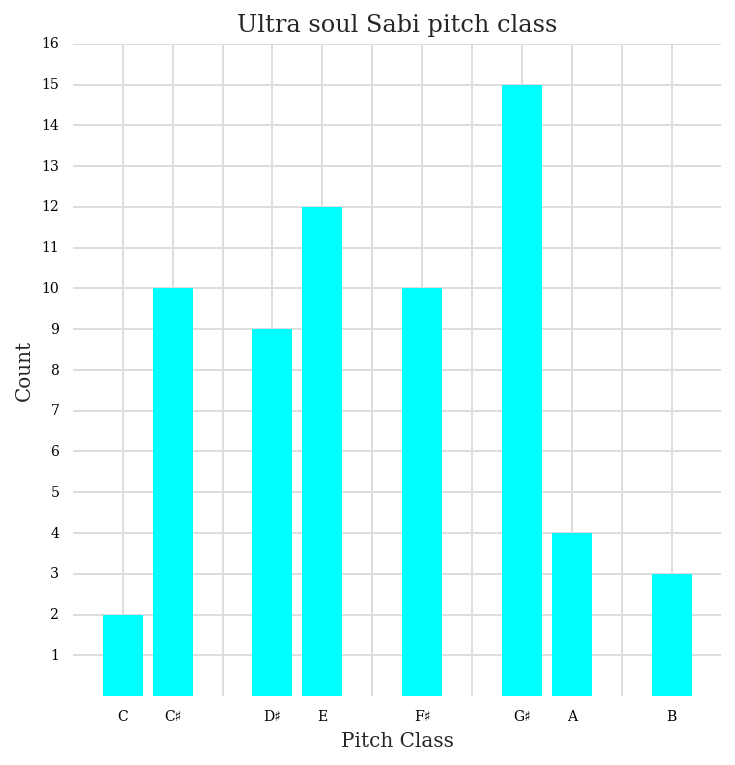

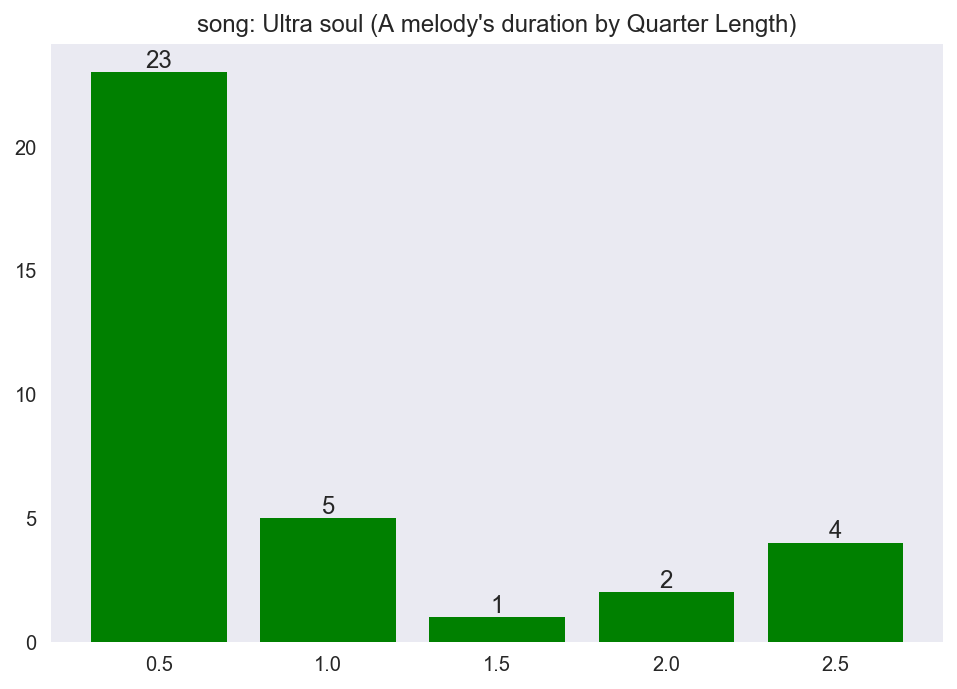

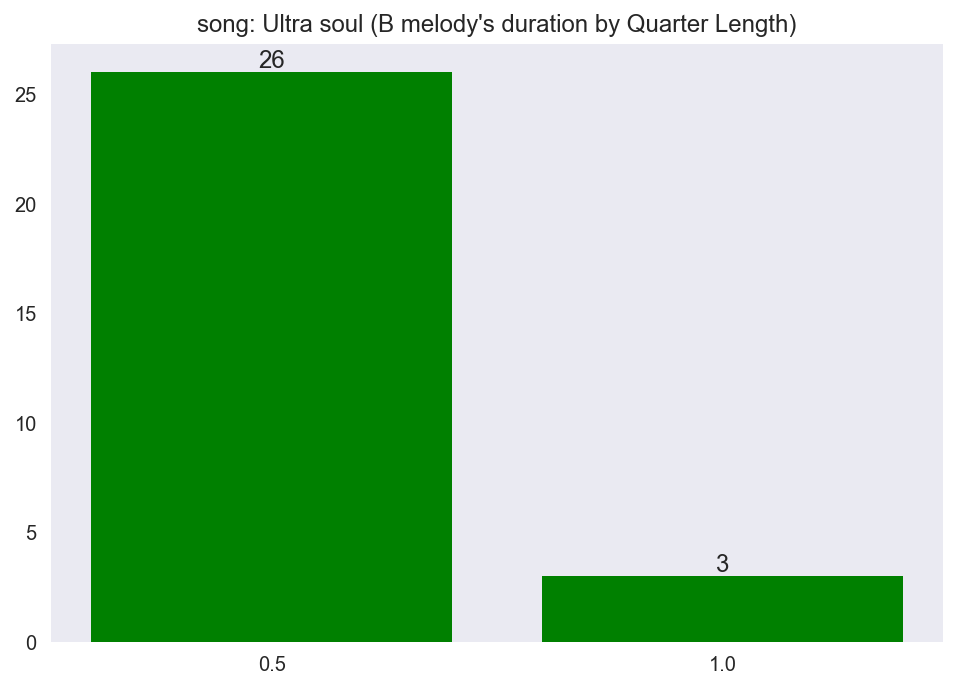

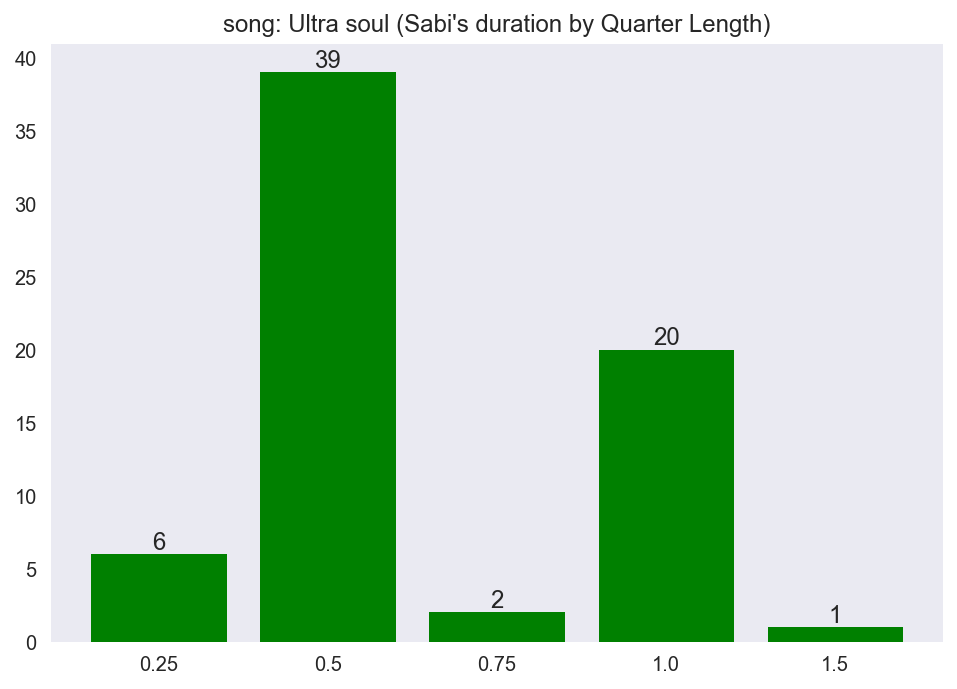

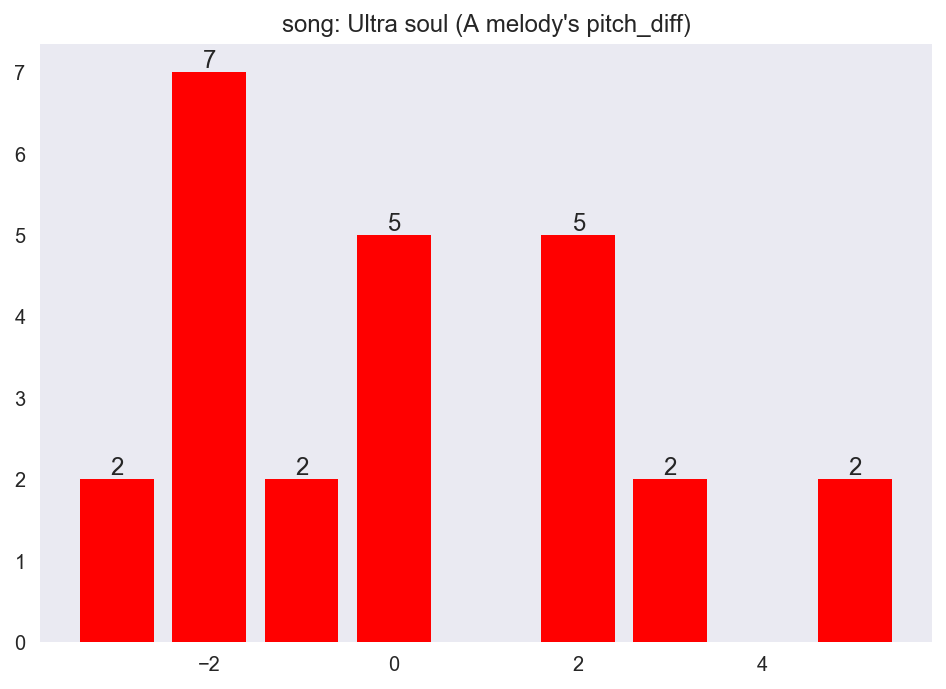

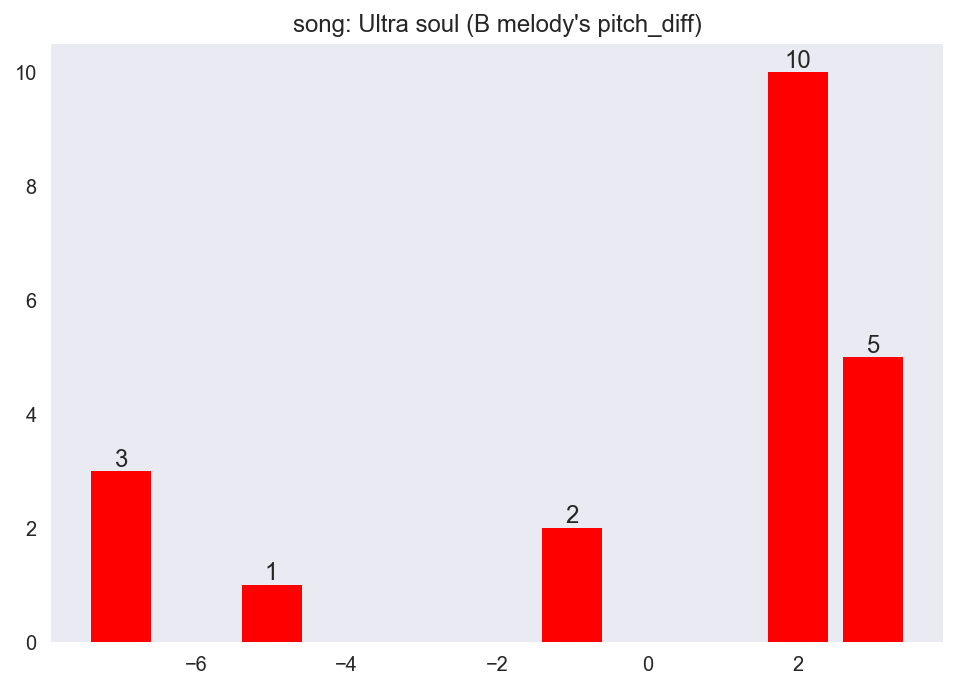

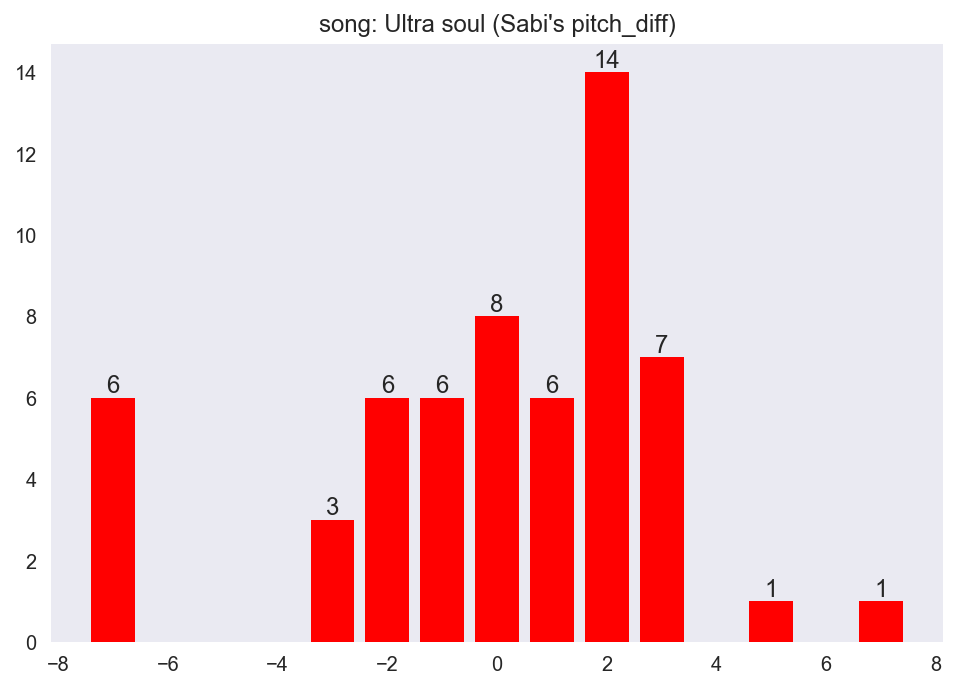

A melodyの跳躍情報　跳躍の割合:0.24,上向跳躍の割合:0.16,下降跳躍の割合:0.08
B melodyの跳躍情報　跳躍の割合:0.43,上向跳躍の割合:0.24,下降跳躍の割合:0.19
Sabiの跳躍情報　跳躍の割合:0.31,上向跳躍の割合:0.16,下降跳躍の割合:0.16
A melodyの音域情報　最低音:F#3,最高音:E4,音域:10半音(54-64)
B melodyの音域情報　最低音:F#3,最高音:A4,音域:15半音(54-69)
Sabiの音域情報　最低音:C4,最高音:C#5,音域:13半音(60-73)
Ultra soul
A melodyの音価難易度4.02
B melodyの音価難易度4.33
Sabiの音価難易度5.42
A melodyのタイの数4
B melodyのタイの数0
Sabiのタイの数2
------------Koi-------------
-------A melodyの統計情報---------
調:A major
-------B melodyの統計情報---------
調:A major
-------Sabiの統計情報---------
調:A major


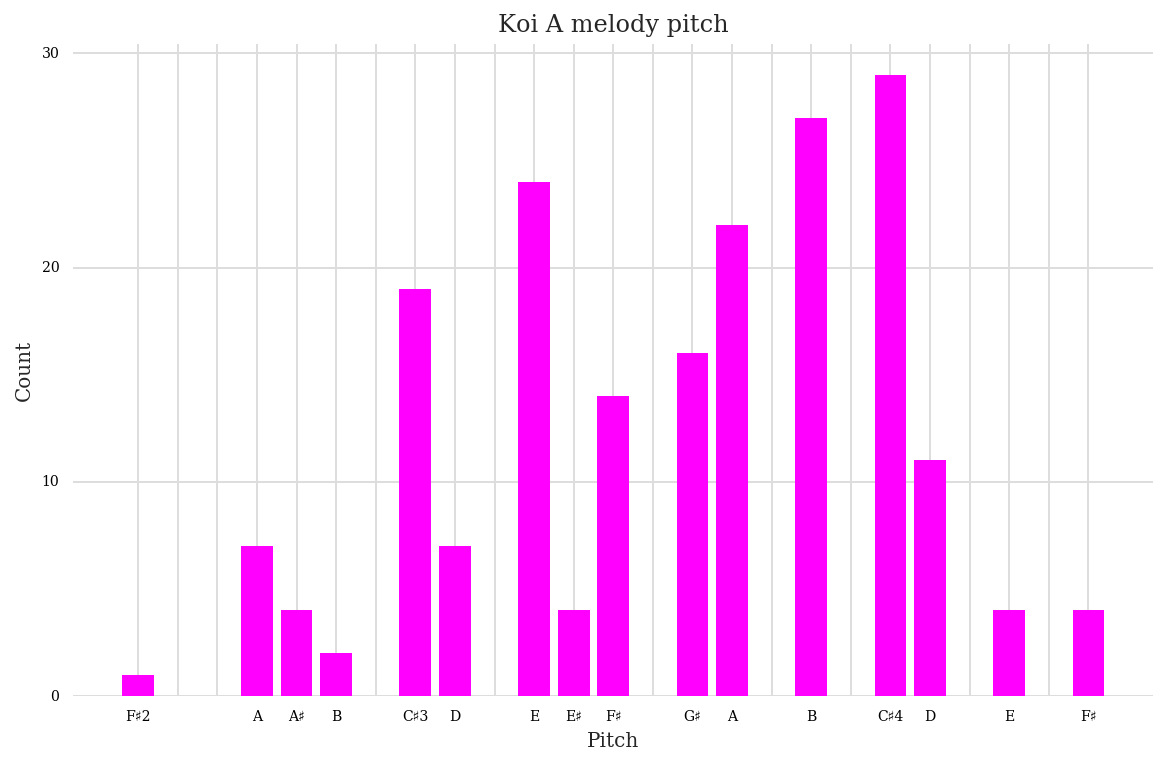

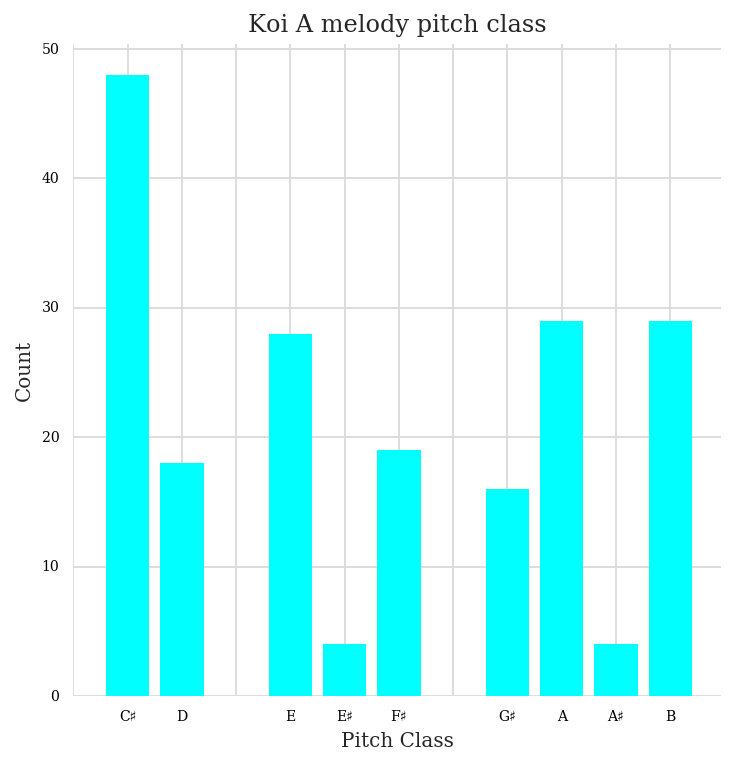

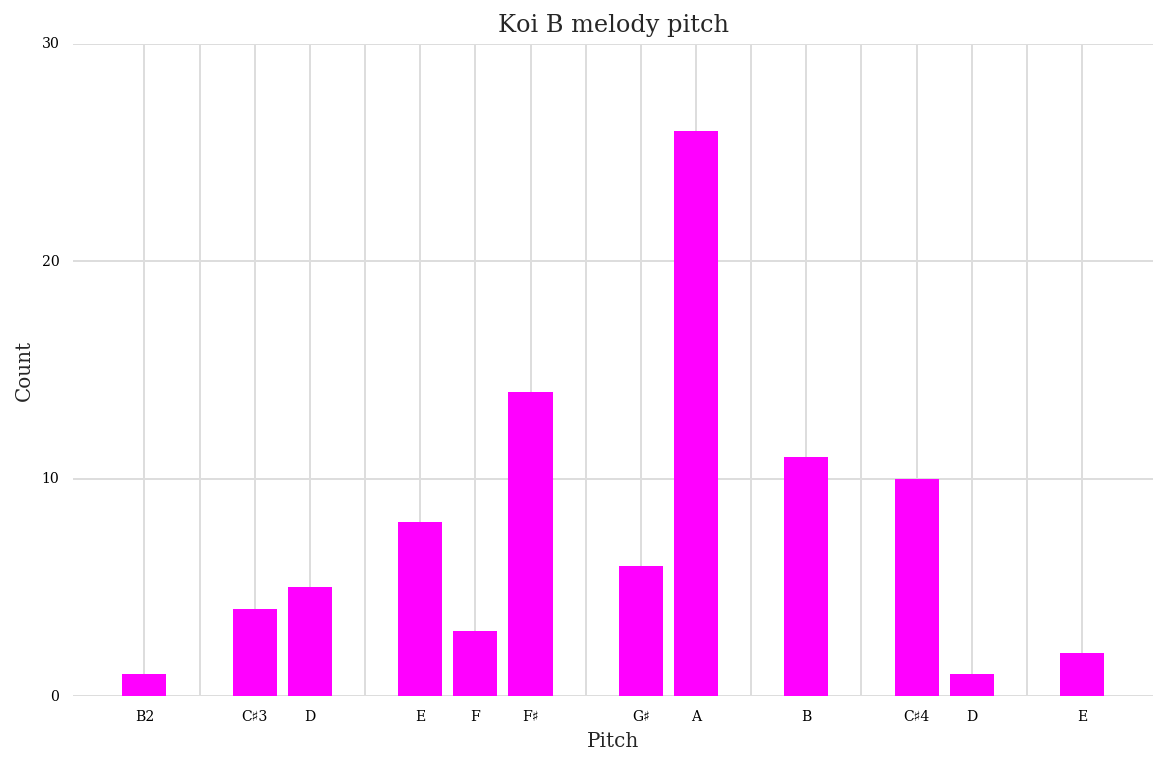

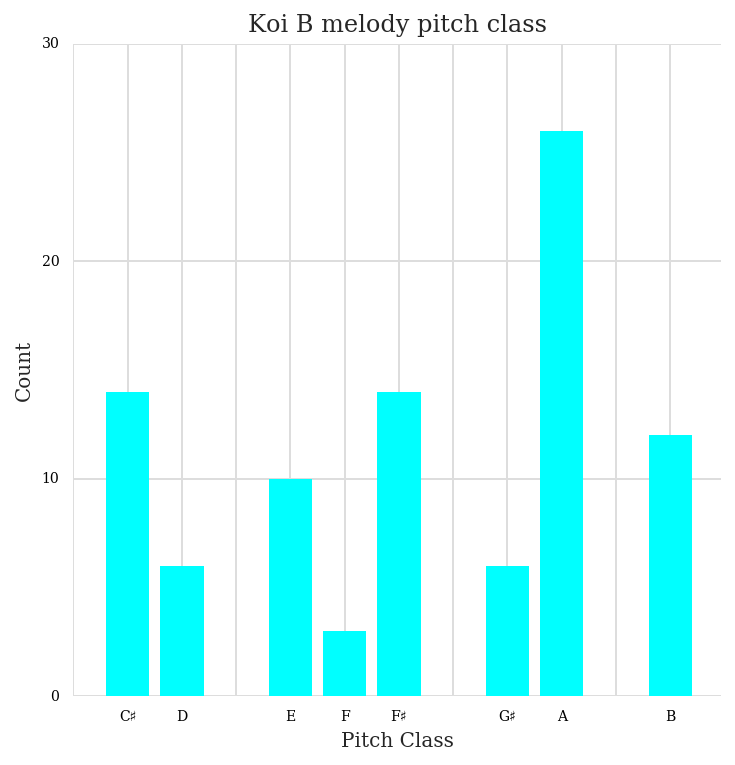

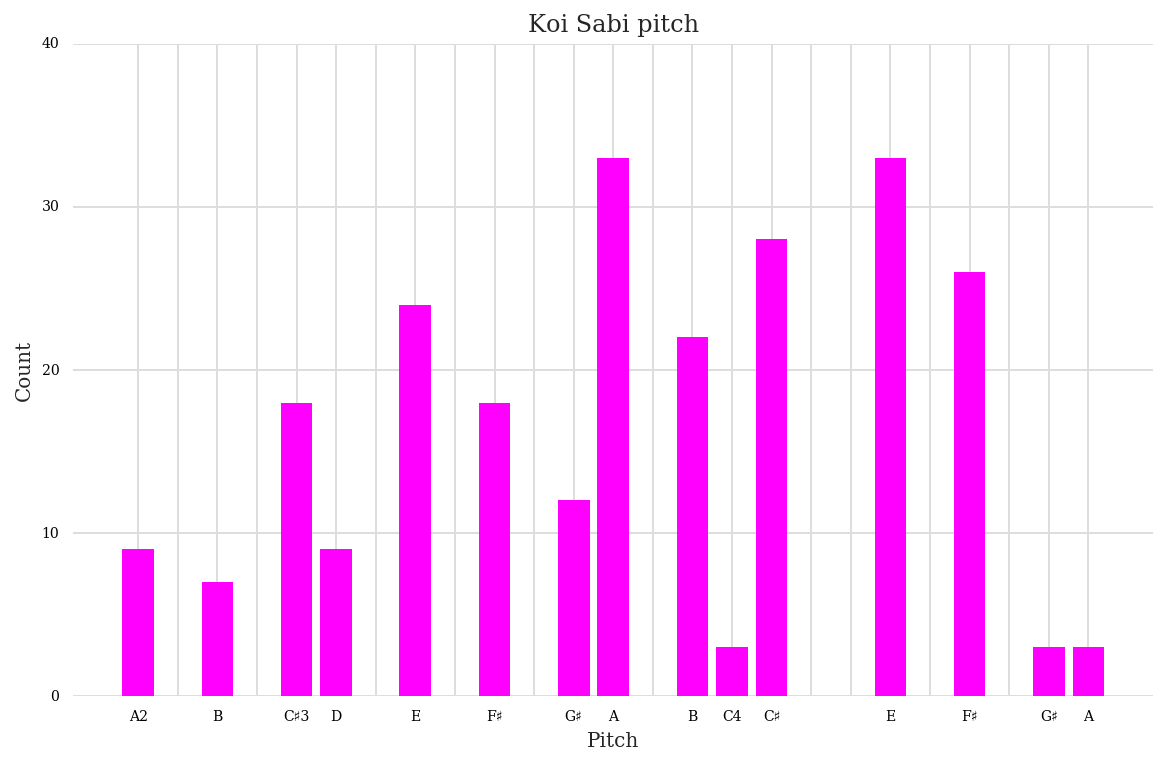

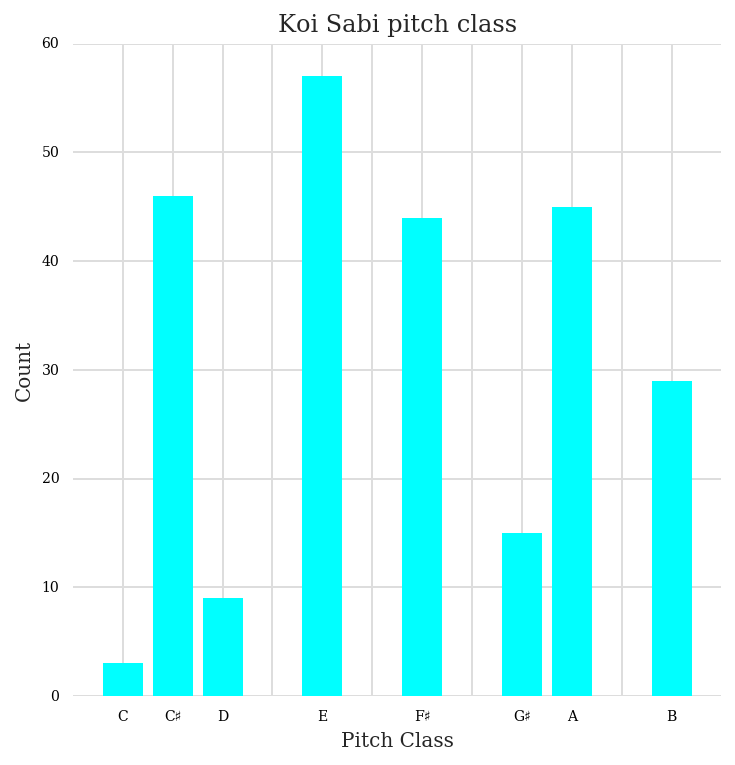

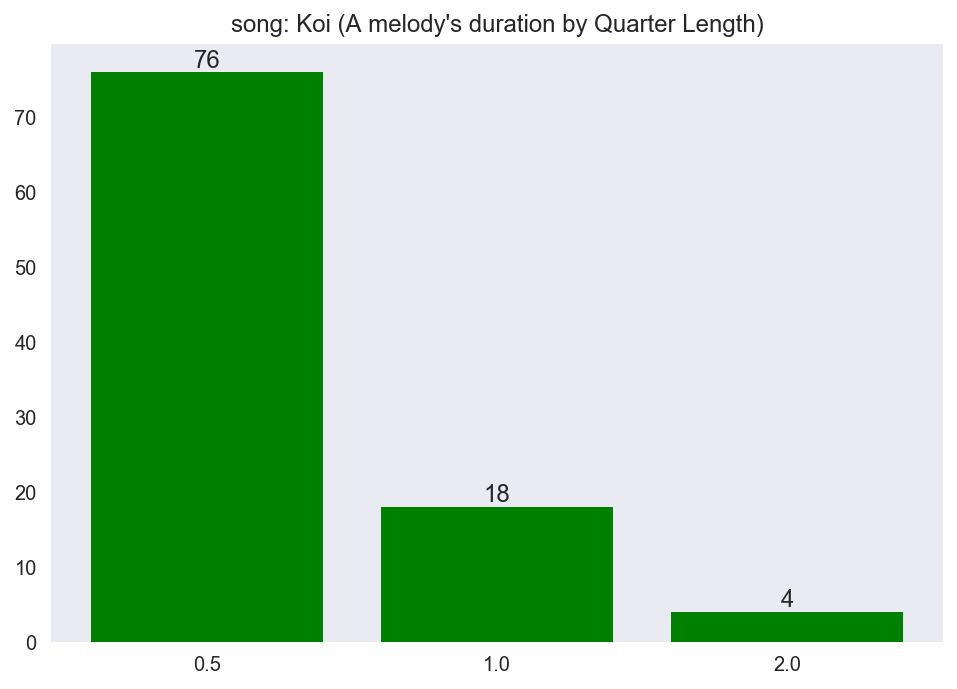

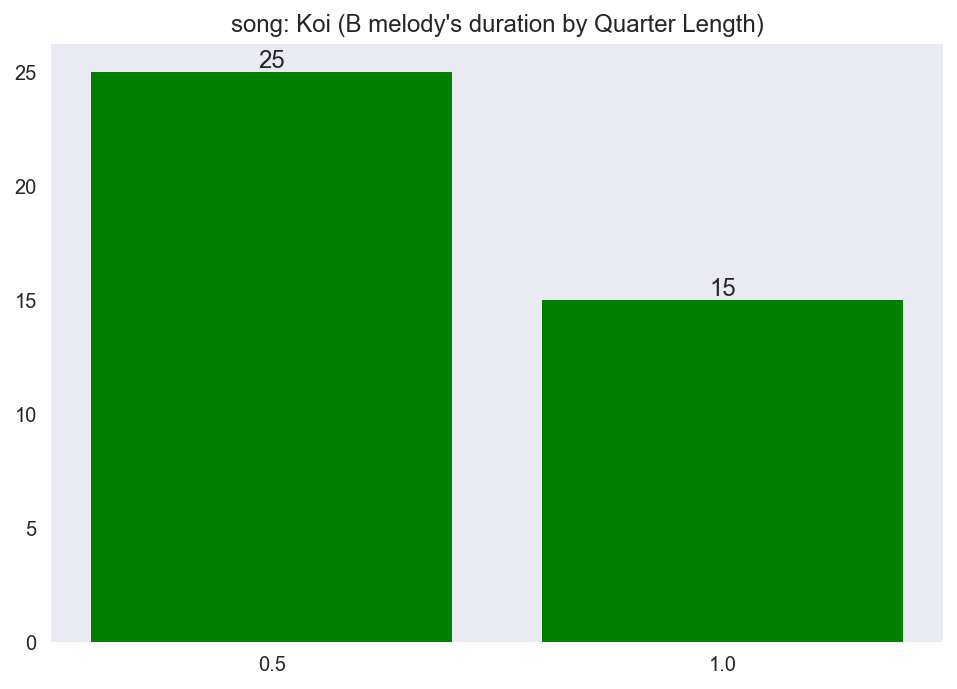

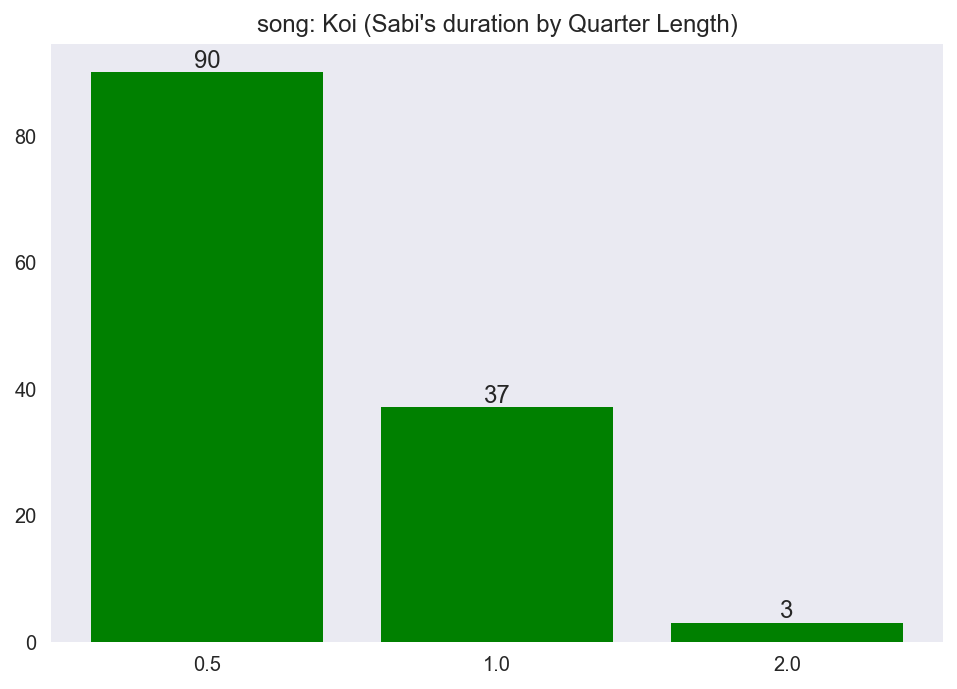

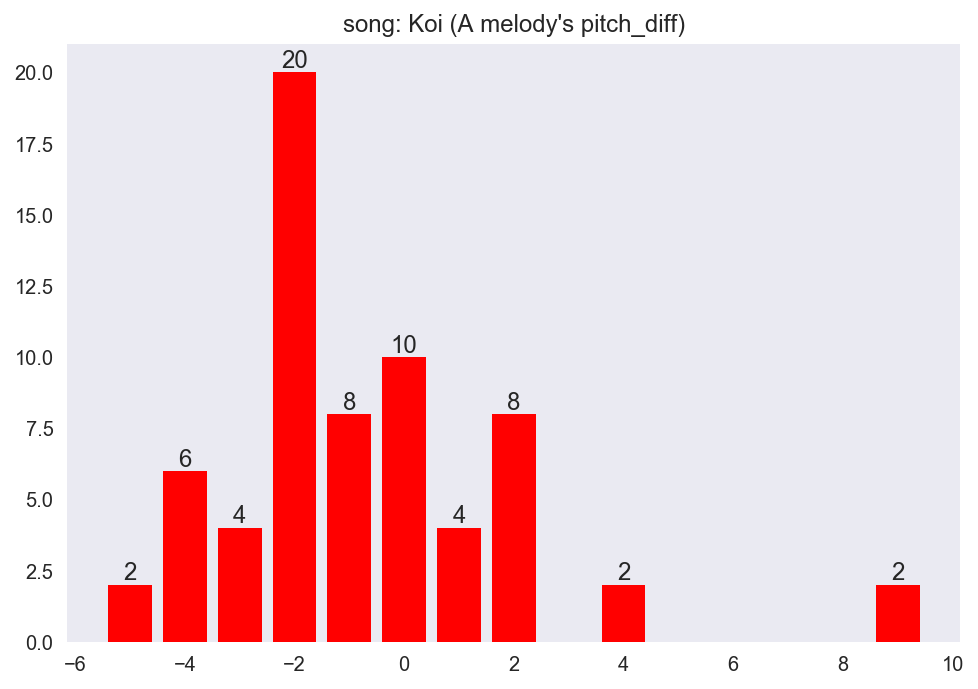

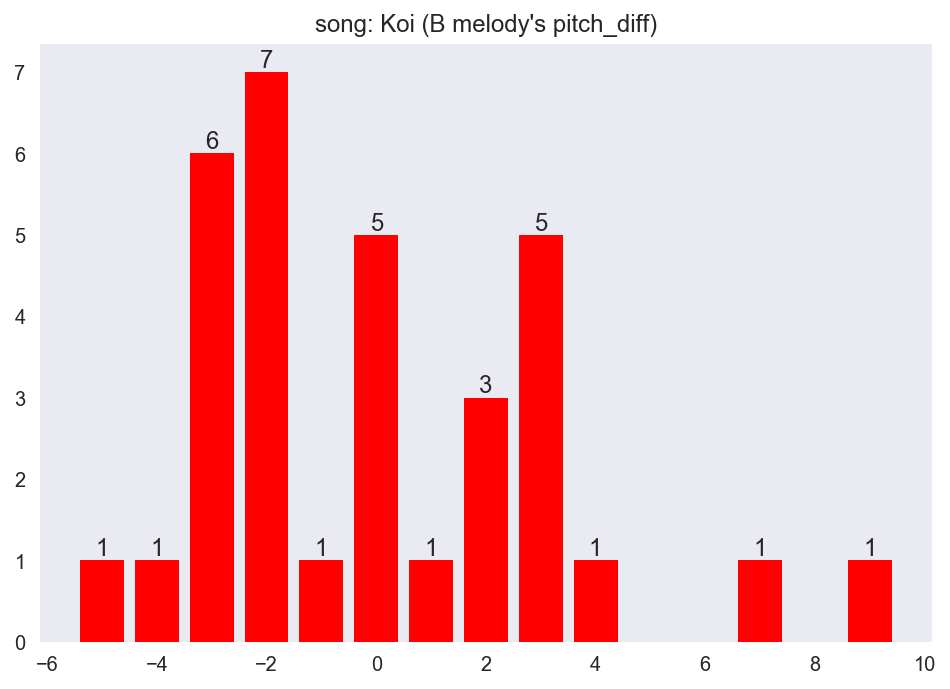

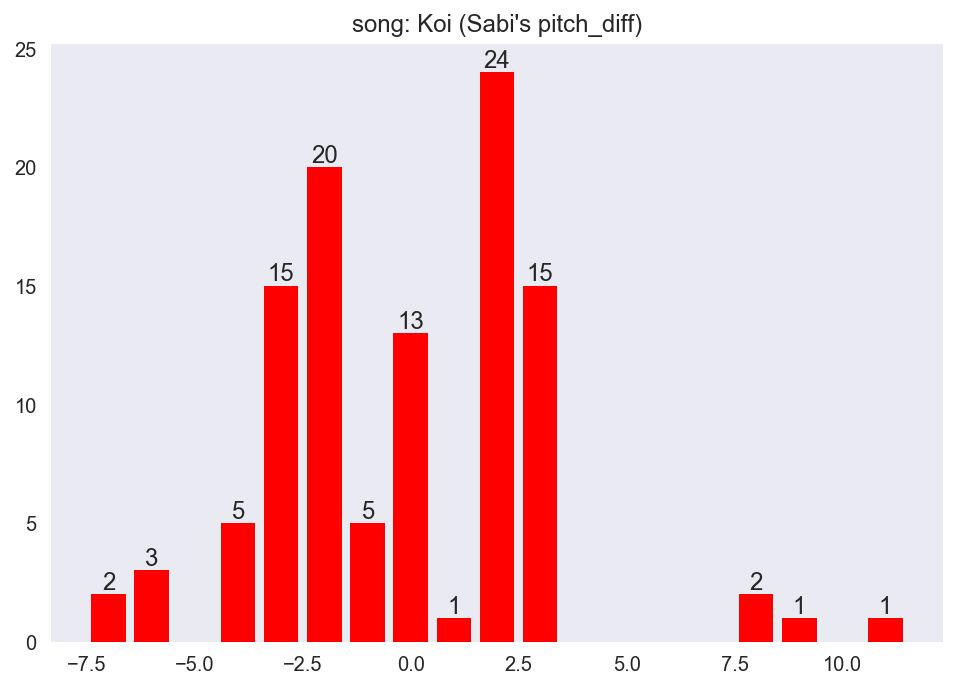

A melodyの跳躍情報　跳躍の割合:0.24,上向跳躍の割合:0.061,下降跳躍の割合:0.18
B melodyの跳躍情報　跳躍の割合:0.48,上向跳躍の割合:0.24,下降跳躍の割合:0.24
Sabiの跳躍情報　跳躍の割合:0.41,上向跳躍の割合:0.18,下降跳躍の割合:0.23


AttributeError: 'ChordSymbol' object has no attribute 'pitch'

In [38]:
for sheets in analysis_corpus:
    sheets.show_key()
    sheets.counting_pitch()
    plt.figure()
    sheets.counting_duration()
    plt.figure()
    sheets.plot_pitch_diff()
    sheets.calucurate_jump()
    sheets.caluculate_pitch_range()
    print(sheets.name)
    sheets.caluculate_duration_difficulty()
    sheets.count_tie()
    #print("=====wpcs=====\nAmelody{:.3},Bmelody{:.3},Sabi{:.3}".format(wpcss[0],wpcss[1],wpcss[2]))


### 歌唱実験アンケート

+ CSVデータの出力
+ セクションごとの主観難易度


In [37]:
difficulty = {"メロディが複雑で正確に音程を取りづらい":0,"音の飛びが激しく音程がとれない":1,"音域が広い":2,"テンポが速い":3,"リズムが複雑でわかりにくい":4,"16分音符などが多くてリズムが細かい":5,"ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある":6,"英語の歌詞":7,"シャウトやビブラートなど特殊奏法":8,"other":9,np.nan:100}

def difficulty_to_tag(string,dic):
    if type(string) == float:
        print("nannan")
    else:
        #難易度の理由が複数コンマとスペース区切りで入力
        array = []
        #解析可能な形のリストに区切る
        words = string.split(", ")  
        for word in words:
            print(word)
            if word in difficulty:
                print("ireruyo-{}".format(str(word)))
                array.append(difficulty[word])
                dic[difficulty[word]] += 1
            else:
                array.append(difficulty["other"])
                dic[9] += 1
            print(array)
        return array

In [38]:
#共起のカウント
def tessa(source):
    result = []
    for p1 in range(len(source)):
        for p2 in range(p1+1,len(source)):
            result.append( (source[p1],source[p2]) )
            
    return result

In [42]:
df

,time_stamp,age,sex,singing_competence,song,amero_difficulty,amero_reason,amero_reason_free,bmero_difficulty,bmero_reason,bmero_reason_free,sabi_difficulty,sabi_reason,sabi_reason_free,preference,memorized,frequency,listenable,other
0,1,23,男性,3,チェリー,2,9,NaN,1,0,NaN,3,0,NaN,3,3,1,3,NaN
1,1,23,男性,3,TSUNAMI,1,9,NaN,1,9,NaN,2,9,NaN,3,2,2,2,NaN
2,1,23,男性,3,紅蓮の弓矢,2,9,NaN,3,6,NaN,3,4,NaN,3,2,1,2,NaN
3,1,23,男性,3,浪漫飛行,3,0,NaN,2,0,NaN,3,1,NaN,2,2,1,2,NaN
4,1,23,男性,3,アポロ,1,"3, 9",NaN,3,6,NaN,4,"6, 9",NaN,3,3,2,3,NaN
5,1,23,男性,3,粉雪,1,9,NaN,1,9,NaN,3,2,NaN,3,3,2,3,NaN
6,2,21,男性,3,チェリー,1,6,NaN,1,"6, 9",NaN,1,2,NaN,4,3,1,4,NaN
7,2,21,男性,3,TSUNAMI,2,"1, 9",NaN,2,"1, 9",NaN,1,2,NaN,4,3,1,4,NaN
8,2,21,男性,3,紅蓮の弓矢,2,"4, 7, 9",NaN,3,"1, 3, 9",NaN,1,3,NaN,3,1,1,1,NaN
9,2,21,男性,3,浪漫飛行,3,"0, 2",NaN,4,"0, 9",NaN,2,6,NaN,2,2,1,4,NaN


In [40]:
def remove_space(string):
    return string.strip()

In [41]:
#扱いやすいよう理由を数字に変換
df = pd.read_csv("yobijikken.csv")

difficulty_count = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}

df["memorized"] = df["memorized"].map(memorable)

for num,reason in enumerate(df["amero_reason"]):
    print(num)
    print(reason)
    a = difficulty_to_tag(reason,difficulty_count)
    df["amero_reason"][num] = str(a).strip("[").strip("]")
for num,reason in enumerate(df["bmero_reason"]):
    print(num)
    print(reason)
    a = difficulty_to_tag(reason,difficulty_count)
    df["bmero_reason"][num] = str(a).strip("[").strip("]")
for num,reason in enumerate(df["sabi_reason"]):
    print(num)
    print(reason)
    a = difficulty_to_tag(reason,difficulty_count)
    df["sabi_reason"][num] = str(a).strip("[").strip("]")

0
滑らかに歌うことが難しいAメロだったから。
滑らかに歌うことが難しいAメロだったから。


C:\Users\match\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[9]
1
自分の音域に合っている
自分の音域に合っている
[9]
2
音域が滑らかに推移しており極端な上下が無い。
音域が滑らかに推移しており極端な上下が無い。
[9]
3
メロディが複雑で正確に音程を取りづらい
メロディが複雑で正確に音程を取りづらい
ireruyo-メロディが複雑で正確に音程を取りづらい
[0]
4
テンポが速い, テンポは早いが音域がそこまで広くはない印象
テンポが速い
ireruyo-テンポが速い
[3]
テンポは早いが音域がそこまで広くはない印象
[3, 9]
5
音の推移が緩やかでテンポも遅い。
音の推移が緩やかでテンポも遅い。
[9]
6
ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある
ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある
ireruyo-ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある
[6]
7
音の飛びが激しく音程がとれない, 始まりの音が低く、当てられない
音の飛びが激しく音程がとれない
ireruyo-音の飛びが激しく音程がとれない
[1]
始まりの音が低く、当てられない
[1, 9]
8
リズムが複雑でわかりにくい, 英語の歌詞, 低い音がとりづらい
リズムが複雑でわかりにくい
ireruyo-リズムが複雑でわかりにくい
[4]
英語の歌詞
ireruyo-英語の歌詞
[4, 7]
低い音がとりづらい
[4, 7, 9]
9
メロディが複雑で正確に音程を取りづらい, 音域が広い
メロディが複雑で正確に音程を取りづらい
ireruyo-メロディが複雑で正確に音程を取りづらい
[0]
音域が広い
ireruyo-音域が広い
[0, 2]
10
音域が広い, テンポが速い
音域が広い
ireruyo-音域が広い
[2]
テンポが速い
ireruyo-テンポが速い
[2, 3]
11
ゆっくりで歌いやすいが、低いところは当てづらい
ゆっくりで歌いやすいが、低いところは当てづらい
[9]
12
ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある, とにかく息継ぎをするタイミングがない
ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある
ireruyo-ロングトーンがあったり息継ぎタイミングがわかりにくく肺

C:\Users\match\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\match\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [43]:
difficulty_novel = {}
print(difficulty_count)
difficulty_num ={}
for key in difficulty_count.keys():
    print(difficulty_count[key])
    print(key)
    difficulty_num = {v:k for k,v in difficulty.items()}
    difficulty_novel[difficulty_num[key]] = difficulty_count[key]
print(difficulty_novel)
print(difficulty_num)

{0: 39, 1: 27, 2: 21, 3: 28, 4: 36, 5: 19, 6: 13, 7: 1, 8: 4, 9: 31}
39
0
27
1
21
2
28
3
36
4
19
5
13
6
1
7
4
8
31
9
{'メロディが複雑で正確に音程を取りづらい': 39, '音の飛びが激しく音程がとれない': 27, '音域が広い': 21, 'テンポが速い': 28, 'リズムが複雑でわかりにくい': 36, '16分音符などが多くてリズムが細かい': 19, 'ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある': 13, '英語の歌詞': 1, 'シャウトやビブラートなど特殊奏法': 4, 'other': 31}
{0: 'メロディが複雑で正確に音程を取りづらい', 1: '音の飛びが激しく音程がとれない', 2: '音域が広い', 3: 'テンポが速い', 4: 'リズムが複雑でわかりにくい', 5: '16分音符などが多くてリズムが細かい', 6: 'ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある', 7: '英語の歌詞', 8: 'シャウトやビブラートなど特殊奏法', 9: 'other', 100: nan}


In [44]:
def remove_none(string):
    if string == "None":
        return -1
    else:
        return int(string)

Counter({('0', '4'): 21, ('4', '5'): 16, ('1', '4'): 15, ('3', '4'): 12, ('0', '1'): 11, ('0', '5'): 11, ('3', '5'): 11, ('1', '3'): 9, ('0', '3'): 8, ('1', '9'): 8, ('1', '5'): 6, ('2', '3'): 6, ('0', '9'): 5, ('6', '9'): 5, ('2', '5'): 4, ('0', '6'): 4, ('4', '9'): 4, ('1', '2'): 4, ('2', '4'): 4, ('3', '6'): 3, ('3', '9'): 3, ('5', '9'): 3, ('0', '2'): 3, ('5', '6'): 2, ('1', '6'): 2, ('2', '9'): 2, ('4', '6'): 2, ('0', '8'): 1, ('8', '9'): 1, ('4', '7'): 1, ('7', '9'): 1, ('2', '6'): 1, ('4', '8'): 1, ('5', '8'): 1})
('0', '1')
11
('0', '4')
21
('1', '4')
15
('0', '5')
11
('1', '5')
6
('4', '5')
16
('2', '5')
4
('3', '4')
12
('3', '5')
11
('0', '6')
4
('0', '3')
8
('1', '3')
9
('1', '9')
8
('0', '9')
5
('3', '6')
3
('3', '9')
3
('5', '6')
2
('5', '9')
3
('6', '9')
5
('4', '9')
4
('0', '8')
1
('8', '9')
1
('2', '3')
6
('0', '2')
3
('4', '7')
1
('7', '9')
1
('1', '6')
2
('1', '2')
4
('2', '4')
4
('2', '6')
1
('2', '9')
2
('4', '6')
2
('4', '8')
1
('5', '8')
1


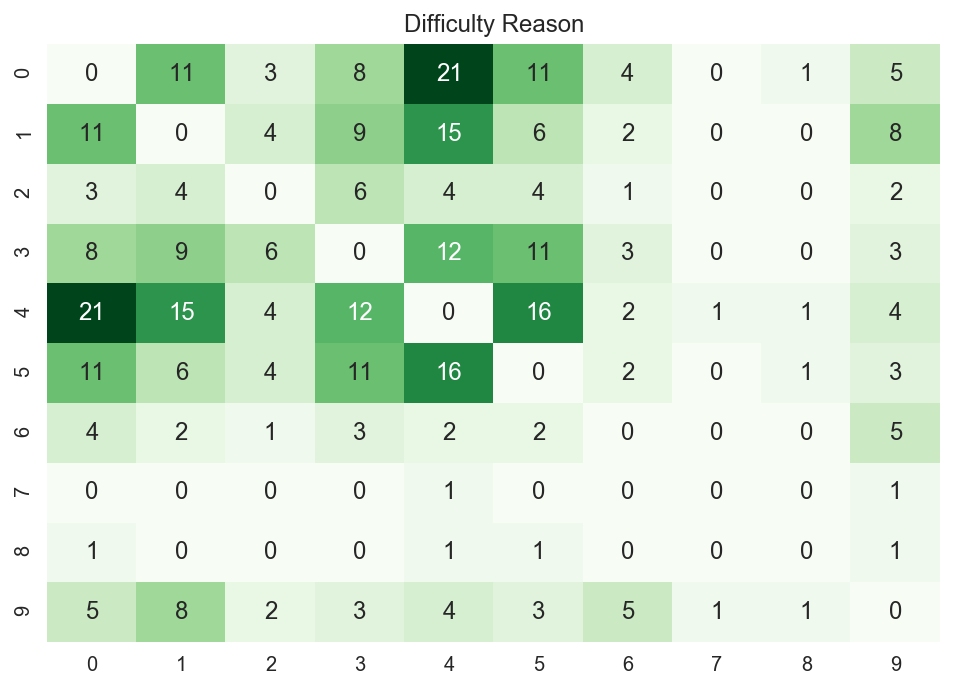

{0: 'メロディが複雑で正確に音程を取りづらい', 1: '音の飛びが激しく音程がとれない', 2: '音域が広い', 3: 'テンポが速い', 4: 'リズムが複雑でわかりにくい', 5: '16分音符などが多くてリズムが細かい', 6: 'ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある', 7: '英語の歌詞', 8: 'シャウトやビブラートなど特殊奏法', 9: 'other', 100: nan}


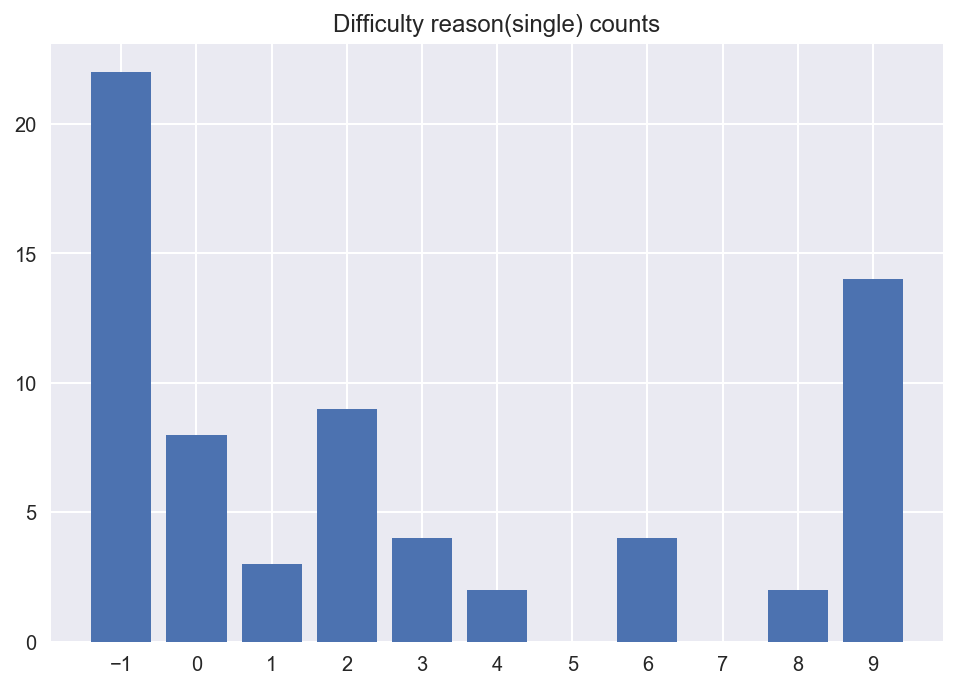

In [94]:
a = []
b = []
s = []
tantai = []
dif = [[0 for i in range (10)] for j in range(10)]
reason_section = []
#print(dif)
cf = Counter()
multi_reason = 0
for data in df["amero_reason"]:
    a.append(data.split(","))
    #print(a)
for num,reasons in enumerate(a):
   
    #print("reasons {},{}".format(reasons,type(reasons)))
    reasons = list(map(remove_space,reasons))
    if len(reasons) <= 1:
        tantai.append(remove_none(reasons[0]))
    else:
        lis = tessa(reasons)
        #print("lis : {}".format(lis))
        if multi_reason == 0:
            cf = Counter(lis)
            #print("tyoyo{}".format(cf))
        else:
            c = Counter(lis)
            cf = c + cf
        multi_reason +=1 
#print("all of riyuu:{}".format(cf))
cf_A = cf
reason_section.append(cf_A)
cf = Counter()
for data in df['bmero_reason']:
    b.append(data.split(","))
    #print(a)
for num,reasons in enumerate(b):
    #print("reasons {},{}".format(reasons,type(reasons)))
    reasons = list(map(remove_space,reasons))
    if len(reasons) <= 1:
        tantai.append(remove_none(reasons[0]))
    else:
        lis = tessa(reasons)
        #print("lis : {}".format(lis))
        if multi_reason == 0:
            cf = Counter(lis)
            #print("tyoyo{}".format(cf))
        else:
            c = Counter(lis)
            cf = c + cf
        multi_reason +=1 
#print("all of riyuu:{}".format(cf))
cf_B = cf
reason_section.append(cf_B)
cf = Counter()
for data in df['sabi_reason']:
    s.append(data.split(","))
    #print(a)
for num,reasons in enumerate(s):
    #print("reasons {},{}".format(reasons,type(reasons)))
    reasons = list(map(remove_space,reasons))
    if len(reasons) <= 1:
        tantai.append(remove_none(reasons[0]))
    else:
        lis = tessa(reasons)
        #print("lis : {}".format(lis))
        if multi_reason == 0:
            cf = Counter(lis)
            #print("tyoyo{}".format(cf))
        else:
            c = Counter(lis)
            cf = c + cf
        multi_reason +=1 
#print("all of riyuu:{}".format(cf))
cf_S = cf
reason_section.append(cf_S)

cf_all = cf_A + cf_B + cf_S
print(cf_all)

for riyuu in cf_all:
    print(riyuu)
    print(cf_all[riyuu])
    dif[int(riyuu[0])][int(riyuu[1])] += cf_all[riyuu]
    dif[int(riyuu[1])][int(riyuu[0])] += cf_all[riyuu]
sns.set()
sns.heatmap(dif,annot= True,cbar=False,cmap="Greens")
plt.title("Difficulty Reason")
plt.show()
tc = Counter(tantai)
left = tc.keys()
#left = list(map(str,sorted(tc.keys())))
height = tc.values()
plt.title("Difficulty reason(single) counts")
plt.bar(left,height)
plt.xticks(np.array(range(-1,10)))
print(difficulty_num)


In [93]:
df.to_csv("yobijikken_cleaned.csv",encoding="utf-8")

In [45]:
songs = ["チェリー","TSUNAMI","紅蓮の弓矢","浪漫飛行","アポロ","粉雪"]

In [3]:
def make_count_query(song,koumoku):
    #バグがでます
    print(df.query("song.str.contains("+song+")",engine="python")[koumoku].value.sounts())

In [4]:
make_count_query("チェリー","amero_difficulty")

NameError: name 'df' is not defined

In [54]:
#Aメロの難易度を集計

print(songs[0])
print(df.query('song.str.contains("チェリー")', engine='python')["amero_difficulty"].value_counts())
print(df.query('song.str.contains("チェリー")', engine='python')["amero_difficulty"].describe())
print(df.query('song.str.contains("チェリー")', engine='python')["amero_difficulty"].mode())
print(songs[1])
print(df.query('song.str.contains("TSUNAMI")', engine='python')["amero_difficulty"].value_counts())
print(df.query('song.str.contains("TSUNAMI")', engine='python')["amero_difficulty"].describe())
print(df.query('song.str.contains("TSUNAMI")', engine='python')["amero_difficulty"].mode())
print(songs[2])
print(df.query('song.str.contains("紅蓮の弓矢")', engine='python')["amero_difficulty"].value_counts())
print(df.query('song.str.contains("紅蓮の弓矢")', engine='python')["amero_difficulty"].describe())
print(df.query('song.str.contains("紅蓮の弓矢")', engine='python')["amero_difficulty"].mode())
print(songs[3])
print(df.query('song.str.contains("浪漫飛行")', engine='python')["amero_difficulty"].value_counts())
print(df.query('song.str.contains("浪漫飛行")', engine='python')["amero_difficulty"].describe())
print(df.query('song.str.contains("浪漫飛行")', engine='python')["amero_difficulty"].mode())
print(songs[4])
print(df.query('song.str.contains("アポロ")', engine='python')["amero_difficulty"].value_counts())
print(df.query('song.str.contains("アポロ")', engine='python')["amero_difficulty"].describe())
print(df.query('song.str.contains("アポロ")', engine='python')["amero_difficulty"].mode())
print(songs[5])
print(df.query('song.str.contains("粉雪")', engine='python')["amero_difficulty"].value_counts())
print(df.query('song.str.contains("粉雪")', engine='python')["amero_difficulty"].describe())
print(df.query('song.str.contains("粉雪")', engine='python')["amero_difficulty"].mode())
print("====Aメロ合計====\n{}".format(df["amero_difficulty"].value_counts()))

チェリー
2    3
1    2
3    1
Name: amero_difficulty, dtype: int64
count    6.000000
mean     1.833333
std      0.752773
min      1.000000
25%      1.250000
50%      2.000000
75%      2.000000
max      3.000000
Name: amero_difficulty, dtype: float64
0    2
dtype: int64
TSUNAMI
3    2
2    2
1    1
Name: amero_difficulty, dtype: int64
count    5.00000
mean     2.20000
std      0.83666
min      1.00000
25%      2.00000
50%      2.00000
75%      3.00000
max      3.00000
Name: amero_difficulty, dtype: float64
0    2
1    3
dtype: int64
紅蓮の弓矢
2    3
4    1
Name: amero_difficulty, dtype: int64
count    4.0
mean     2.5
std      1.0
min      2.0
25%      2.0
50%      2.0
75%      2.5
max      4.0
Name: amero_difficulty, dtype: float64
0    2
dtype: int64
浪漫飛行
3    3
4    1
1    1
Name: amero_difficulty, dtype: int64
count    5.000000
mean     2.800000
std      1.095445
min      1.000000
25%      3.000000
50%      3.000000
75%      3.000000
max      4.000000
Name: amero_difficulty, dtype: float64


In [49]:
#Bメロの難易度を集計
print(songs[0])
print(df.query('song.str.contains("チェリー")', engine='python')["bmero_difficulty"].value_counts())
print(df.query('song.str.contains("チェリー")', engine='python')["bmero_difficulty"].mean())
print(songs[1])
print(df.query('song.str.contains("TSUNAMI")', engine='python')["bmero_difficulty"].value_counts())
print(df.query('song.str.contains("TSUNAMI")', engine='python')["bmero_difficulty"].mean())
print(songs[2])
print(df.query('song.str.contains("紅蓮の弓矢")', engine='python')["bmero_difficulty"].value_counts())
print(df.query('song.str.contains("紅蓮の弓矢")', engine='python')["bmero_difficulty"].mean())
print(songs[3])
print(df.query('song.str.contains("浪漫飛行")', engine='python')["bmero_difficulty"].value_counts())
print(df.query('song.str.contains("浪漫飛行")', engine='python')["bmero_difficulty"].mean())
print(songs[4])
print(df.query('song.str.contains("アポロ")', engine='python')["bmero_difficulty"].value_counts())
print(df.query('song.str.contains("アポロ")', engine='python')["bmero_difficulty"].mean())
print(songs[5])
print(df.query('song.str.contains("粉雪")', engine='python')["bmero_difficulty"].value_counts())
print(df.query('song.str.contains("粉雪")', engine='python')["bmero_difficulty"].mean())
print("====Bメロ合計====\n{}".format(df["bmero_difficulty"].value_counts()))

チェリー
1    3
3    2
2    1
Name: bmero_difficulty, dtype: int64
1.8333333333333333
TSUNAMI
3    3
2    1
1    1
Name: bmero_difficulty, dtype: int64
2.4
紅蓮の弓矢
3    2
2    1
4    1
Name: bmero_difficulty, dtype: int64
3.0
浪漫飛行
4    2
3    1
2    1
1    1
Name: bmero_difficulty, dtype: int64
2.8
アポロ
3    4
2    1
Name: bmero_difficulty, dtype: int64
2.8
粉雪
2    3
4    1
3    1
1    1
Name: bmero_difficulty, dtype: int64
2.3333333333333335
====Bメロ合計====
3    16
2    14
1     7
4     6
Name: bmero_difficulty, dtype: int64


In [36]:
#サビの難易度を集計
print(songs[0])
print(df.query('song.str.contains("チェリー")', engine='python')["sabi_difficulty"].value_counts())
print(df.query('song.str.contains("チェリー")', engine='python')["sabi_difficulty"].mean())
print(songs[1])
print(df.query('song.str.contains("TSUNAMI")', engine='python')["sabi_difficulty"].value_counts())
print(df.query('song.str.contains("TSUNAMI")', engine='python')["sabi_difficulty"].mean())
print(songs[2])
print(df.query('song.str.contains("紅蓮の弓矢")', engine='python')["sabi_difficulty"].value_counts())
print(df.query('song.str.contains("紅蓮の弓矢")', engine='python')["sabi_difficulty"].mean())
print(songs[3])
print(df.query('song.str.contains("浪漫飛行")', engine='python')["sabi_difficulty"].value_counts())
print(df.query('song.str.contains("浪漫飛行")', engine='python')["sabi_difficulty"].mean())
print(songs[4])
print(df.query('song.str.contains("アポロ")', engine='python')["sabi_difficulty"].value_counts())
print(df.query('song.str.contains("アポロ")', engine='python')["sabi_difficulty"].mean())
print(songs[5])
print(df.query('song.str.contains("粉雪")', engine='python')["sabi_difficulty"].value_counts())
print(df.query('song.str.contains("")', engine='python')["sabi_difficulty"].mean())
print("====サビ合計====\n{}".format(df["sabi_difficulty"].value_counts()))

チェリー
2    3
3    2
1    1
Name: sabi_difficulty, dtype: int64
2.1666666666666665
TSUNAMI
2    3
1    2
Name: sabi_difficulty, dtype: int64
1.6
紅蓮の弓矢
2    2
3    1
1    1
Name: sabi_difficulty, dtype: int64
2.0
浪漫飛行
2    3
3    1
1    1
Name: sabi_difficulty, dtype: int64
2.0
アポロ
4    3
3    1
1    1
Name: sabi_difficulty, dtype: int64
3.2
粉雪
3    4
4    1
1    1
Name: sabi_difficulty, dtype: int64
2.558139534883721
====サビ合計====
3    15
2    13
4     8
1     7
Name: sabi_difficulty, dtype: int64


In [ ]:
def count_coencount_difficulty(dataframe):
    